In [121]:
# Imports

import db_functions
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import re
import warnings

import extented_pandas

from matplotlib import pyplot as plt
from enum import Enum

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV



In [4]:
# Plots and prints customization 

pd.options.display.max_columns = 999
warnings.filterwarnings("ignore")

sns.set_theme(context="notebook", style="darkgrid", palette="deep")
import matplotlib as mpl
mpl.rcParams['boxplot.flierprops.marker'] = 'd'

In [5]:
## Initial declarations

# Open DB connections
db_connection, db_cursor = db_functions.connect_to_database_mysql_connector()

# Decorator for the pipeline
pipeline_functions_dict = {}

def make_pipeline(func):
    pipeline_functions_dict[func.__name__] = func
    return func

# Enumerator for working with the dataframe columns
class Cols(Enum):
	Title = 'title'
	Type = 'tipo'
	Price = 'price'
	Floor = 'floor'
	Condominium = 'condominium_fee'
	Address = 'adress'
	District = 'bairro'
	Price_to_condominium_ratio = 'price_to_condominium_ratio'
	Area = 'area'
	Bedrooms = 'bedrooms'
	Garages = 'garage_spaces'
	Bathrooms = 'bathrooms'
	Test = 'test'
        
# Retrieves districts form Wikipedia
def get_districts() -> list:
	url = 'https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Balne%C3%A1rio_Cambori%C3%BA'

	df_districts = pd.read_html(url, header=0)[0]
	districts = df_districts['Bairro'].str.replace('(Das|Da|Dos)', '', regex=True).str.strip()

	# Removing header and footer
	districts = districts[(districts != 'TOTAL') & (districts != 'Bairro')]

	districts = districts.to_numpy()
	districts = np.insert(districts, 0, 'Barra Sul')
	return districts

print(f'Districts: {", ".join(get_districts())}')

Districts: Barra Sul, Ariribá, Centro, Barra, Nações, Estados, Municípios, Pioneiros, Jardim Iate Clube, Nova Esperança, Praia dos Amores, Região das Praias, São Judas Tadeu, Várzea do Ranchinho, Vila Real


In [6]:
# Retrieve data from 1st February 2023
useful_columns = ['id', 'title', 'adress', 'condominium_fee', 'price', 'taxes', 'area', 'bedrooms', 'garage_spaces', 'bathrooms', 'floor']
string_useful_columns = '`, `'.join(useful_columns)

df_train = pd.read_sql(f'SELECT `{string_useful_columns}` FROM `dados-imoveis` WHERE `scrapped_date` < "2023-02-02"', con=db_connection).set_index('id')
df_train[Cols.Test.value] = False

print(df_train.shape)
df_train

(9616, 11)


title  \
id                                                        
1       Cobertura com 3 Quartos à venda, 240m² - Centro   
2     Apartamento com 4 Quartos à venda, 167m² - Centro   
3     Apartamento com 4 Quartos à venda, 149m² - Centro   
4     Apartamento com 4 Quartos à venda, 129m² - Centro   
5     Apartamento com 3 Quartos à venda, 118m² - Centro   
...                                                 ...   
9632   Apartamento com 2 Quartos à venda, 90m² - Centro   
9633   Apartamento com 3 Quartos à venda, 76m² - Centro   
9634  Apartamento com 4 Quartos à venda, 215m² - Centro   
9635    Apartamento com 1 Quarto à venda, 52m² - Centro   
9636   Apartamento com 3 Quartos à venda, 98m² - Centro   

                                                 adress  condominium_fee  \
id                                                                         
1             Rua 901 - Centro, Balneário Camboriú - SC              NaN   
2            Rua 2950 - Centro, Balneário Camboriú - SC              NaN   
3            Rua 3140 - Centro, Balneário Camboriú - SC              NaN   
4     Avenida do Estado Dalmo Vieira - Centro, Balne...              NaN   
5            Rua 1901 - Centro, Balneário Camboriú - SC              NaN   
...                                                 ...              ...   
9632          Rua 904 - Centro, Balneário Camboriú - SC            400.0   
9633  Avenida do Estado Dalmo Vieira - Centro, Balne...              NaN   
9634         Rua 4100 - Centro, Balneário Camboriú - SC           1138.0   
9635                    Centro, Balneário Camboriú - SC            500.0   
9636         Rua 3610 - Centro, Balneário Camboriú - SC            470.0   

        price   taxes   area  bedrooms  garage_spaces  bathrooms  floor   test  
id                                                                              
1     4200000     NaN  240.0       3.0            2.0        1.0    NaN  False  
2     3418419     NaN  167.0       4.0            3.0        2.0    NaN  False  
3     2400000     NaN  149.0       4.0            2.0        1.0    NaN  False  
4     2751000     NaN  129.0       4.0            2.0        2.0    NaN  False  
5     2398000     NaN  118.0       3.0            2.0        1.0    NaN  False  
...       ...     ...    ...       ...            ...        ...    ...    ...  
9632  1000000     NaN   90.0       2.0            1.0        2.0    NaN  False  
9633   990000     NaN   76.0       3.0            1.0        2.0    NaN  False  
9634  1200000  4211.0  215.0       4.0            2.0        3.0    NaN  False  
9635   979000    93.0   52.0       1.0            1.0        1.0    NaN  False  
9636   980000   900.0   98.0       3.0            1.0        2.0    NaN  False  

[9616 rows x 11 columns]

In [7]:
# Retrieve data after 1st February 2023 for testing

df_test = pd.read_sql(f'SELECT `{string_useful_columns}` FROM `dados-imoveis` WHERE `scrapped_date` > "2023-02-02" AND `scrapped_date` < "2023-03-01"', con=db_connection).set_index('id')
df_test[Cols.Test.value] = True
y_test = df_test[Cols.Price.value]
df_test = df_test.drop(columns=Cols.Price.value)

print(df_test.shape)
df_test

(5853, 10)


title  \
id                                                         
9657   Apartamento com 3 Quartos à venda, 133m² - Pra...   
9658   Apartamento com 4 Quartos à venda, 167m² - Centro   
9659     Cobertura com 6 Quartos à venda, 471m² - Centro   
9660   Apartamento com 2 Quartos à venda, 118m² - Pra...   
9661   Apartamento com 3 Quartos à venda, 112m² - Centro   
...                                                  ...   
15603  Apartamento com 4 Quartos à venda, 249m² - Centro   
15604  Apartamento com 3 Quartos à venda, 150m² - Centro   
15605  Apartamento com 4 Quartos à venda, 140m² - Centro   
15606  Apartamento com 3 Quartos à venda, 275m² - Centro   
15607  Apartamento com 4 Quartos à venda, 180m² - Pio...   

                                                  adress  condominium_fee  \
id                                                                          
9657   Avenida do Estado Dalmo Vieira - Praia dos Amo...              NaN   
9658    Avenida Brasil - Centro, Balneário Camboriú - SC              NaN   
9659          Rua 2300 - Centro, Balneário Camboriú - SC              NaN   
9660   Avenida do Estado Dalmo Vieira - Praia dos Amo...              NaN   
9661     Rua 2950, 300 - Centro, Balneário Camboriú - SC            598.0   
...                                                  ...              ...   
15603  Avenida Atlântica - Centro, Balneário Camboriú...              NaN   
15604         Rua 1401 - Centro, Balneário Camboriú - SC              NaN   
15605         Rua 2500 - Centro, Balneário Camboriú - SC              NaN   
15606         Rua 1200 - Centro, Balneário Camboriú - SC              NaN   
15607                 Pioneiros, Balneário Camboriú - SC              NaN   

        taxes   area  bedrooms  garage_spaces  bathrooms  floor  test  
id                                                                     
9657      NaN  133.0       3.0            2.0        2.0    NaN  True  
9658      NaN  167.0       4.0            2.0        1.0    NaN  True  
9659      NaN  471.0       6.0            3.0        3.0    NaN  True  
9660      NaN  118.0       2.0            1.0        1.0    NaN  True  
9661   1486.0  112.0       3.0            2.0        3.0   11.0  True  
...       ...    ...       ...            ...        ...    ...   ...  
15603     NaN  249.0       4.0            3.0        4.0    NaN  True  
15604     NaN  150.0       3.0            2.0        3.0    NaN  True  
15605     NaN  140.0       4.0            2.0        2.0    NaN  True  
15606     NaN  275.0       3.0            2.0        3.0    NaN  True  
15607     NaN  180.0       4.0            3.0        4.0    NaN  True  

[5853 rows x 10 columns]

In [8]:
# Joining dataframes

df = pd.concat([df_train, df_test])
print(len(df_train) + len(df_test))
print(df.shape)

df.head()

15469
(15469, 11)


title  \
id                                                      
1     Cobertura com 3 Quartos à venda, 240m² - Centro   
2   Apartamento com 4 Quartos à venda, 167m² - Centro   
3   Apartamento com 4 Quartos à venda, 149m² - Centro   
4   Apartamento com 4 Quartos à venda, 129m² - Centro   
5   Apartamento com 3 Quartos à venda, 118m² - Centro   

                                               adress  condominium_fee  \
id                                                                       
1           Rua 901 - Centro, Balneário Camboriú - SC              NaN   
2          Rua 2950 - Centro, Balneário Camboriú - SC              NaN   
3          Rua 3140 - Centro, Balneário Camboriú - SC              NaN   
4   Avenida do Estado Dalmo Vieira - Centro, Balne...              NaN   
5          Rua 1901 - Centro, Balneário Camboriú - SC              NaN   

        price  taxes   area  bedrooms  garage_spaces  bathrooms  floor   test  
id                                                                             
1   4200000.0    NaN  240.0       3.0            2.0        1.0    NaN  False  
2   3418419.0    NaN  167.0       4.0            3.0        2.0    NaN  False  
3   2400000.0    NaN  149.0       4.0            2.0        1.0    NaN  False  
4   2751000.0    NaN  129.0       4.0            2.0        2.0    NaN  False  
5   2398000.0    NaN  118.0       3.0            2.0        1.0    NaN  False

In [9]:
# Retrieving all amenities data

sql_query_amenities = 'SELECT * FROM `imoveis-balneario-camboriu`.amenities WHERE house_id in (SELECT id FROM `dados-imoveis`);'

df_amenities = pd.read_sql(sql_query_amenities, con=db_connection) \
    .drop(columns='id') \
    .set_index('house_id') \
    .fillna(0)

print('Shape', df_amenities.shape)

df_amenities.head()

Shape (18260, 171)


academia  aceita_animais  acesso_para_deficientes  \
house_id                                                      
1                1               0                        0   
2                1               0                        0   
3                1               0                        0   
4                0               0                        0   
5                1               0                        0   

          ambientes_integrados  andar_inteiro  aquecimento  aquário  \
house_id                                                              
1                            0              0            0        0   
2                            0              0            0        0   
3                            0              0            0        0   
4                            0              0            0        0   
5                            0              0            0        0   

          ar-condicionado  arenoso  argiloso  armário_embutido  \
house_id                                                         
1                       0        0         0                 0   
2                       0        0         0                 0   
3                       0        0         0                 0   
4                       0        0         0                 0   
5                       0        0         0                 0   

          armário_embutido_no_quarto  armário_na_cozinha  armário_no_banheiro  \
house_id                                                                        
1                                  0                   0                    0   
2                                  0                   0                    0   
3                                  0                   0                    0   
4                                  0                   0                    0   
5                                  0                   0                    0   

          arvorismo  banheira  banheiro_de_serviço  bar  bar_na_piscina  \
house_id                                                                  
1                 0         0                    0    0               0   
2                 0         0                    0    0               0   
3                 0         0                    0    0               0   
4                 0         0                    0    0               0   
5                 0         0                    0    0               0   

          bicicletário  box_blindex  brinquedoteca  cabeamento_estruturado  \
house_id                                                                     
1                    0            0              0                       0   
2                    0            0              0                       0   
3                    0            0              0                       0   
4                    0            0              0                       0   
5                    0            0              0                       0   

          campo_de_futebol  churrasqueira  churrasqueira_na_varanda  \
house_id                                                              
1                        0              0                         0   
2                        0              0                         0   
3                        0              0                         0   
4                        0              0                         0   
5                        0              0                         0   

          chuveiro_a_gás  cinema  circuito_de_segurança  closet  \
house_id                                                          
1                      0       0                      0       0   
2                      0       0                      0       0   
3                      0       0                      1       0   
4                      0       0                      0       0   
5                      0       0                      0       0   

In [10]:
# Checking which type to use

df_amenities.astype('int8').info()
print('')
df_amenities.astype('bool').info()

<class 'pandas.core.frame.DataFrame'>
Index: 18260 entries, 1 to 18577
Columns: 171 entries, academia to zelador
dtypes: int8(171)
memory usage: 3.1 MB

<class 'pandas.core.frame.DataFrame'>
Index: 18260 entries, 1 to 18577
Columns: 171 entries, academia to zelador
dtypes: bool(171)
memory usage: 3.1 MB


In [11]:
# Converting df Amenities datatype

def correct_amenities_datatype(df_in: pd.DataFrame) -> pd.DataFrame:
	return df_in.astype('int8')

df_amenities = correct_amenities_datatype(df_amenities)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15469 entries, 1 to 15607
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            15469 non-null  object 
 1   adress           15469 non-null  object 
 2   condominium_fee  6790 non-null   float64
 3   price            9616 non-null   float64
 4   taxes            5741 non-null   float64
 5   area             15448 non-null  float64
 6   bedrooms         14566 non-null  float64
 7   garage_spaces    14379 non-null  float64
 8   bathrooms        14967 non-null  float64
 9   floor            1772 non-null   float64
 10  test             15469 non-null  bool   
dtypes: bool(1), float64(8), object(2)
memory usage: 1.3+ MB


# 1. Pre-cleaning

## 1.1 Dropping duplicates

In [13]:
@make_pipeline
def df_drop_duplicates(df_in: pd.DataFrame) -> pd.DataFrame:
	print('Number of duplicates dropped:', df_in[df_in.duplicated()].shape[0])
	return df_in.drop_duplicates()

df = pipeline_functions_dict['df_drop_duplicates'](df)

Number of duplicates dropped: 770


## 1.2 Adding Type Column

In [14]:
# Including the type column
@make_pipeline
def insert_type_column(df_in: pd.DataFrame) -> pd.DataFrame:
	df_in.loc[:, Cols.Type.value] = df_in[Cols.Title.value].str.split('( à venda| para venda )', expand=True, regex=True)[0]
	df_in.loc[:, Cols.Type.value] = df_in[Cols.Type.value].str.split(' com ', expand=True)[0]
	return df_in

df = pipeline_functions_dict['insert_type_column'](df)

pd.DataFrame(df[Cols.Type.value].value_counts().head(20)).reset_index().rename({'index':'Type', 'tipo':'Count'}, axis=1)

Count  count
0                      Apartamento  11866
1                             Casa    951
2                        Cobertura    626
3        Conjunto Comercial / Sala    328
4      Terreno / Lote / Condomínio    308
5               Casa de Condomínio    229
6   Loja / Salão / Ponto Comercial     97
7                   Casa Comercial     47
8                     com 1 Quarto     42
9                   Prédio Inteiro     25
10                          Kitnet     14
11        Terreno / Lote Comercial     11
12                            Flat     11
13                    Casa de Vila      9
14     Galpão / Depósito / Armazém      9
15       Fazenda / Sítio / Chácara      7
16          à venda, 97m² - Centro      6
17        à venda, 2378m² - Nacoes      5
18          à venda, 37m² - Centro      5
19          à venda, 80m² - Centro      4

In [15]:
# Keeping only types of interest
@make_pipeline
def keep_only_certain_types(df_in: pd.DataFrame) -> pd.DataFrame:
	house_types = ['Apartamento', 'Casa', 'Cobertura', 'Casa de Condomínio']
	mask_house_types = df_in[Cols.Type.value].str.contains(f'(?:{"$|".join(house_types)})', regex=True)
	
	print('Percentage of relevant entriess by type: ', "%.1f" % ((len(df_in[mask_house_types]) / len(df_in))*100 )+ '%')

	return df_in[mask_house_types]

df = pipeline_functions_dict['keep_only_certain_types'](df)

df[Cols.Type.value].value_counts()

Percentage of relevant entriess by type:  93.0%


tipo
Apartamento           11866
Casa                    951
Cobertura               626
Casa de Condomínio      229
Name: count, dtype: int64

## 1.3 Adding district column

For this we'll retrieve from Wikipedia the district names, remove the words 'das' and 'dos', which are often ommited from the adressess, add Barra Sul which is an commom informal neighbourhood found in exploration, then search for these keywords in the adresses.

In [16]:
# Setting distric column and checking values
@make_pipeline
def set_district_columm(df_in: pd.DataFrame) -> pd.DataFrame:
	districts = get_districts()
	df_in[Cols.District.value] = df_in[Cols.Address.value].str.extract('({})'.format('|'.join(districts)), flags=re.IGNORECASE)
	
	sum_empty = df_in[Cols.District.value].isna().sum().sum()
	print(f'Empty values in the district column that will be dropped: {sum_empty} - % of total: {sum_empty / len(df_in):.2%}')

	# Dropna
	df_in = df_in[~df_in[Cols.District.value].isna()]

	return df_in

df = pipeline_functions_dict['set_district_columm'](df)

df[Cols.District.value].value_counts()

Empty values in the district column that will be dropped: 964 - % of total: 7.05%


bairro
Centro               9999
Pioneiros            1035
Barra Sul             498
Barra                 355
Ariribá               349
Praia dos Amores      181
Vila Real             105
Estados               101
São Judas Tadeu        46
Nações                 25
Jardim Iate Clube      12
Região das Praias       1
Municípios              1
Name: count, dtype: int64

### 1.2.1 Inference

1. Most entries are from just one district - Centro
2. Some Districts have way too few entries, as to not give a bias to these districts we'll input anything below 100 as others
3. Since there aren't many NA values we'll drop them instead of inputting a value

### 1.2.2 Removing small districts and dropping NA districts

In [17]:
# Removing small districts
@make_pipeline
def remove_small_districts(df_in: pd.DataFrame) -> pd.DataFrame:
	distric_count = df_in[Cols.District.value].value_counts()
	small_districts = {i_district:'other' for i_district in distric_count[distric_count < 100].index}

	df_in[Cols.District.value] = df_in[Cols.District.value].replace(small_districts)
		
	return df_in

df = pipeline_functions_dict['remove_small_districts'](df)

print(df.shape)
df.head()

(12708, 13)


title  \
id                                                      
1     Cobertura com 3 Quartos à venda, 240m² - Centro   
2   Apartamento com 4 Quartos à venda, 167m² - Centro   
3   Apartamento com 4 Quartos à venda, 149m² - Centro   
4   Apartamento com 4 Quartos à venda, 129m² - Centro   
5   Apartamento com 3 Quartos à venda, 118m² - Centro   

                                               adress  condominium_fee  \
id                                                                       
1           Rua 901 - Centro, Balneário Camboriú - SC              NaN   
2          Rua 2950 - Centro, Balneário Camboriú - SC              NaN   
3          Rua 3140 - Centro, Balneário Camboriú - SC              NaN   
4   Avenida do Estado Dalmo Vieira - Centro, Balne...              NaN   
5          Rua 1901 - Centro, Balneário Camboriú - SC              NaN   

        price  taxes   area  bedrooms  garage_spaces  bathrooms  floor   test  \
id                                                                              
1   4200000.0    NaN  240.0       3.0            2.0        1.0    NaN  False   
2   3418419.0    NaN  167.0       4.0            3.0        2.0    NaN  False   
3   2400000.0    NaN  149.0       4.0            2.0        1.0    NaN  False   
4   2751000.0    NaN  129.0       4.0            2.0        2.0    NaN  False   
5   2398000.0    NaN  118.0       3.0            2.0        1.0    NaN  False   

           tipo  bairro  
id                       
1     Cobertura  Centro  
2   Apartamento  Centro  
3   Apartamento  Centro  
4   Apartamento  Centro  
5   Apartamento  Centro

## 1.4 Summary

In [18]:
extented_pandas.infoOut(df, details=True)

Max/Min non-null: (12708, 1531) 

         # Dtypes
Dtype            
float64         8
object          4
bool            1 



### 1.3.1 Inference

1. Floor and taxes have way too much null values, we'll drop these columns as they are not reliable for prediction

In [19]:
# Removes floor and taxes
@make_pipeline
def drop_floor_and_taxes(df_in: pd.DataFrame) -> pd.DataFrame:
	return df_in.drop(['floor', 'taxes'], axis=1)

df = pipeline_functions_dict['drop_floor_and_taxes'](df)
df.head()

title  \
id                                                      
1     Cobertura com 3 Quartos à venda, 240m² - Centro   
2   Apartamento com 4 Quartos à venda, 167m² - Centro   
3   Apartamento com 4 Quartos à venda, 149m² - Centro   
4   Apartamento com 4 Quartos à venda, 129m² - Centro   
5   Apartamento com 3 Quartos à venda, 118m² - Centro   

                                               adress  condominium_fee  \
id                                                                       
1           Rua 901 - Centro, Balneário Camboriú - SC              NaN   
2          Rua 2950 - Centro, Balneário Camboriú - SC              NaN   
3          Rua 3140 - Centro, Balneário Camboriú - SC              NaN   
4   Avenida do Estado Dalmo Vieira - Centro, Balne...              NaN   
5          Rua 1901 - Centro, Balneário Camboriú - SC              NaN   

        price   area  bedrooms  garage_spaces  bathrooms   test         tipo  \
id                                                                             
1   4200000.0  240.0       3.0            2.0        1.0  False    Cobertura   
2   3418419.0  167.0       4.0            3.0        2.0  False  Apartamento   
3   2400000.0  149.0       4.0            2.0        1.0  False  Apartamento   
4   2751000.0  129.0       4.0            2.0        2.0  False  Apartamento   
5   2398000.0  118.0       3.0            2.0        1.0  False  Apartamento   

    bairro  
id          
1   Centro  
2   Centro  
3   Centro  
4   Centro  
5   Centro

# 2. Data exploration

## 2.1 Numerical Columns

### 2.1.1 Prices

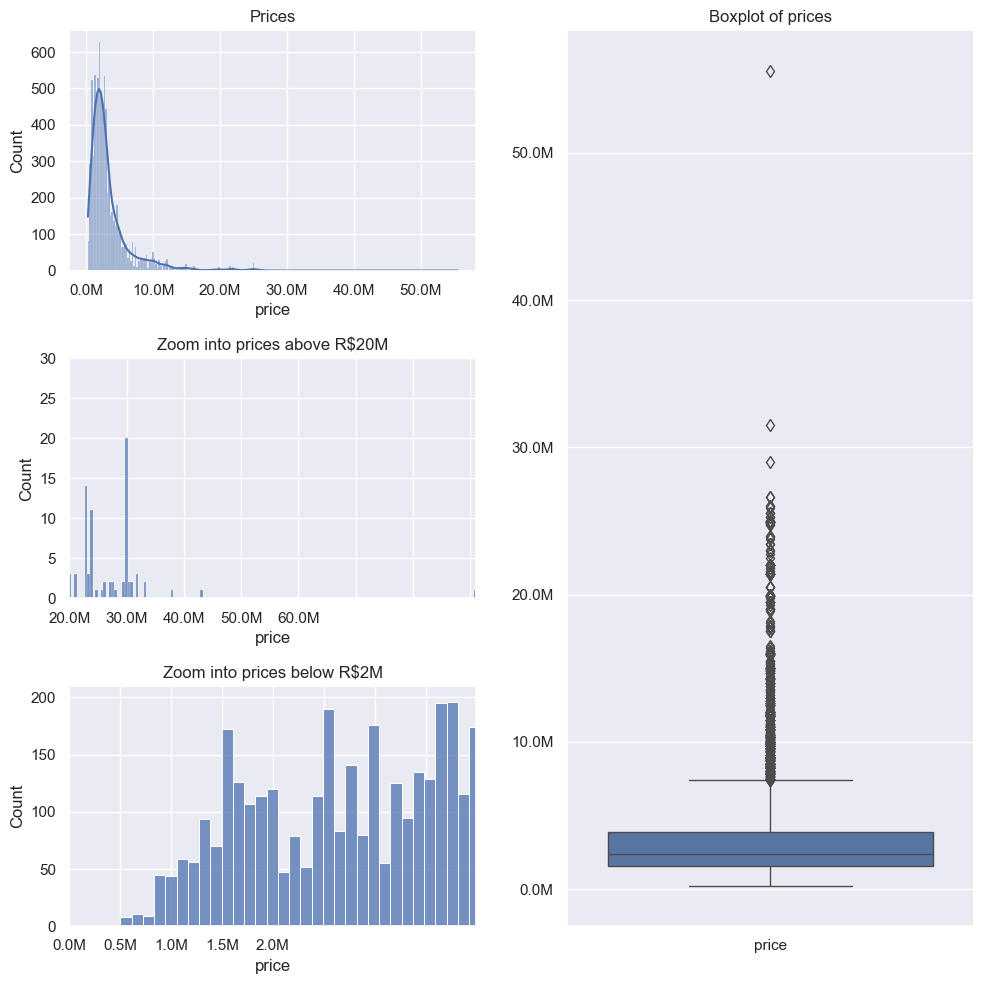

In [20]:
# Plots to understand the distribution and outliers

def set_xticks_to_millions(ax: plt.Axes):
	xlabels = ['{:,.1f}'.format(x) + 'M' for x in ax.get_xticks()/1000000]
	ax.set_xticklabels(xlabels)

fig, axs = plt.subplots(3, 2, figsize=(10,10), sharey=False)
axs = axs.reshape(1, -1)[0]

# All prices
ax = axs[0]
sns.histplot(data=df[Cols.Price.value], ax=ax, kde=True).set(title='Prices')
set_xticks_to_millions(ax)

# Above 20M
ax = axs[2]

ax.set_xlim(left=2e7, right=df[Cols.Price.value].max())
ax.set_ylim(top=30)
sns.histplot(data=df[Cols.Price.value], ax=ax).set(title='Zoom into prices above R$20M')
set_xticks_to_millions(ax)

# Below 3M
ax = axs[4]

ax.set_xlim(right=2e6)
sns.histplot(data=df[Cols.Price.value], ax=ax, bins=1000).set(title='Zoom into prices below R$2M')
set_xticks_to_millions(ax)

# Boxplot with all prices
# remove the underlying axes

for i in [1,3,5]:
	axs[i].remove()

gs = axs[1].get_gridspec()
axbig = fig.add_subplot(gs[0:, 1])
sns.boxplot(data=df[Cols.Price.value].to_frame(), ax=axbig).set(title='Boxplot of prices')

ylabels = ['{:,.1f}'.format(x) + 'M' for x in axbig.get_yticks()/1000000]
axbig.set_yticklabels(ylabels)

fig.tight_layout()

In [21]:
df[Cols.Price.value].describe()

count    8.030000e+03
mean     3.451377e+06
std      3.486889e+06
min      2.500000e+05
25%      1.550000e+06
50%      2.400000e+06
75%      3.900000e+06
max      5.554000e+07
Name: price, dtype: float64

In [22]:
print('Cheapest entries')

df.sort_values(by=Cols.Price.value).head(5)

Cheapest entries


title  \
id                                                        
3928           Casa com 2 Quartos à venda, 61m² - Barra   
3738    Apartamento com 2 Quartos à venda, 50m² - Barra   
4710  Apartamento com 2 Quartos à venda, 45m² - São ...   
646   Apartamento com 2 Quartos à venda, 46m² - São ...   
4334          Casa com 2 Quartos à venda, 150m² - Barra   

                                                 adress  condominium_fee  \
id                                                                         
3928                     Barra, Balneário Camboriú - SC              NaN   
3738                     Barra, Balneário Camboriú - SC              NaN   
4710  Rua Sargento Mário Manoel Rodrigues, 310 - São...              NaN   
646   Rua Amara Pereira Corrêa, 100 - São Judas Tade...              NaN   
4334  Rua Vereador Eduardo Rodrigues de Melo, 42 - B...              NaN   

         price   area  bedrooms  garage_spaces  bathrooms   test         tipo  \
id                                                                              
3928  250000.0   61.0       2.0            1.0        1.0  False         Casa   
3738  260000.0   50.0       2.0            1.0        1.0  False  Apartamento   
4710  280000.0   45.0       2.0            1.0        1.0  False  Apartamento   
646   294290.0   46.0       2.0            1.0        1.0  False  Apartamento   
4334  297000.0  150.0       2.0            1.0        1.0  False         Casa   

     bairro  
id           
3928  Barra  
3738  Barra  
4710  other  
646   other  
4334  Barra

In [23]:
print('Most expensive entries')

df[~df[Cols.Price.value].isna()].sort_values(by=Cols.Price.value).tail(5)

Most expensive entries


title  \
id                                                        
5537  Apartamento com 4 Quartos à venda, 316m² - Centro   
5075  Apartamento com 4 Quartos à venda, 316m² - Centro   
5629  Apartamento com 4 Quartos à venda, 343m² - Centro   
211   Apartamento com 4 Quartos à venda, 343m² - Centro   
5636    Cobertura com 9 Quartos à venda, 872m² - Centro   

                                                 adress  condominium_fee  \
id                                                                         
5537                    Centro, Balneário Camboriú - SC              NaN   
5075  Avenida Atlântica, 2670 - Centro, Balneário Ca...           2500.0   
5629  Avenida Atlântica, 2414 - Centro, Balneário Ca...              NaN   
211                     Centro, Balneário Camboriú - SC              NaN   
5636  Avenida Atlântica, 270 - Centro, Balneário Cam...              NaN   

           price   area  bedrooms  garage_spaces  bathrooms   test  \
id                                                                   
5537  26600000.0  316.0       4.0            4.0        5.0  False   
5075  26600000.0  316.0       4.0            4.0        5.0  False   
5629  29000000.0  343.0       4.0            5.0        6.0  False   
211   31500000.0  343.0       4.0            4.0        5.0  False   
5636  55540000.0  872.0       9.0            6.0       12.0  False   

             tipo  bairro  
id                         
5537  Apartamento  Centro  
5075  Apartamento  Centro  
5629  Apartamento  Centro  
211   Apartamento  Centro  
5636    Cobertura  Centro

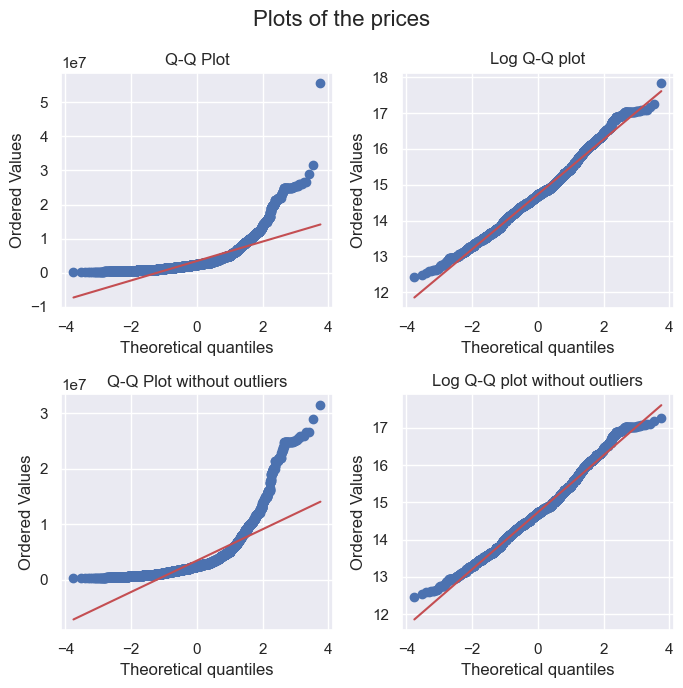

In [24]:
# Probability plots

fig, axs = plt.subplots(2, 2, figsize=(7,7), sharey=False)
fig.suptitle('Plots of the prices', fontsize=16)
axs = axs.reshape(1, -1)[0]

ax = axs[0]

stats.probplot(df[Cols.Price.value].dropna(), plot=ax)
ax.set_title('Q-Q Plot')

ax = axs[1]

stats.probplot(np.log1p(df[Cols.Price.value].dropna().sort_values()).iloc[:], plot=ax)
ax.set_title('Log Q-Q plot');

# Probability plots without outliers
ax = axs[2]

stats.probplot(df[Cols.Price.value].dropna().sort_values().iloc[1:-1], plot=ax)
ax.set_title('Q-Q Plot without outliers')

ax = axs[3]

stats.probplot(np.log1p(df[Cols.Price.value].dropna().sort_values()).iloc[1:-1], plot=ax)
ax.set_title('Log Q-Q plot without outliers');

fig.tight_layout()

In [25]:
format_mapping = {Cols.Price.value: "R$ {:,.0f}"}
pd.DataFrame(df[Cols.Price.value].describe()).style.format(format_mapping)

#### 2.1.1.1 Inference

1. As expected, the graph is right skewed
2. The box plot and the probability plots show that there are a few outliers, the leftmost outlier is to be considered a typo (the location and price are not realistically feasible) and therefore will be removed while the rightmost is to be maintained
3. The log of the prices are fairly normally distributed and will be used like this for a better model performance
4. The average is 3.4M, while the median lies below that value at 2.4M, as is expected with right skewed data

#### 2.1.1.2 Removing outliers

In [26]:
# Removes prices below 210_000 while keeping the test entries without a price
@make_pipeline
def remove_small_prices(df_in: pd.DataFrame) -> pd.DataFrame:
	df_in = df_in[(df_in[Cols.Price.value] > 210_000) | (df_in[Cols.Test.value] == True)]
	return df_in

df = pipeline_functions_dict['remove_small_prices'](df)
df.sort_values(Cols.Price.value).head()

title  \
id                                                        
3928           Casa com 2 Quartos à venda, 61m² - Barra   
3738    Apartamento com 2 Quartos à venda, 50m² - Barra   
4710  Apartamento com 2 Quartos à venda, 45m² - São ...   
646   Apartamento com 2 Quartos à venda, 46m² - São ...   
4334          Casa com 2 Quartos à venda, 150m² - Barra   

                                                 adress  condominium_fee  \
id                                                                         
3928                     Barra, Balneário Camboriú - SC              NaN   
3738                     Barra, Balneário Camboriú - SC              NaN   
4710  Rua Sargento Mário Manoel Rodrigues, 310 - São...              NaN   
646   Rua Amara Pereira Corrêa, 100 - São Judas Tade...              NaN   
4334  Rua Vereador Eduardo Rodrigues de Melo, 42 - B...              NaN   

         price   area  bedrooms  garage_spaces  bathrooms   test         tipo  \
id                                                                              
3928  250000.0   61.0       2.0            1.0        1.0  False         Casa   
3738  260000.0   50.0       2.0            1.0        1.0  False  Apartamento   
4710  280000.0   45.0       2.0            1.0        1.0  False  Apartamento   
646   294290.0   46.0       2.0            1.0        1.0  False  Apartamento   
4334  297000.0  150.0       2.0            1.0        1.0  False         Casa   

     bairro  
id           
3928  Barra  
3738  Barra  
4710  other  
646   other  
4334  Barra

### 2.1.2 Condominium fees

In [27]:
condomiun_values = df[~df[Cols.Condominium.value].isna()][Cols.Condominium.value].astype(int).sort_values()
condomiun_values.describe().apply(lambda x: format(x, 'f'))

count        5988.000000
mean         6765.407983
std        190727.753693
min             1.000000
25%           520.000000
50%           800.000000
75%          1200.000000
max      11000000.000000
Name: condominium_fee, dtype: object

The mean is way above the 75% percentile, aswell as the maximum value having an unreal amount, this indicates that there were errors while entering the values.

**Ratio**

As the condominium fee usually scales with the house price we'll use this as a comparison to find out which places had a wrongly inputted value

In [28]:
df_condominium_ratio = pd.DataFrame(df[Cols.Condominium.value] / df[Cols.Price.value]).rename({0: Cols.Price_to_condominium_ratio.value}, axis=1)

df_condominium_ratio.describe().drop('count').applymap(lambda x: format(x, '%'))

price_to_condominium_ratio
mean                  0.239724%
std                   3.862850%
min                   0.000004%
25%                   0.030000%
50%                   0.040222%
75%                   0.052000%
max                 100.000000%

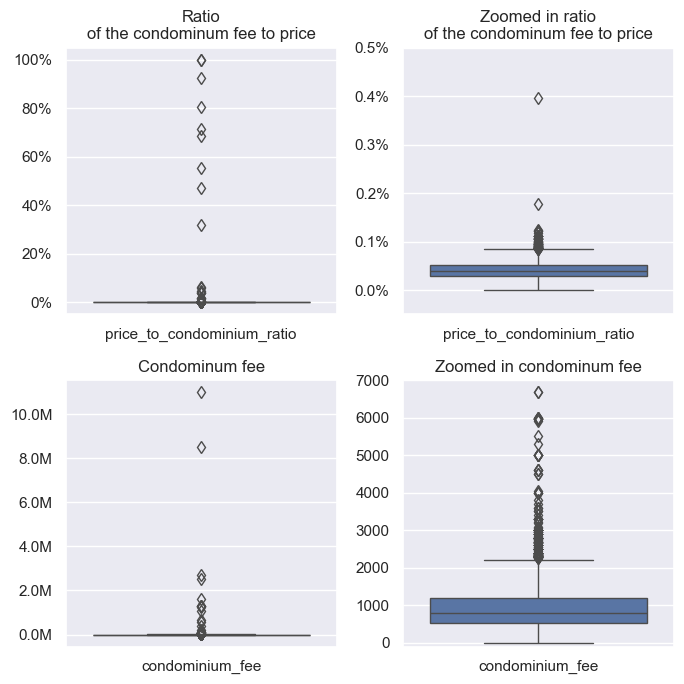

In [29]:
# Boxplots with the condominium fees and their ratios

fig, axs = plt.subplots(2, 2, figsize=(7,7), sharey=False)
axs = axs.reshape(1, -1)[0]

# 0 to 100% plot
ax =axs[0]
sns.boxplot(data=df_condominium_ratio, ax=ax)
ylabels = ['{:.0%}'.format(x) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
ax.set(title='Ratio\nof the condominum fee to price')

# zoomed in plot 0 to 100%
ax = axs[1]

sns.boxplot(data=df_condominium_ratio, ax=ax)
ax.set_ylim(bottom=-0.0005, top=0.005)
ylabels = ['{:.1%}'.format(x) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
ax.set(title='Zoomed in ratio\nof the condominum fee to price')

# Condominium fees
ax = axs[2]

sns.boxplot(data=df[Cols.Condominium.value].to_frame(), ax=ax)
ylabels = ['{:0}M'.format(x/1000000) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
ax.set(title='Condominum fee')

# Zoomed in condominium fees
ax = axs[3]

sns.boxplot(data=df[Cols.Condominium.value].to_frame(), ax=ax)
ax.set(title='Zoomed in condominum fee')
ax.set_ylim(bottom=-100, top=7000)

fig.tight_layout()

In [30]:
# Remove upper bound wrongly inputted condominiums

_, upper_bound_condominium_ratio = extented_pandas.get_outliers(df_condominium_ratio[Cols.Price_to_condominium_ratio.value], by='IQR')
print("Number of values above upper bound:", df_condominium_ratio[df_condominium_ratio > upper_bound_condominium_ratio].dropna().count()[0])
print("Number of values below upper bound:", df_condominium_ratio[df_condominium_ratio < upper_bound_condominium_ratio].dropna().count()[0])

df_condominium_ratio = df_condominium_ratio[df_condominium_ratio < upper_bound_condominium_ratio]

Number of values above upper bound: 94
Number of values below upper bound: 3336


In [31]:
# Join DF to further analyse condominium

joint_df = pd.merge(left=df, right=df_condominium_ratio, how='outer', left_index=True, right_index=True)
joint_df = joint_df[joint_df[Cols.Price_to_condominium_ratio.value].isna() == False]

print(joint_df.shape)
joint_df.head(5)

(3336, 12)


title  \
id                                                       
91    Apartamento com 2 Quartos à venda, 77m² - Centro   
94    Apartamento com 2 Quartos à venda, 75m² - Centro   
95   Apartamento com 3 Quartos à venda, 135m² - Centro   
99   Apartamento com 4 Quartos à venda, 241m² - Centro   
101  Casa de Condomínio com 5 Quartos à venda, 525m...   

                                                adress  condominium_fee  \
id                                                                        
91          Rua 2870 - Centro, Balneário Camboriú - SC            350.0   
94                     Centro, Balneário Camboriú - SC            400.0   
95                     Centro, Balneário Camboriú - SC           1100.0   
99                     Centro, Balneário Camboriú - SC           2000.0   
101  Avenida das Arapongas, 650 - Ariribá, Balneári...           1200.0   

         price   area  bedrooms  garage_spaces  bathrooms   test  \
id                                                                 
91    560000.0   77.0       2.0            1.0        1.0  False   
94    780000.0   75.0       2.0            1.0        2.0  False   
95   1800000.0  135.0       3.0            2.0        4.0  False   
99   2400000.0  241.0       4.0            3.0        5.0  False   
101  5500000.0  525.0       5.0            6.0        6.0  False   

                   tipo   bairro  price_to_condominium_ratio  
id                                                            
91          Apartamento   Centro                    0.000625  
94          Apartamento   Centro                    0.000513  
95          Apartamento   Centro                    0.000611  
99          Apartamento   Centro                    0.000833  
101  Casa de Condomínio  Ariribá                    0.000218

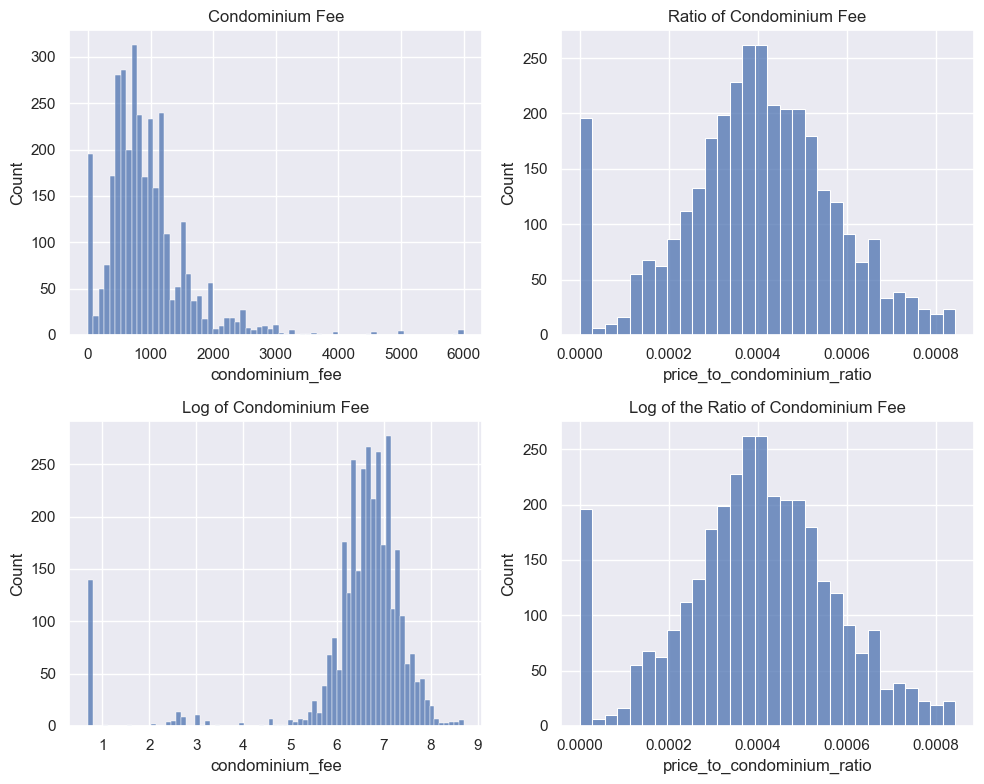

In [32]:
# Histplot of condominium and ratio

fig, axs = plt.subplots(2, 2, figsize=(10,8), sharey=False)
axs = axs.reshape(1, -1)[0]

# Condominium

ax = axs[0]
sns.histplot(data=joint_df[Cols.Condominium.value], ax=ax)
ax.set_title('Condominium Fee')

# Ratio

ax = axs[1]
sns.histplot(data=joint_df[Cols.Price_to_condominium_ratio.value], ax=ax)
ax.set_title('Ratio of Condominium Fee')

# Condominium

ax = axs[2]
sns.histplot(data=np.log1p(joint_df[Cols.Condominium.value]), ax=ax)
ax.set_title('Log of Condominium Fee')

# Ratio

ax = axs[3]
sns.histplot(data=joint_df[Cols.Price_to_condominium_ratio.value], ax=ax)
ax.set_title('Log of the Ratio of Condominium Fee')

fig.tight_layout()

**Lower Bound**

In the logs there are clear outliers on the left side of the graph, there appears to be human input error to all values below 100, as these a not feasiable condominium values, these values will be removed as well.

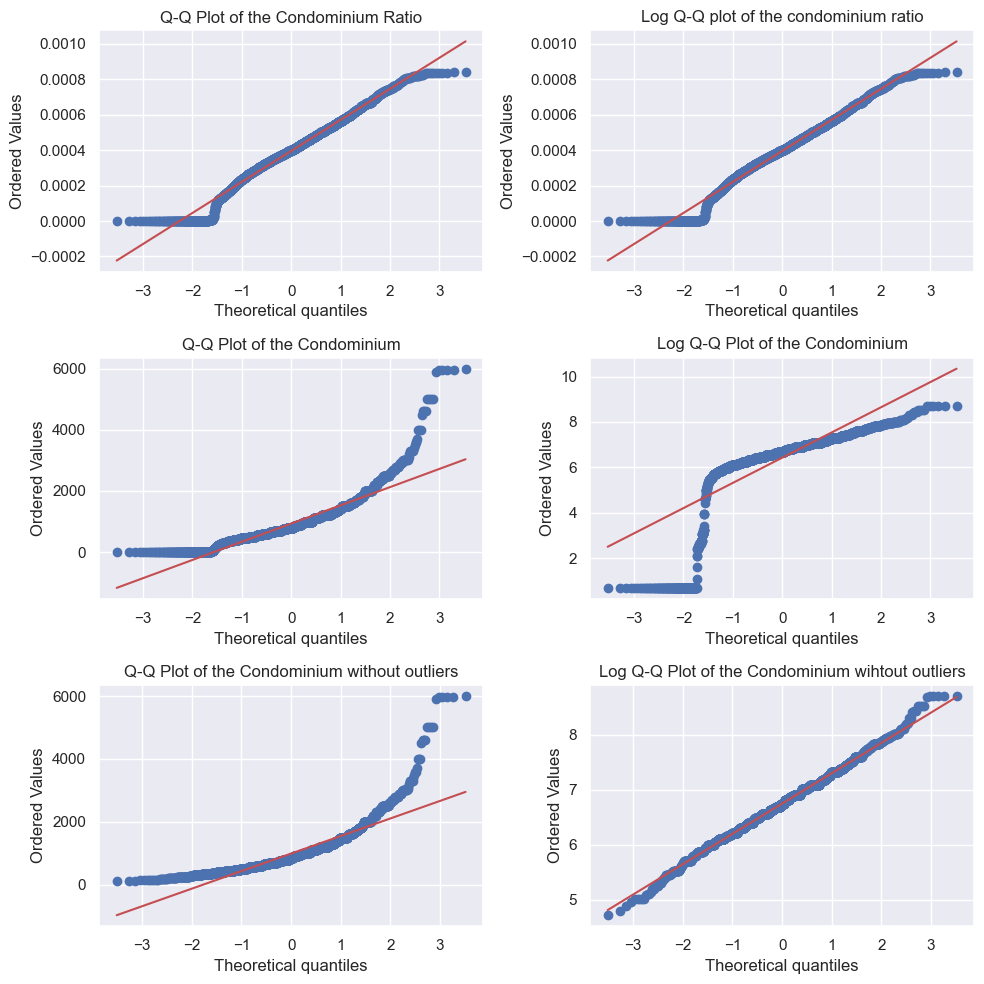

In [33]:
# Probability plots

fig, axs = plt.subplots(3, 2, figsize=(10,10), sharey=False)
axs = axs.reshape(1, -1)[0]

ax = axs[0]

stats.probplot(joint_df[Cols.Price_to_condominium_ratio.value], plot=ax)
ax.set_title('Q-Q Plot of the Condominium Ratio')

ax = axs[1]

stats.probplot(np.log1p(joint_df[Cols.Price_to_condominium_ratio.value]), plot=ax)
ax.set_title('Log Q-Q plot of the condominium ratio');

# Probability plots without outliers
ax = axs[2]

stats.probplot(joint_df[Cols.Condominium.value], plot=ax)
ax.set_title('Q-Q Plot of the Condominium')

ax = axs[3]

stats.probplot(np.log1p(joint_df[Cols.Condominium.value]), plot=ax)
ax.set_title('Log Q-Q Plot of the Condominium');

# Probability plots without outliers
ax = axs[4]

stats.probplot(joint_df.loc[joint_df[Cols.Condominium.value] > 100,Cols.Condominium.value], plot=ax)
ax.set_title('Q-Q Plot of the Condominium without outliers')

ax = axs[5]

stats.probplot(np.log1p(joint_df.loc[joint_df[Cols.Condominium.value] > 100,Cols.Condominium.value]), plot=ax)
ax.set_title('Log Q-Q Plot of the Condominium wihtout outliers');

fig.tight_layout()

#### 2.1.2.1 Inference

1. There are a lot of very strong outliers, mostly deemed input errors
2. 75% of values are below 0.052% of the apartment price
3. To deal with the upper bound outliers we'll use the the 75% + 1.5 x the inter quartile range as suggested by experts as a threshold for what we'll consider a non-error and insert a np.NaN on values above this level.
4. For the lower bound of what we consider human error we'll use a value of R$100

### 2.1.3 Area

In [34]:
df[Cols.Area.value].describe()

count     12708.000000
mean        184.856468
std        1731.241326
min          10.000000
25%         120.000000
50%         143.000000
75%         190.000000
max      195000.000000
Name: area, dtype: float64

<Axes: xlabel='area', ylabel='price'>

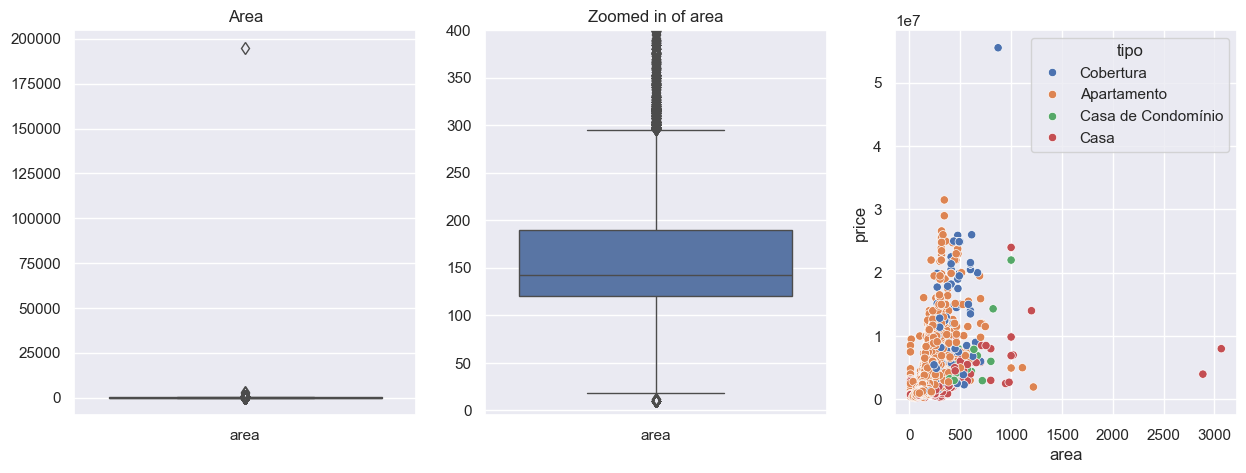

In [35]:
# Boxplots with the condominium fees and their ratios

fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=False)
axs = axs.reshape(1, -1)[0]

# Area Boxplot
ax = axs[0]
sns.boxplot(data=df[Cols.Area.value].to_frame(), ax=ax)
ax.set(title='Area')

# zoomed in plot
ax = axs[1]

sns.boxplot(data=df[Cols.Area.value].to_frame(), ax=ax)
ax.set_ylim(top=400, bottom=-5)
ax.set(title='Zoomed in of area')

# Scatterplot against price
ax = axs[2]

sns.scatterplot(data=df, x=Cols.Area.value, y=Cols.Price.value, ax=ax, hue='tipo')

In [36]:
print('Smallest areas')

df.sort_values(Cols.Area.value).head()

Smallest areas


title  \
id                                                         
12835       Casa com 3 Quartos à venda, 10m² - Vila Real   
5503   Apartamento com 1 Quarto à venda, 10m² - Praia...   
8267    Apartamento com 4 Quartos à venda, 10m² - Centro   
2257   Casa com 3 Quartos à venda, 10m² - Praia dos A...   
8247          Casa com 4 Quartos à venda, 10m² - Ariribá   

                                                  adress  condominium_fee  \
id                                                                          
12835  Rua Dom Carlos, 64 - Vila Real, Balneário Camb...              NaN   
5503   Rua Carlos Drummond de Andrade, 197 - Praia do...              NaN   
8267                     Centro, Balneário Camboriú - SC              NaN   
2257           Praia dos Amores, Balneário Camboriú - SC              NaN   
8247                    Ariribá, Balneário Camboriú - SC              NaN   

           price  area  bedrooms  garage_spaces  bathrooms   test  \
id                                                                  
12835        NaN  10.0       3.0            4.0        2.0   True   
5503   1150000.0  10.0       1.0            NaN        1.0  False   
8267   2200000.0  10.0       4.0            2.0        3.0  False   
2257    990000.0  10.0       3.0            2.0        3.0  False   
8247   4700000.0  10.0       4.0           10.0        5.0  False   

              tipo            bairro  
id                                    
12835         Casa         Vila Real  
5503   Apartamento  Praia dos Amores  
8267   Apartamento            Centro  
2257          Casa  Praia dos Amores  
8247          Casa           Ariribá

In [37]:
print('Biggest areas')

df.sort_values(Cols.Area.value).tail()

Biggest areas


title  \
id                                                         
5245          Casa com 3 Quartos à venda, 1200m² - Barra   
4508   Apartamento com 3 Quartos à venda, 1219m² - Ce...   
4288          Casa com 3 Quartos à venda, 2886m² - Barra   
4568          Casa com 3 Quartos à venda, 3067m² - Barra   
15094      Casa com 3 Quartos à venda, 195000m² - Centro   

                                                  adress  condominium_fee  \
id                                                                          
5245   Avenida Rodesindo Pavan, 7200 - Barra, Balneár...              NaN   
4508                     Centro, Balneário Camboriú - SC            773.0   
4288                      Barra, Balneário Camboriú - SC              NaN   
4568                      Barra, Balneário Camboriú - SC              NaN   
15094                    Centro, Balneário Camboriú - SC              NaN   

            price      area  bedrooms  garage_spaces  bathrooms   test  \
id                                                                       
5245   14000000.0    1200.0       3.0            5.0        4.0  False   
4508    1950000.0    1219.0       3.0            3.0        4.0  False   
4288    3980000.0    2886.0       3.0           10.0        5.0  False   
4568    8000000.0    3067.0       3.0           10.0        2.0  False   
15094         NaN  195000.0       3.0            NaN        3.0   True   

              tipo  bairro  
id                          
5245          Casa   Barra  
4508   Apartamento  Centro  
4288          Casa   Barra  
4568          Casa   Barra  
15094         Casa  Centro

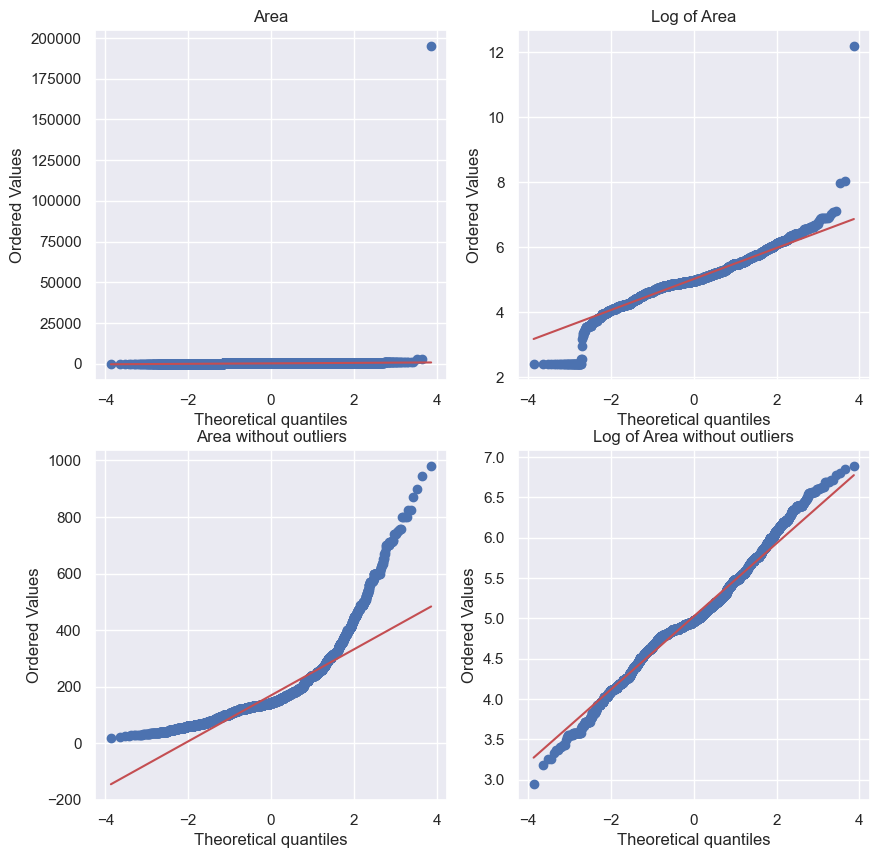

In [38]:
# Q-Q Plots

fig, axs = plt.subplots(2, 2, figsize=(10,10), sharey=False)
axs = axs.reshape(1, -1)[0]

# Area Q-Q Plot
ax =axs[0]
stats.probplot(df[Cols.Area.value], plot=ax);
ax.set(title='Area')

# Log Area Q-Q Plot
ax =axs[1]
stats.probplot(np.log1p(df[Cols.Area.value]), plot=ax);
ax.set(title='Log of Area');

lower_bound_area, upper_bound_area = extented_pandas.get_outliers(df[Cols.Area.value], by='IQR')

# Area Q-Q Plot without outliers
df_without_area_outliers = df[(df[Cols.Area.value] > lower_bound_area) & (df[Cols.Area.value] < 1_000)]
ax =axs[2]
stats.probplot(df_without_area_outliers[Cols.Area.value], plot=ax);
ax.set(title='Area without outliers')
 
# Log Area Q-Q Plot
ax =axs[3]
stats.probplot(np.log1p(df_without_area_outliers[Cols.Area.value]), plot=ax);
ax.set(title='Log of Area without outliers');

Inference:

1. There are heavy outliers on both ends, on the lower end we'll use the Q25 - 1,5*IQR rule as stated before, on the higher end we'll set a limit of 1500, as to remove both upper outliers
2. The log of the area without outliers are fairly normal and will be used as such

In [39]:
# Removes small and big outliers in areas
@make_pipeline
def remove_small_and_big_areas(df_in: pd.DataFrame) -> pd.DataFrame:
	maximum_area = 1_500
	lower_bound_area, _ = extented_pandas.get_outliers(df_in[Cols.Area.value], by='IQR')
	values_before_removal = len(df_in)
	df_in = df_in[(df_in[Cols.Area.value] > lower_bound_area) & (df_in[Cols.Area.value] < maximum_area)]
	print(f'Number of entries removed because of the area: {values_before_removal - len(df_in)}')

	return df_in

df = pipeline_functions_dict['remove_small_and_big_areas'](df)
df.head()

Number of entries removed because of the area: 46


title  \
id                                                      
1     Cobertura com 3 Quartos à venda, 240m² - Centro   
2   Apartamento com 4 Quartos à venda, 167m² - Centro   
3   Apartamento com 4 Quartos à venda, 149m² - Centro   
4   Apartamento com 4 Quartos à venda, 129m² - Centro   
5   Apartamento com 3 Quartos à venda, 118m² - Centro   

                                               adress  condominium_fee  \
id                                                                       
1           Rua 901 - Centro, Balneário Camboriú - SC              NaN   
2          Rua 2950 - Centro, Balneário Camboriú - SC              NaN   
3          Rua 3140 - Centro, Balneário Camboriú - SC              NaN   
4   Avenida do Estado Dalmo Vieira - Centro, Balne...              NaN   
5          Rua 1901 - Centro, Balneário Camboriú - SC              NaN   

        price   area  bedrooms  garage_spaces  bathrooms   test         tipo  \
id                                                                             
1   4200000.0  240.0       3.0            2.0        1.0  False    Cobertura   
2   3418419.0  167.0       4.0            3.0        2.0  False  Apartamento   
3   2400000.0  149.0       4.0            2.0        1.0  False  Apartamento   
4   2751000.0  129.0       4.0            2.0        2.0  False  Apartamento   
5   2398000.0  118.0       3.0            2.0        1.0  False  Apartamento   

    bairro  
id          
1   Centro  
2   Centro  
3   Centro  
4   Centro  
5   Centro

### 2.1.4 Bedrooms, Garage spaces and Bathrooms	

#### 2.1.4.1

Removing outliers

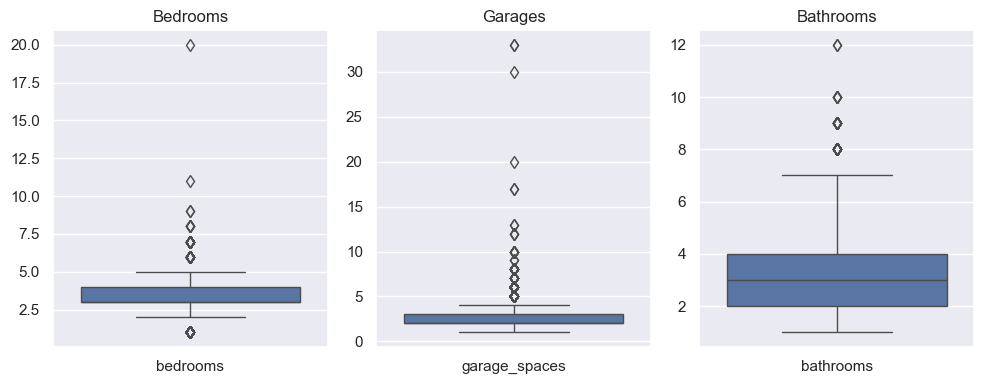

In [40]:
# Barcharts and boxplots

fig, axs = plt.subplots(1, 3, figsize=(10,4), sharey=False)
axs = iter(axs.reshape(1, -1)[0])

# Bedrooms
ax = next(axs)
sns.boxplot(data=df[Cols.Bedrooms.value].to_frame(), ax=ax)
ax.set(title='Bedrooms')

# Garages
ax = next(axs)

sns.boxplot(data=df[Cols.Garages.value].to_frame(), ax=ax)
ax.set(title='Garages')

# Bathrooms
ax = next(axs)

sns.boxplot(data=df[Cols.Bathrooms.value].to_frame(), ax=ax)
ax.set(title='Bathrooms');

fig.tight_layout()

In [41]:
df[Cols.Bedrooms.value].value_counts().sort_index()

bedrooms
1.0      345
2.0     1510
3.0     6229
4.0     4070
5.0      381
6.0       65
7.0       53
8.0        5
9.0        2
11.0       1
20.0       1
Name: count, dtype: int64

For these 3 features we'll use the rule that an outlier is a value that is more than 3 standard deviations from the mean (abs(zscore) > 3)

In [42]:
@make_pipeline
def remove_bedrooms_garages_bathrooms_outliers(df_in: pd.DataFrame):
    for iCol in [Cols.Bedrooms.value, Cols.Garages.value, Cols.Bathrooms.value]:
        _, upper_bound_outliers = extented_pandas.get_outliers(df_in[iCol])
        # upper_bound_outliers = np.ceil(upper_bound_outliers)
        print(f'Number of removed outliers in {iCol}: {(df_in[iCol] > upper_bound_outliers).sum()} (Upper bound: {upper_bound_outliers})')
        df_in = df_in[(df_in[iCol] < upper_bound_outliers) | (df_in[iCol].isna())]
    
    return df_in

df = pipeline_functions_dict['remove_bedrooms_garages_bathrooms_outliers'](df)

Number of removed outliers in bedrooms: 127 (Upper bound: 5.871796631667949)
Number of removed outliers in garage_spaces: 68 (Upper bound: 6.223939930707358)
Number of removed outliers in bathrooms: 8 (Upper bound: 7.508667462651267)


#### 2.1.4.2 Filling NAs

In [43]:
# Total NA
df.loc[:, [Cols.Bedrooms.value, Cols.Garages.value, Cols.Bathrooms.value]].isna().sum()

bedrooms           0
garage_spaces    384
bathrooms          0
dtype: int64

In [44]:
mask_empty_garages = df[Cols.Garages.value].isna()
df[mask_empty_garages][Cols.Area.value]

id
88        85.0
90        87.0
136      150.0
304       80.0
405      129.0
         ...  
15365    104.0
15376     52.0
15461     54.0
15478    130.0
15546    175.0
Name: area, Length: 384, dtype: float64

In [45]:
# knn_garage_inputer_columns = ['area', 'bedrooms', 'garage_spaces', 'bathrooms', 'tipo', 'bairro']
# knn_garage_inputer = KNNImputer()
# knn_garage_inputer.fit(pd.get_dummies(df[knn_garage_inputer_columns], drop_first=True))
# dummy_df = pd.get_dummies(df[knn_garage_inputer_columns], drop_first=True)
# df_inp_garages = pd.DataFrame(knn_garage_inputer.transform(dummy_df), columns=dummy_df.columns)
# df_inp_garages[Cols.Garages.value].value_counts().sort_index()

##### 2.1.4.1.1 Inference

1. Only garage has NA in these features
2. For the inputation we'll use a simple ratio with the area using the mean (74.5m² per Garage), with an upper ratio of 5 garages

In [46]:
# Fill NA garages

@make_pipeline
def input_empty_garages(df_in:pd.DataFrame) -> pd.DataFrame:
    mean_garage_per_m2 = (df_in[Cols.Area.value] / df_in[Cols.Garages.value]).mean()
    mask_empty_garages = df_in[Cols.Garages.value].isna()
    garages_inputation = np.round(df_in.loc[mask_empty_garages, Cols.Area.value] / mean_garage_per_m2, 0)
    
    _, upper_bound_garages = np.ceil(extented_pandas.get_outliers(df_in[Cols.Garages.value], by='IQR'))
    garages_inputation[garages_inputation > upper_bound_garages] = upper_bound_garages
    df_in.loc[garages_inputation.index, Cols.Garages.value] = garages_inputation
    
    return df_in

df = pipeline_functions_dict['input_empty_garages'](df)

In [47]:
# # Fill NA garages

# @make_pipeline
# def input_empty_garages(df_in:pd.DataFrame) -> pd.DataFrame:
#     knn_garage_inputer_columns = ['area', 'bedrooms', 'garage_spaces', 'bathrooms', 'tipo', 'bairro']
#     knn_garage_inputer = KNNImputer()
#     dummy_df = pd.get_dummies(df_in[knn_garage_inputer_columns], drop_first=True)
#     knn_garage_inputer.fit(dummy_df)
#     df_in[Cols.Garages.value] = pd.DataFrame(knn_garage_inputer.transform(dummy_df), columns=dummy_df.columns).iloc[:, dummy_df.columns.get_loc(Cols.Garages.value)]
    
#     return df_in

# # df = pipeline_functions_dict['input_empty_garages'](df)
# df = pipeline_functions_dict['input_empty_garages'](df)

#### 2.1.4.2 Exploration

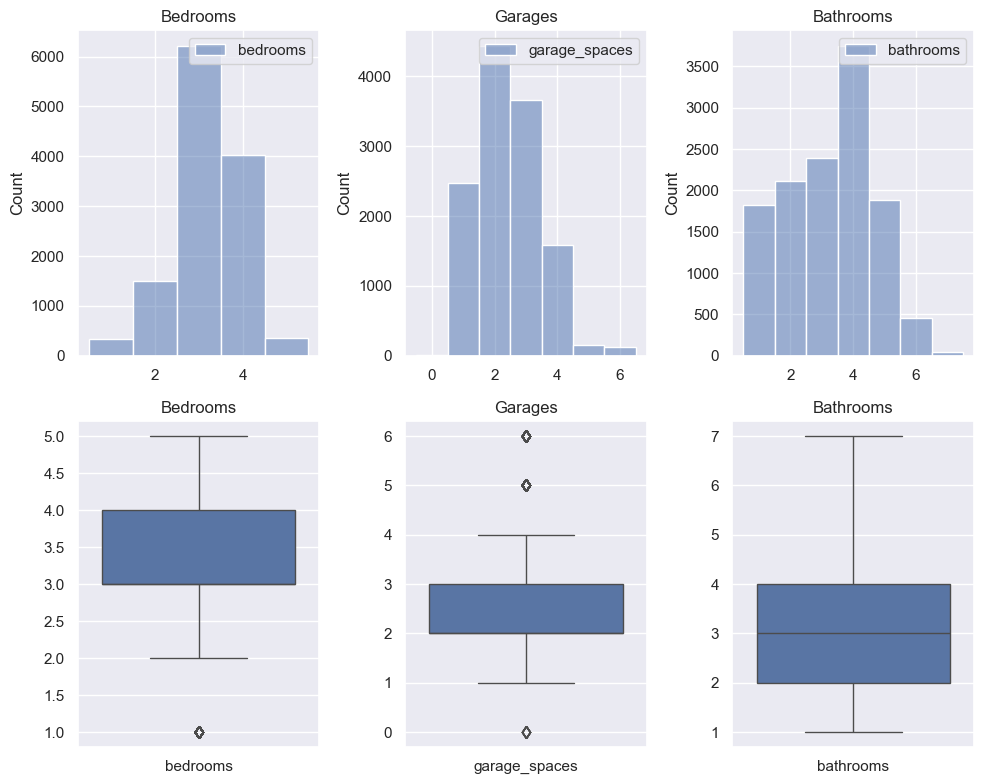

In [48]:
# Barcharts and boxplots

fig, axs = plt.subplots(2, 3, figsize=(10,8), sharey=False)
axs = iter(axs.reshape(1, -1)[0])

# Bedrooms
ax = next(axs)
sns.histplot(data=df[Cols.Bedrooms.value].to_frame(), ax=ax, discrete=True)
ax.set(title='Bedrooms')

# Garages
ax = next(axs)

sns.histplot(data=df[Cols.Garages.value].to_frame(), ax=ax, discrete=True)
ax.set(title='Garages')

# Bathrooms
ax = next(axs)

sns.histplot(data=df[Cols.Bathrooms.value].to_frame(), ax=ax, discrete=True)
ax.set(title='Bathrooms');

# Bedrooms
ax = next(axs)
sns.boxplot(data=df[Cols.Bedrooms.value].to_frame(), ax=ax)
ax.set(title='Bedrooms')

# Garages
ax = next(axs)

sns.boxplot(data=df[Cols.Garages.value].to_frame(), ax=ax)
ax.set(title='Garages')

# Bathrooms
ax = next(axs)

sns.boxplot(data=df[Cols.Bathrooms.value].to_frame(), ax=ax)
ax.set(title='Bathrooms');

fig.tight_layout()

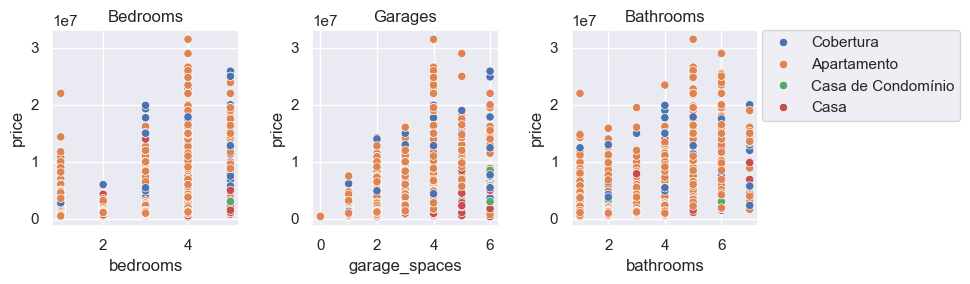

In [49]:
# Scatterplots

fig, axs = plt.subplots(1, 3, figsize=(10,3), sharey=False)

axs = iter(axs.reshape(1, -1)[0])

# Bedrooms
ax = next(axs)
sns.scatterplot(data=df, x=Cols.Bedrooms.value, y=Cols.Price.value, hue=Cols.Type.value, ax=ax, legend=False)
ax.set(title='Bedrooms')

# Garages
ax = next(axs)

sns.scatterplot(data=df, x=Cols.Garages.value, y=Cols.Price.value, hue=Cols.Type.value, ax=ax, legend=False)
ax.set(title='Garages')

# Bathrooms
ax = next(axs)

sns.scatterplot(data=df, x=Cols.Bathrooms.value, y=Cols.Price.value, hue=Cols.Type.value, ax=ax)
ax.set(title='Bathrooms');

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

fig.tight_layout()

#### 2.1.4.1 Inference

1. There are no big outliers in these features
2. They will be used as is

### 2.1.5 Correlations

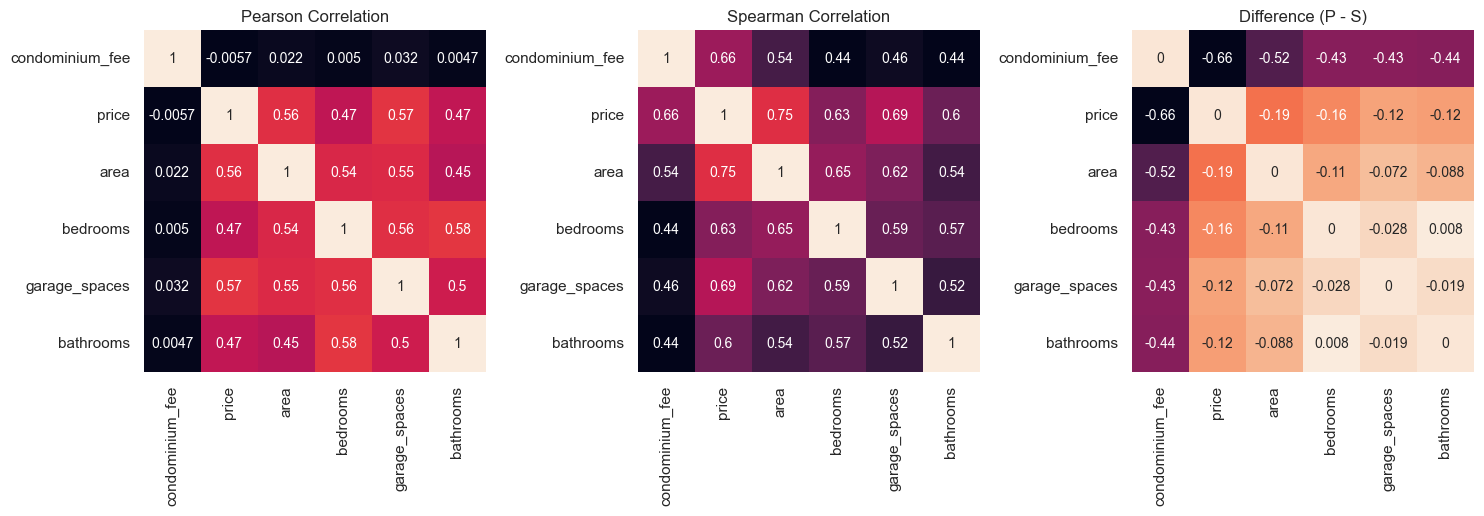

In [50]:
numerical_columns = df.describe().columns

persons_corr = df.drop(columns=Cols.Test.value)[numerical_columns].corr()
spearman_corr = df.drop(columns=Cols.Test.value)[numerical_columns].corr(method='spearman')

# Scatterplots

fig, axs = plt.subplots(1, 3, figsize=(15,8), sharey=False)

axs = iter(axs.reshape(1, -1)[0])

sns.heatmap(persons_corr, square=True, annot=True, annot_kws={'size':10}, ax=next(axs), cbar=False).set_title('Pearson Correlation')
sns.heatmap(spearman_corr, square=True, annot=True, annot_kws={'size':10}, ax=next(axs), cbar=False).set_title('Spearman Correlation')
sns.heatmap(persons_corr - spearman_corr, square=True, annot=True, annot_kws={'size':10}, ax=next(axs), cbar=False).set_title('Difference (P - S)')

fig.tight_layout()

#### 2.1.5.1 Inference

1. Condominium Fee appears to have a very non-linear realtion to price
2. Other features seem to have a somewhat linear relation to price
3. No other numerical features explain each other

## 2.2 Categorical Features

### 2.2.1 District

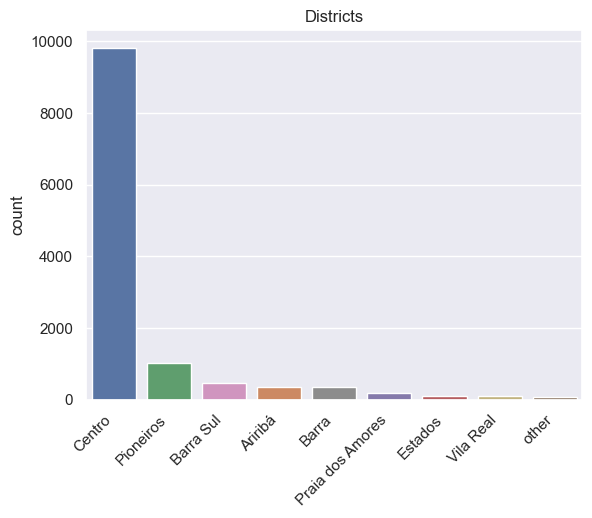

In [51]:
ax = sns.countplot(data=df,
                   x=Cols.District.value, 
                   order=df[Cols.District.value].value_counts().index.tolist(),
                   hue=Cols.District.value
)

ax.set(xlabel=None, title='Districts')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

In [52]:
numerical_columns.tolist() + [Cols.District.value]

['condominium_fee',
 'price',
 'area',
 'bedrooms',
 'garage_spaces',
 'bathrooms',
 'bairro']

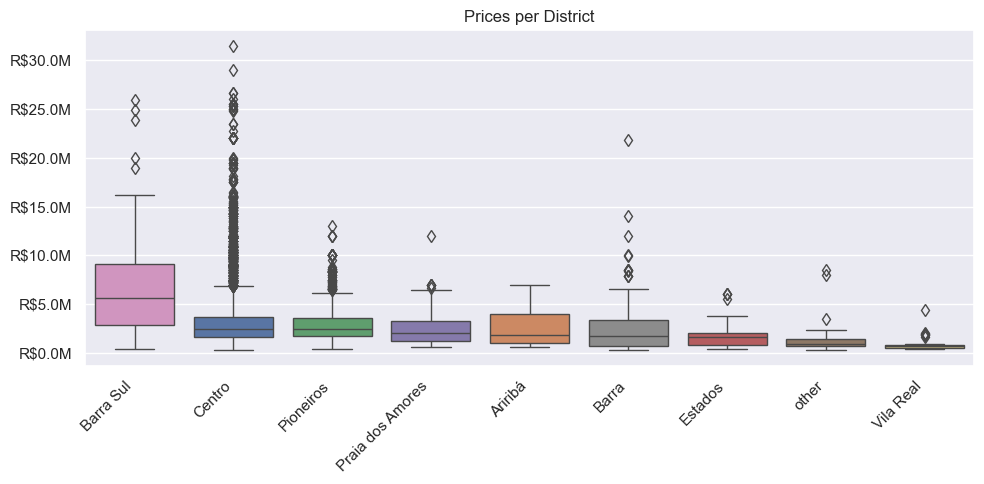

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10,5), sharey=True)

distric_boxplot_order = df.groupby(by=Cols.District.value) \
    .mean(1) \
	.sort_values(by=Cols.Price.value, ascending=False) \
	.index \
	.to_list()

sns.boxplot(data=df, x=Cols.District.value, y=Cols.Price.value, ax=ax, order=distric_boxplot_order, hue=Cols.District.value)

ax.set_title('Prices per District')

ylabels = ['R${:,.1f}'.format(x) + 'M' for x in ax.get_yticks()/1_000_000]
ax.set_yticklabels(ylabels)

ax.set(xlabel=None, ylabel=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

fig.tight_layout()

#### 2.2.1.1 Inference

1. Barra Sul is the most expensive District in average, but Centro has the most expensive entries
2. Vila Real is the cheapest in average
3. Centro has a big range, from 250.000 to 55.000.000

In [54]:
pd.get_dummies(df[Cols.District.value], prefix='district_')

district__Ariribá  district__Barra  district__Barra Sul  \
id                                                               
1                  False            False                False   
2                  False            False                False   
3                  False            False                False   
4                  False            False                False   
5                  False            False                False   
...                  ...              ...                  ...   
15603              False            False                False   
15604              False            False                False   
15605              False            False                False   
15606              False            False                False   
15607              False            False                False   

       district__Centro  district__Estados  district__Pioneiros  \
id                                                                
1                  True              False                False   
2                  True              False                False   
3                  True              False                False   
4                  True              False                False   
5                  True              False                False   
...                 ...                ...                  ...   
15603              True              False                False   
15604              True              False                False   
15605              True              False                False   
15606              True              False                False   
15607             False              False                 True   

       district__Praia dos Amores  district__Vila Real  district__other  
id                                                                       
1                           False                False            False  
2                           False                False            False  
3                           False                False            False  
4                           False                False            False  
5                           False                False            False  
...                           ...                  ...              ...  
15603                       False                False            False  
15604                       False                False            False  
15605                       False                False            False  
15606                       False                False            False  
15607                       False                False            False  

[12459 rows x 9 columns]

### 2.2.2 Type

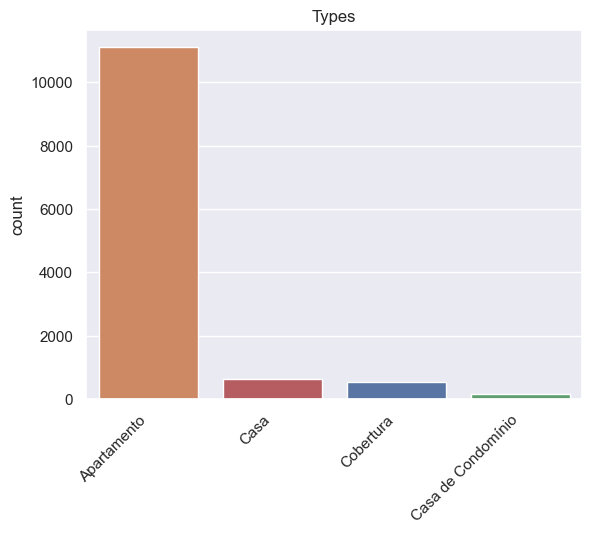

In [55]:
ax = sns.countplot(data=df,
                   x=Cols.Type.value, 
                   order=df[Cols.Type.value].value_counts().index.tolist(),
                   hue=Cols.Type.value
)

ax.set(xlabel=None, title='Types')


ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

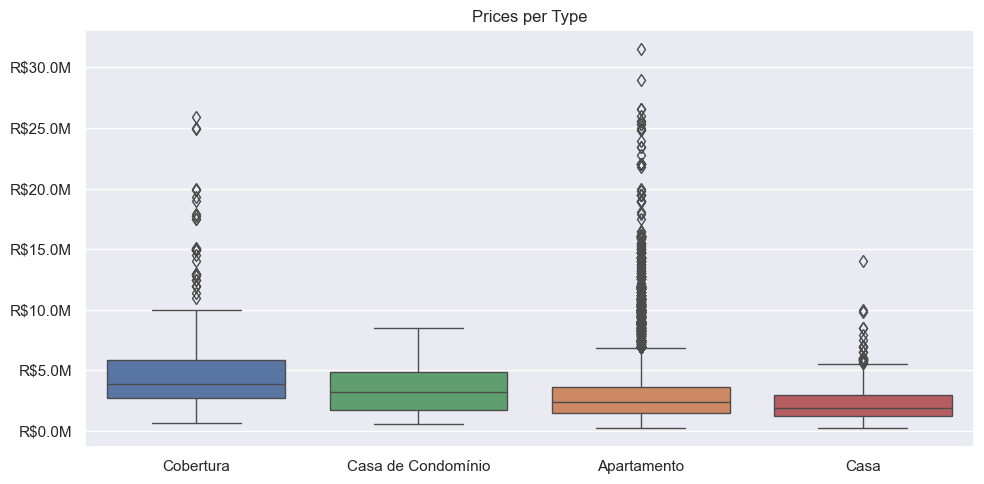

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(10,5), sharey=True)

distric_boxplot_order = df.groupby(by=Cols.Type.value) \
    .mean(1) \
	.sort_values(by=Cols.Price.value, ascending=False) \
	.index \
	.to_list()

sns.boxplot(data=df, x=Cols.Type.value, y=Cols.Price.value, ax=ax, order=distric_boxplot_order, hue=Cols.Type.value)

ax.set_title('Prices per Type')

ylabels = ['R${:,.1f}'.format(x) + 'M' for x in ax.get_yticks()/1_000_000]
ax.set_yticklabels(ylabels)

ax.set(xlabel=None, ylabel=None)

fig.tight_layout()

#### 2.2.2.1 Inference

1. Apartment is the most commom type
2. Cobertura is the most expensive both in average and maximum

### 2.2.3 Amenities

In [57]:
df_amenities.shape

(18260, 171)

In [58]:
# Add amenities to main dataframe
df_joint_amenities = pd.merge(left=df, right=df_amenities, left_index=True, right_index=True)

# Drop NA prices
df_joint_amenities = df_joint_amenities[~df_joint_amenities[Cols.Price.value].isna()]

In [59]:
# Summing and sorting amenities by most ocurring

cols_amenities = df_amenities.columns
sum_amenities = df_joint_amenities[cols_amenities].sum() \
    .sort_values(ascending=False) \
	.to_frame(name='Sum')

sum_amenities.head()

Sum
churrasqueira    4213
piscina          3580
salão_de_festas  3184
área_de_serviço  2909
academia         2770

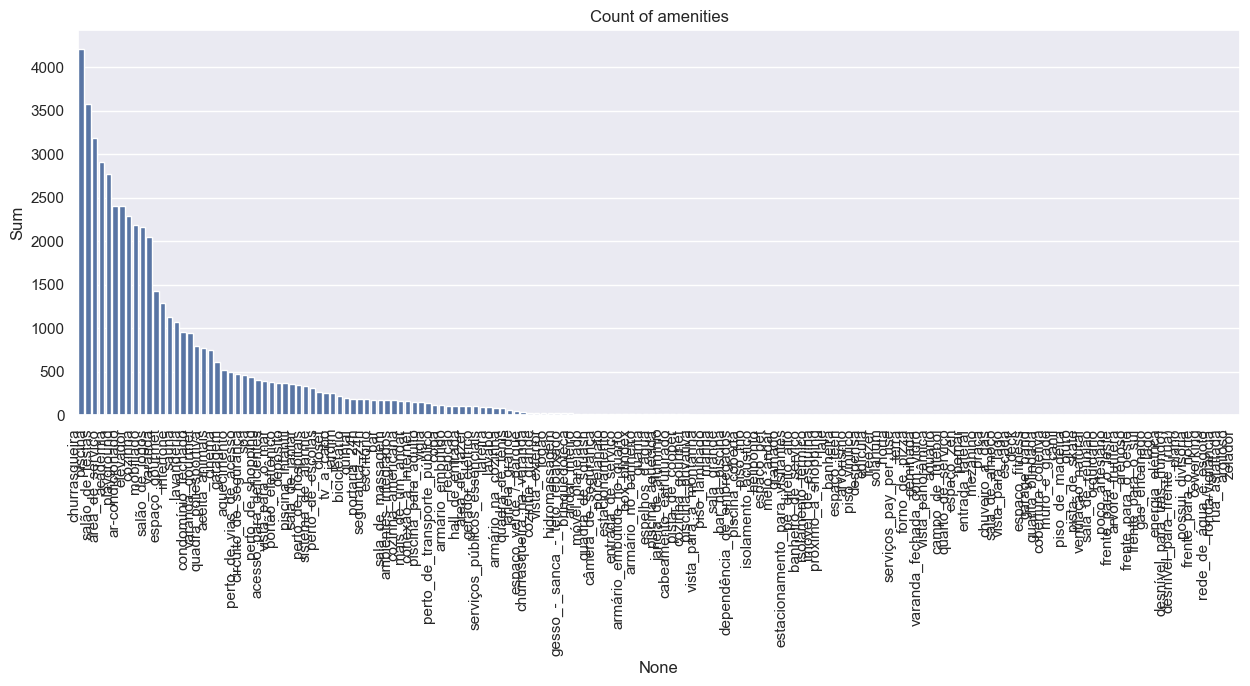

In [60]:
# Plotting all amenities sum to bar graph

fig, ax = plt.subplots(1, 1, figsize=(15,5), sharey=True)

sns.barplot(data=sum_amenities, x=sum_amenities.index, y='Sum', ax=ax)

ax.set_title('Count of amenities')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right');

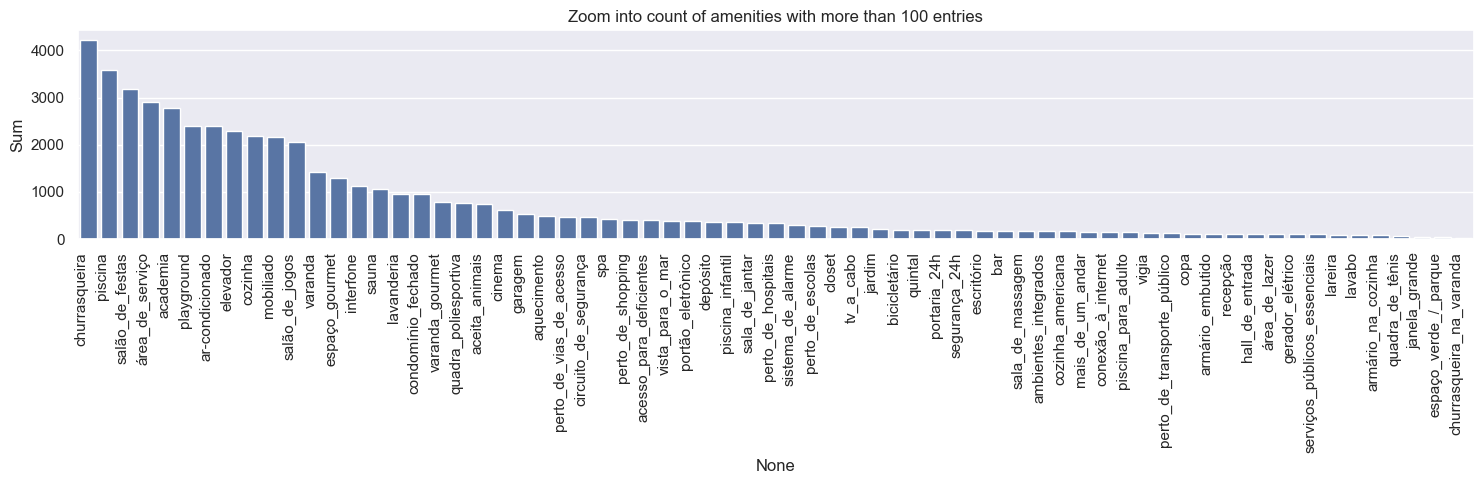

In [61]:
# Zooming in plot of all amenities sum to bar graph

fig, ax = plt.subplots(1, 1, figsize=(15,5), sharey=True)

sum_amenities_with_more_than_100 = sum_amenities[sum_amenities > 30].dropna()

sns.barplot(data=sum_amenities_with_more_than_100, x=sum_amenities_with_more_than_100.index, y='Sum', ax=ax)

ax.set_title('Zoom into count of amenities with more than 100 entries')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right');

fig.tight_layout()

In [62]:
# Apply A/B Testing

ab = []

with warnings.catch_warnings():
	warnings.simplefilter(action="ignore", category=UserWarning)
	
	for i_feature in sum_amenities_with_more_than_100.index.tolist():
		ab.append(extented_pandas.AB_Test(dataframe=df_joint_amenities, group = i_feature, target = Cols.Price.value));
		
ab = pd.concat(ab).set_index('Feature').sort_values('p-value', ascending=False);

ab.head(20)

Test Type      AB Hypothesis   p-value  \
Feature                                                                 
lavabo                    Non-Parametric  Fail to Reject H0  0.928383   
perto_de_vias_de_acesso   Non-Parametric  Fail to Reject H0  0.853039   
cozinha                   Non-Parametric  Fail to Reject H0  0.692373   
copa                      Non-Parametric  Fail to Reject H0  0.603816   
armário_embutido          Non-Parametric  Fail to Reject H0  0.603671   
garagem                   Non-Parametric  Fail to Reject H0  0.584119   
área_de_lazer             Non-Parametric  Fail to Reject H0  0.529397   
tv_a_cabo                 Non-Parametric  Fail to Reject H0  0.483065   
perto_de_shopping         Non-Parametric  Fail to Reject H0  0.421739   
churrasqueira_na_varanda  Non-Parametric  Fail to Reject H0  0.395548   
varanda_gourmet           Non-Parametric  Fail to Reject H0  0.298648   
bicicletário              Non-Parametric  Fail to Reject H0  0.286734   
sistema_de_alarme         Non-Parametric  Fail to Reject H0  0.240191   
conexão_à_internet        Non-Parametric  Fail to Reject H0  0.229299   
sala_de_jantar            Non-Parametric  Fail to Reject H0  0.219542   
mais_de_um_andar          Non-Parametric  Fail to Reject H0  0.163242   
perto_de_hospitais        Non-Parametric  Fail to Reject H0  0.160838   
espaço_gourmet            Non-Parametric  Fail to Reject H0  0.084163   
ar-condicionado           Non-Parametric  Fail to Reject H0  0.074001   
janela_grande             Non-Parametric          Reject H0  0.028849   

                                              Comment   GroupA_mean  \
Feature                                                               
lavabo                        A/B groups are similar!  3.181385e+06   
perto_de_vias_de_acesso       A/B groups are similar!  3.355218e+06   
cozinha                       A/B groups are similar!  3.221321e+06   
copa                          A/B groups are similar!  3.234198e+06   
armário_embutido              A/B groups are similar!  3.888478e+06   
garagem                       A/B groups are similar!  3.276387e+06   
área_de_lazer                 A/B groups are similar!  2.932480e+06   
tv_a_cabo                     A/B groups are similar!  3.088143e+06   
perto_de_shopping             A/B groups are similar!  3.609896e+06   
churrasqueira_na_varanda      A/B groups are similar!  3.341484e+06   
varanda_gourmet               A/B groups are similar!  3.172909e+06   
bicicletário                  A/B groups are similar!  3.022144e+06   
sistema_de_alarme             A/B groups are similar!  3.305842e+06   
conexão_à_internet            A/B groups are similar!  3.074372e+06   
sala_de_jantar                A/B groups are similar!  3.402628e+06   
mais_de_um_andar              A/B groups are similar!  3.262724e+06   
perto_de_hospitais            A/B groups are similar!  3.638500e+06   
espaço_gourmet                A/B groups are similar!  3.184243e+06   
ar-condicionado               A/B groups are similar!  3.291033e+06   
janela_grande             A/B groups are not similar!  2.353364e+06   

                           GroupB_mean  GroupA_median  GroupB_median  
Feature                                                               
lavabo                    3.291758e+06      2400000.0      2400000.0  
perto_de_vias_de_acesso   3.286380e+06      2400000.0      2400000.0  
cozinha                   3.317170e+06      2400000.0      2400000.0  
copa                      3.291358e+06      2500000.0      2400000.0  
armário_embutido          3.281863e+06      2500000.0      2400000.0  
garagem                   3.291528e+06      2380000.0      2400000.0  
área_de_lazer             3.295235e+06      2105000.0      2400000.0  
tv_a_cabo                 3.297372e+06      2300000.0      2400000.0  
perto_de_shopping         3.273052e+06      2500000.0      2400000.0  
churrasqueira_na_varanda  3.290318e+06      1899000.0      2400000.0  
varanda_g

In [63]:
ab.tail(20)

Test Type AB Hypothesis        p-value  \
Feature                                                             
elevador              Non-Parametric     Reject H0   2.079229e-14   
varanda               Non-Parametric     Reject H0   1.033489e-14   
salão_de_festas       Non-Parametric     Reject H0   1.014753e-17   
bar                   Non-Parametric     Reject H0   3.385276e-19   
closet                Non-Parametric     Reject H0   6.231250e-20   
vista_para_o_mar      Non-Parametric     Reject H0   2.992491e-20   
portão_eletrônico     Non-Parametric     Reject H0   1.970262e-20   
segurança_24h         Non-Parametric     Reject H0   4.464152e-22   
aceita_animais        Non-Parametric     Reject H0   1.172365e-24   
sala_de_massagem      Non-Parametric     Reject H0   4.382249e-29   
cozinha_americana     Non-Parametric     Reject H0   6.125064e-30   
churrasqueira         Non-Parametric     Reject H0   1.074245e-33   
spa                   Non-Parametric     Reject H0   2.419219e-36   
cinema                Non-Parametric     Reject H0   3.061116e-55   
sauna                 Non-Parametric     Reject H0   2.280673e-71   
quadra_poliesportiva  Non-Parametric     Reject H0   7.946645e-80   
academia              Non-Parametric     Reject H0   2.344689e-88   
salão_de_jogos        Non-Parametric     Reject H0   2.500380e-94   
piscina               Non-Parametric     Reject H0   1.200063e-97   
playground            Non-Parametric     Reject H0  3.482628e-118   

                                          Comment   GroupA_mean   GroupB_mean  \
Feature                                                                         
elevador              A/B groups are not similar!  2.947700e+06  3.431247e+06   
varanda               A/B groups are not similar!  2.755373e+06  3.409553e+06   
salão_de_festas       A/B groups are not similar!  3.452044e+06  3.180253e+06   
bar                   A/B groups are not similar!  5.140949e+06  3.248811e+06   
closet                A/B groups are not similar!  4.971703e+06  3.232915e+06   
vista_para_o_mar      A/B groups are not similar!  4.204268e+06  3.243254e+06   
portão_eletrônico     A/B groups are not similar!  2.361162e+06  3.337156e+06   
segurança_24h         A/B groups are not similar!  5.288866e+06  3.241475e+06   
aceita_animais        A/B groups are not similar!  2.643675e+06  3.359272e+06   
sala_de_massagem      A/B groups are not similar!  5.602849e+06  3.238399e+06   
cozinha_americana     A/B groups are not similar!  1.548832e+06  3.327693e+06   
churrasqueira         A/B groups are not similar!  3.533593e+06  3.008797e+06   
spa                   A/B groups are not similar!  4.509538e+06  3.218988e+06   
cinema                A/B groups are not similar!  4.778745e+06  3.163535e+06   
sauna                 A/B groups are not similar!  4.438623e+06  3.108885e+06   
quadra_poliesportiva  A/B groups are not similar!  5.173503e+06  3.084199e+06   
academia              A/B groups are not similar!  3.882001e+06  2.967874e+06   
salão_de_jogos        A/B groups are not similar!  4.020575e+06  3.032225e+06   
piscina               A/B groups are not similar!  3.740230e+06  2.913304e+06   
playground            A/B groups are not similar!  4.004223e+06  2.975737e+06   

                      GroupA_median  GroupB_median  
Feature                                             
elevador                  2200000.0      2500000.0  
varanda                   2100000.0      2500000.0  
salão_de_festas           2600000.0      2290000.0  
bar                       3800000.0      2380000.0  
closet                    3500000.0      2380000.0  
vista_para_o_mar          3390000.0      2361672.5  
portão_eletrônico         1650000.0      2450000.0  
segurança_24h             3970000.0      2380000.0  
aceita_animais            1800000.0      2500000.0  
sala_de_massagem          4300000.0      2380000.0  
cozinha_americana         1300000.0      2450000.0  
churrasqueira             2590000.0 

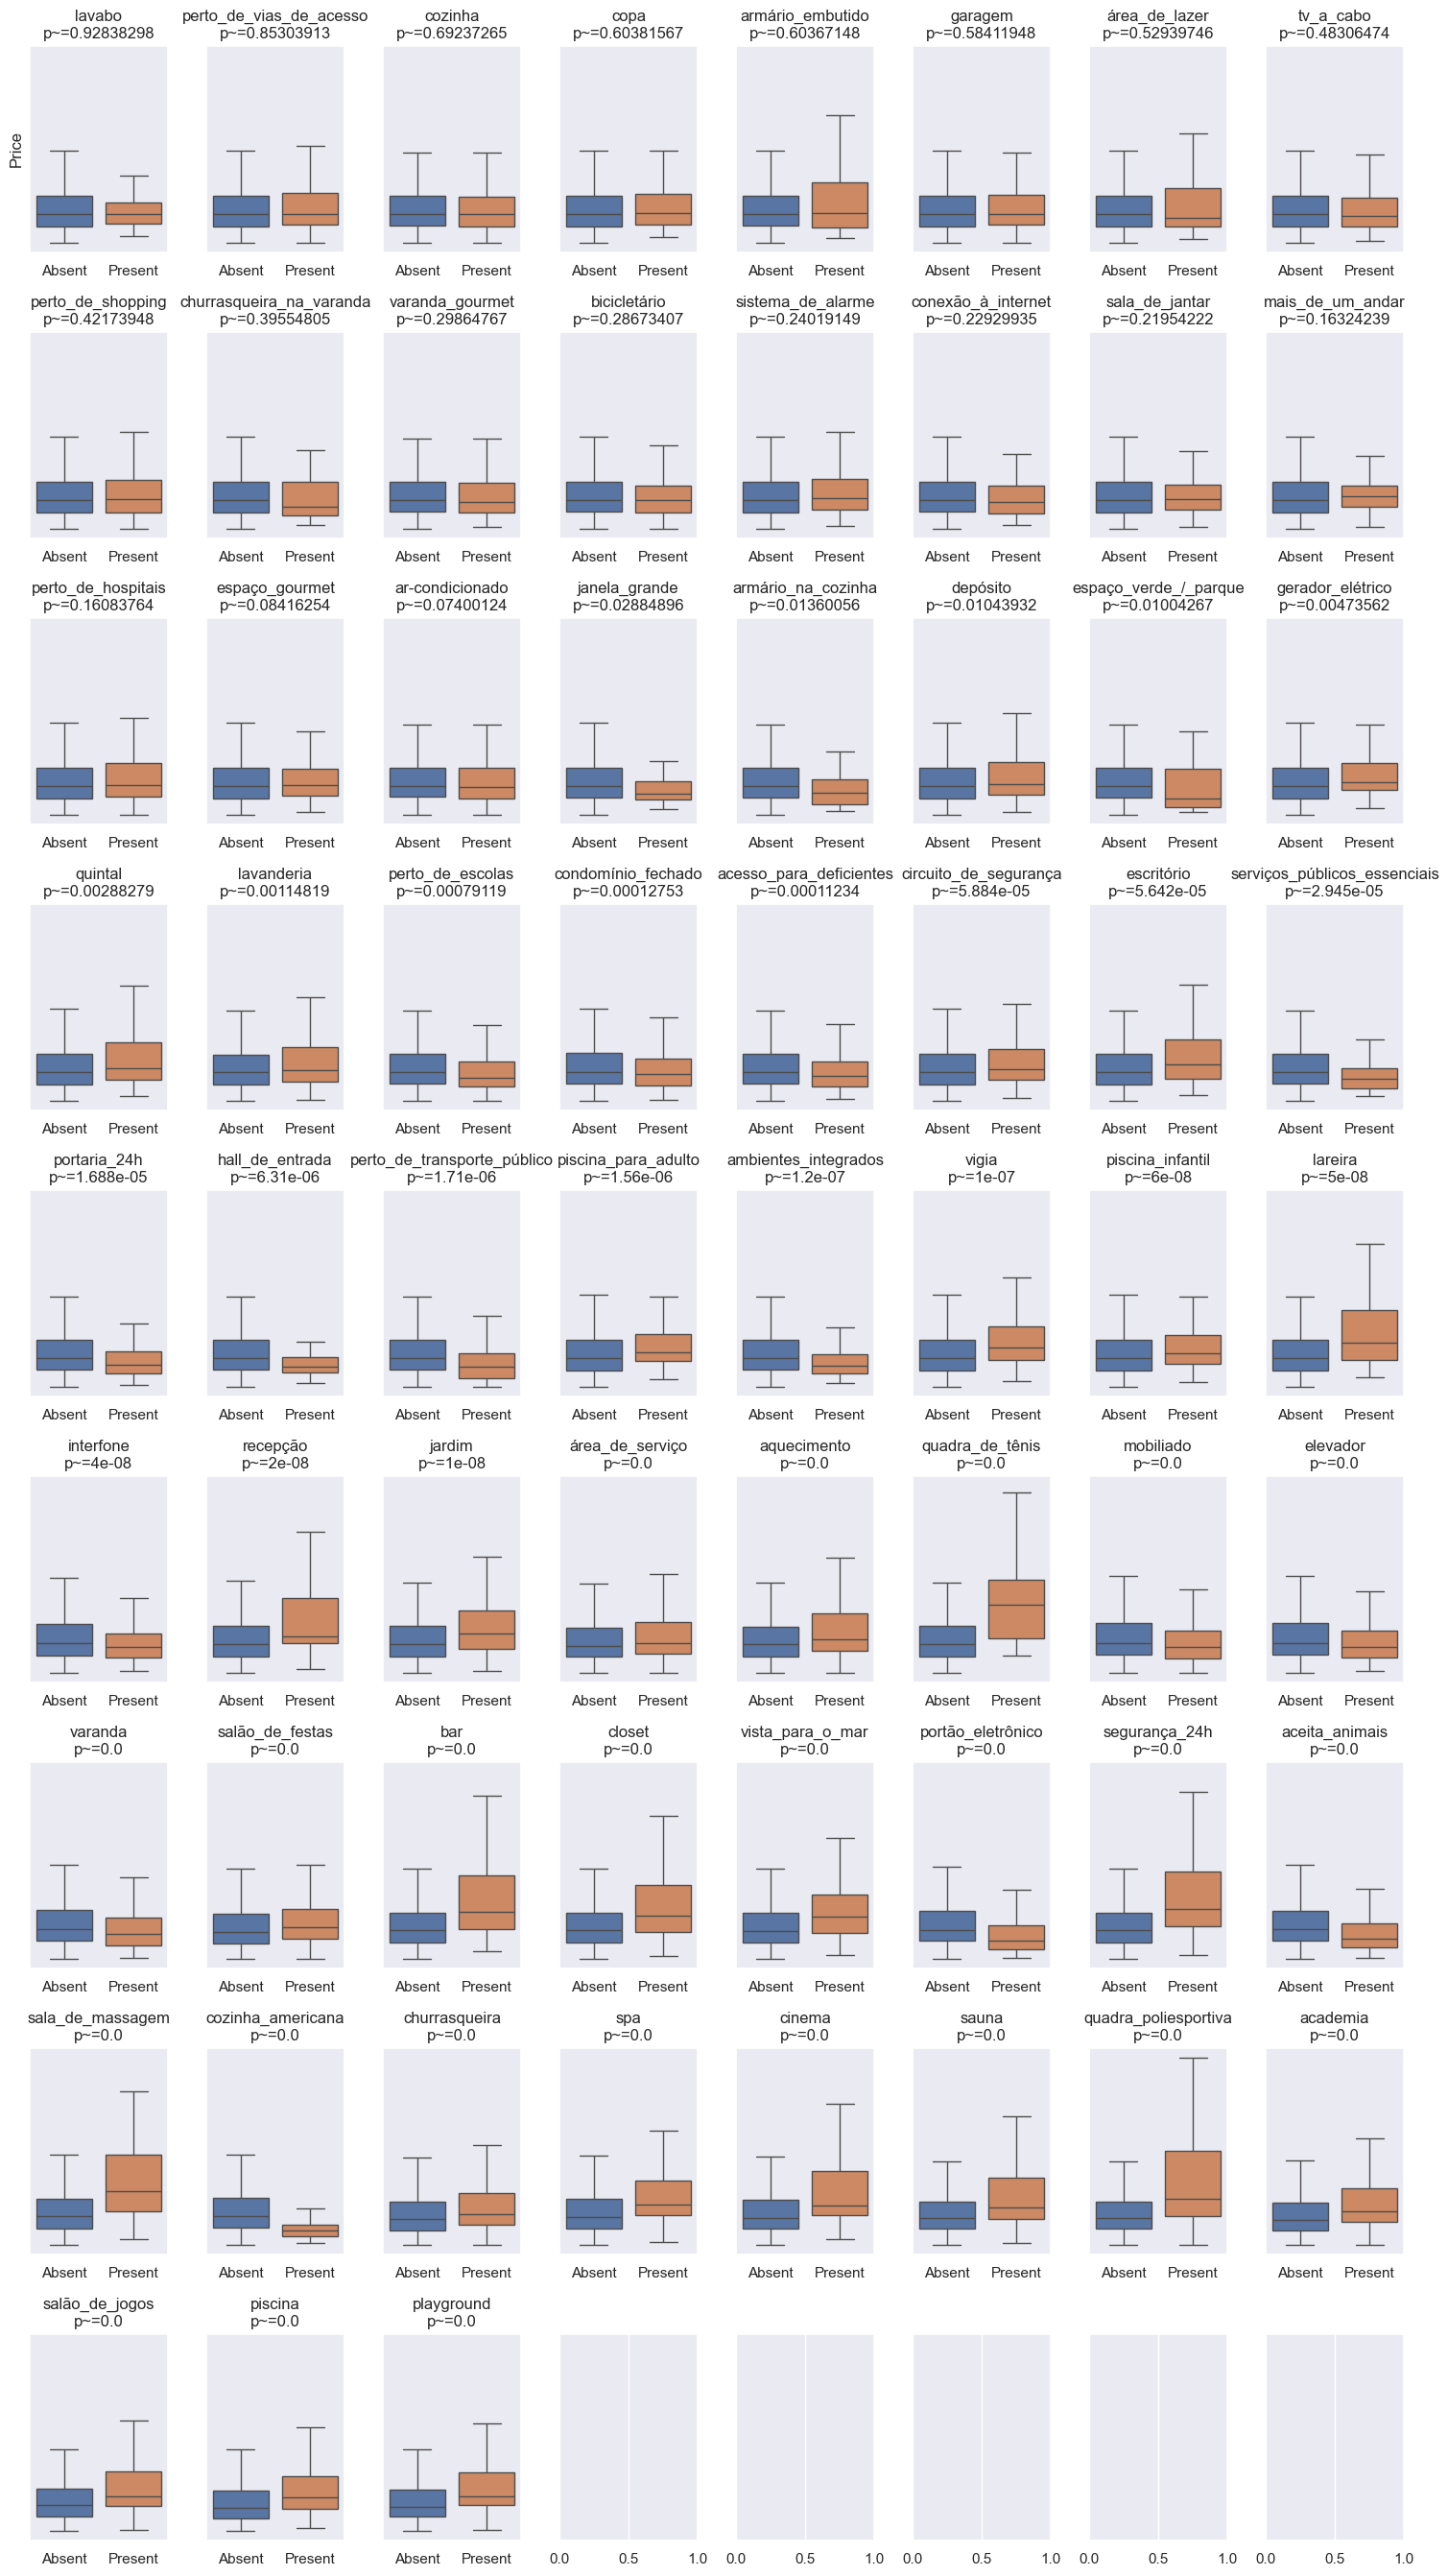

In [74]:
# Boxplots of the amenities features

amenities_to_graph = ab.index.to_list()

num_cols = 8
num_rows = int(np.ceil(len(amenities_to_graph) / num_cols))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15,3*num_rows), sharey=True)
axs = iter(axs.reshape(1, -1)[0])

for i_ax, col in enumerate(amenities_to_graph):
	ax = next(axs)
	sns.boxplot(data=df_joint_amenities, x=col, y=Cols.Price.value, ax=ax, showfliers=False, hue=col, legend=False)
	
	ax.set_title(f'{col}\np~={np.round(ab.loc[col, "p-value"], 8)}')
	ax.set(xlabel=None,
		   xticks=[0,1],
		   xticklabels=['Absent', 'Present'],
		   yticks=[],
		   # Price label only in the leftmost graph
		   ylabel='Price' if i_ax % num_cols == 0 else None
	)
	
	ax.relim()

fig.tight_layout()

The graph above shows us the difference in price for every ammenity item in the appartments, we'll be using the ones with the lowest p-values (below 0.05), this means that we are 95% confident that the groups with and without this feature are different, and will yield better results in our models:

In [65]:
# Get list of relevant amenities thorugh A/B testing columns and append to DF
def set_amenities_columns(df_main: pd.DataFrame, df_in_amenities: pd.DataFrame) -> pd.DataFrame:
	# Reduce amenities Dataframe to only columns with more than 100 positive values, as to not overfit
	sum_amenities = df_in_amenities.sum() \
		.sort_values(ascending=False) \
		.to_frame(name='Sum')

	relevant_columns = sum_amenities[sum_amenities > 30].dropna().index
	df_in_amenities = df_in_amenities[relevant_columns]

	# Add amenities to main dataframe
	df_joint_amenities = pd.merge(left=df_main, right=df_in_amenities, left_index=True, right_index=True)

	# Drop NA prices
	df_joint_amenities = df_joint_amenities[~df_joint_amenities[Cols.Price.value].isna()]

	# Apply A/B Testing
	ab = []

	with warnings.catch_warnings():
		warnings.simplefilter(action="ignore", category=UserWarning)
		
		for i in sum_amenities_with_more_than_100.index.tolist():
			ab.append(extented_pandas.AB_Test(dataframe=df_joint_amenities, group = i, target = Cols.Price.value));
		
	ab = pd.concat(ab).set_index('Feature').sort_values('p-value', ascending=False);

	# Get list of features below the 95% confidence level
	irrelevant_features = ab[ab['p-value'] > 0.05].index

	# Drop all columns in this confidence level
	return pd.merge(left=df_main, right=df_in_amenities, left_index=True, right_index=True).drop(columns=irrelevant_features)

df = set_amenities_columns(df, df_amenities)
df.head()

title  \
1    Cobertura com 3 Quartos à venda, 240m² - Centro   
2  Apartamento com 4 Quartos à venda, 167m² - Centro   
3  Apartamento com 4 Quartos à venda, 149m² - Centro   
4  Apartamento com 4 Quartos à venda, 129m² - Centro   
5  Apartamento com 3 Quartos à venda, 118m² - Centro   

                                              adress  condominium_fee  \
1          Rua 901 - Centro, Balneário Camboriú - SC              NaN   
2         Rua 2950 - Centro, Balneário Camboriú - SC              NaN   
3         Rua 3140 - Centro, Balneário Camboriú - SC              NaN   
4  Avenida do Estado Dalmo Vieira - Centro, Balne...              NaN   
5         Rua 1901 - Centro, Balneário Camboriú - SC              NaN   

       price   area  bedrooms  garage_spaces  bathrooms   test         tipo  \
1  4200000.0  240.0       3.0            2.0        1.0  False    Cobertura   
2  3418419.0  167.0       4.0            3.0        2.0  False  Apartamento   
3  2400000.0  149.0       4.0            2.0        1.0  False  Apartamento   
4  2751000.0  129.0       4.0            2.0        2.0  False  Apartamento   
5  2398000.0  118.0       3.0            2.0        1.0  False  Apartamento   

   bairro  churrasqueira  salão_de_festas  piscina  área_de_serviço  academia  \
1  Centro              0                1        0                0         1   
2  Centro              0                1        0                0         1   
3  Centro              0                1        0                0         1   
4  Centro              0                1        0                0         0   
5  Centro              0                1        0                0         1   

   elevador  playground  mobiliado  salão_de_jogos  varanda  interfone  \
1         0           1          0               0        0          0   
2         0           1          0               0        0          0   
3         0           1          0               0        0          0   
4         0           1          0               0        0          0   
5         0           1          0               0        0          0   

   aceita_animais  sauna  condomínio_fechado  lavanderia  \
1               0      0                   0           0   
2               0      0                   0           0   
3               0      0                   0           0   
4               0      0                   0           0   
5               0      0                   0           0   

   quadra_poliesportiva  cinema  portão_eletrônico  acesso_para_deficientes  \
1                     0       0                  0                        0   
2                     0       0                  0                        0   
3                     0       0                  0                        0   
4                     0       0                  0                        0   
5                     0       0                  0                        0   

   circuito_de_segurança  aquecimento  vista_para_o_mar  spa  \
1                      0            0                 0    0   
2                      0            0                 0    0   
3                      1            0                 0    0   
4                      0            0                 0    0   
5                      0            0                 0    0   

   piscina_infantil  closet  segurança_24h  depósito  jardim  portaria_24h  \
1                 0       0              0         0       0             0   
2                 0       0              0         0       1             0   
3                 0       0              0         0       1             0   
4                 0       0              0         0       0             0   
5                 0       0              0         0       0             0   

   cozinha_americana  perto_de_escolas  ambientes_integrados  quintal  vigia  \
1                  0                 0                     0        0      0   
2             

# Data Transformation

## Categorical Data

Since our models can't deal with text data, we'll transform the categorical columns into their own "on/off" columns and drop the title and address as they have already been transformed into other colunns:

In [66]:
# One hot encoding categorical variables
@make_pipeline
def set_dummies_for_categoricals(df_in: pd.DataFrame) -> pd.DataFrame:
	cols_prefixs = {
		Cols.Type.value: 'type_',
		Cols.District.value: 'district_'
	}

	if set(cols_prefixs.keys()).issubset(df_in.columns): # Checks if columns still exist
		return pd.get_dummies(data=df_in, columns=cols_prefixs.keys(), prefix=cols_prefixs, drop_first=True)
	else:
		return df_in

	
df = pipeline_functions_dict['set_dummies_for_categoricals'](df)
df.head()

title  \
1    Cobertura com 3 Quartos à venda, 240m² - Centro   
2  Apartamento com 4 Quartos à venda, 167m² - Centro   
3  Apartamento com 4 Quartos à venda, 149m² - Centro   
4  Apartamento com 4 Quartos à venda, 129m² - Centro   
5  Apartamento com 3 Quartos à venda, 118m² - Centro   

                                              adress  condominium_fee  \
1          Rua 901 - Centro, Balneário Camboriú - SC              NaN   
2         Rua 2950 - Centro, Balneário Camboriú - SC              NaN   
3         Rua 3140 - Centro, Balneário Camboriú - SC              NaN   
4  Avenida do Estado Dalmo Vieira - Centro, Balne...              NaN   
5         Rua 1901 - Centro, Balneário Camboriú - SC              NaN   

       price   area  bedrooms  garage_spaces  bathrooms   test  churrasqueira  \
1  4200000.0  240.0       3.0            2.0        1.0  False              0   
2  3418419.0  167.0       4.0            3.0        2.0  False              0   
3  2400000.0  149.0       4.0            2.0        1.0  False              0   
4  2751000.0  129.0       4.0            2.0        2.0  False              0   
5  2398000.0  118.0       3.0            2.0        1.0  False              0   

   salão_de_festas  piscina  área_de_serviço  academia  elevador  playground  \
1                1        0                0         1         0           1   
2                1        0                0         1         0           1   
3                1        0                0         1         0           1   
4                1        0                0         0         0           1   
5                1        0                0         1         0           1   

   mobiliado  salão_de_jogos  varanda  interfone  aceita_animais  sauna  \
1          0               0        0          0               0      0   
2          0               0        0          0               0      0   
3          0               0        0          0               0      0   
4          0               0        0          0               0      0   
5          0               0        0          0               0      0   

   condomínio_fechado  lavanderia  quadra_poliesportiva  cinema  \
1                   0           0                     0       0   
2                   0           0                     0       0   
3                   0           0                     0       0   
4                   0           0                     0       0   
5                   0           0                     0       0   

   portão_eletrônico  acesso_para_deficientes  circuito_de_segurança  \
1                  0                        0                      0   
2                  0                        0                      0   
3                  0                        0                      1   
4                  0                        0                      0   
5                  0                        0                      0   

   aquecimento  vista_para_o_mar  spa  piscina_infantil  closet  \
1            0                 0    0                 0       0   
2            0                 0    0                 0       0   
3            0                 0    0                 0       0   
4            0                 0    0                 0       0   
5            0                 0    0                 0       0   

   segurança_24h  depósito  jardim  portaria_24h  cozinha_americana  \
1              0         0       0             0                  0   
2              0         0       1             0                  0   
3              0         0       1             0                  0   
4              0         0       0             0                  0   
5              0         0       0             0                  0   

   perto_de_escolas  ambientes_integrados  quintal  vigia  sala_de_massagem  \
1                 0                     0        0      0                 0   
2                 0         

In [67]:
# Drop title, address columns
@make_pipeline
def drop_title_and_address_columns(df_in:pd.DataFrame) -> pd.DataFrame:
    return df_in.drop(columns=[Cols.Address.value, Cols.Title.value])

df = pipeline_functions_dict['drop_title_and_address_columns'](df)
df

condominium_fee      price   area  bedrooms  garage_spaces  bathrooms  \
1                  NaN  4200000.0  240.0       3.0            2.0        1.0   
2                  NaN  3418419.0  167.0       4.0            3.0        2.0   
3                  NaN  2400000.0  149.0       4.0            2.0        1.0   
4                  NaN  2751000.0  129.0       4.0            2.0        2.0   
5                  NaN  2398000.0  118.0       3.0            2.0        1.0   
...                ...        ...    ...       ...            ...        ...   
15603              NaN        NaN  249.0       4.0            3.0        4.0   
15604              NaN        NaN  150.0       3.0            2.0        3.0   
15605              NaN        NaN  140.0       4.0            2.0        2.0   
15606              NaN        NaN  275.0       3.0            2.0        3.0   
15607              NaN        NaN  180.0       4.0            3.0        4.0   

        test  churrasqueira  salão_de_festas  piscina  área_de_serviço  \
1      False              0                1        0                0   
2      False              0                1        0                0   
3      False              0                1        0                0   
4      False              0                1        0                0   
5      False              0                1        0                0   
...      ...            ...              ...      ...              ...   
15603   True              0                0        0                0   
15604   True              0                0        0                0   
15605   True              0                0        0                0   
15606   True              0                0        0                0   
15607   True              0                1        0                1   

       academia  elevador  playground  mobiliado  salão_de_jogos  varanda  \
1             1         0           1          0               0        0   
2             1         0           1          0               0        0   
3             1         0           1          0               0        0   
4             0         0           1          0               0        0   
5             1         0           1          0               0        0   
...         ...       ...         ...        ...             ...      ...   
15603         0         0           0          0               0        0   
15604         0         0           0          0               0        0   
15605         0         0           0          0               0        0   
15606         0         0           0          0               0        0   
15607         1         0           1          0               1        0   

       interfone  aceita_animais  sauna  condomínio_fechado  lavanderia  \
1              0               0      0                   0           0   
2              0               0      0                   0           0   
3              0               0      0                   0           0   
4              0               0      0                   0           0   
5              0               0      0                   0           0   
...          ...             ...    ...                 ...         ...   
15603          0               0      0                   0           0   
15604          0               0      0                   0           0   
15605          0               0      0                   0           0   
15606          0               0      0                   0           0   
15607          0               0      0                   0           0   

       quadra_poliesportiva  cinema  portão_eletrônico  \
1                         0       0                  0   
2                         0       0                  0   
3                         0       0                  0   
4                         0       0                  0   
5                         0       0      

In [68]:
# Drop condominium fee
@make_pipeline
def drop_condominium_fee(df_in:pd.DataFrame) -> pd.DataFrame:
    return df_in.drop(columns=[Cols.Condominium.value])

df = pipeline_functions_dict['drop_condominium_fee'](df)
df

price   area  bedrooms  garage_spaces  bathrooms   test  \
1      4200000.0  240.0       3.0            2.0        1.0  False   
2      3418419.0  167.0       4.0            3.0        2.0  False   
3      2400000.0  149.0       4.0            2.0        1.0  False   
4      2751000.0  129.0       4.0            2.0        2.0  False   
5      2398000.0  118.0       3.0            2.0        1.0  False   
...          ...    ...       ...            ...        ...    ...   
15603        NaN  249.0       4.0            3.0        4.0   True   
15604        NaN  150.0       3.0            2.0        3.0   True   
15605        NaN  140.0       4.0            2.0        2.0   True   
15606        NaN  275.0       3.0            2.0        3.0   True   
15607        NaN  180.0       4.0            3.0        4.0   True   

       churrasqueira  salão_de_festas  piscina  área_de_serviço  academia  \
1                  0                1        0                0         1   
2                  0                1        0                0         1   
3                  0                1        0                0         1   
4                  0                1        0                0         0   
5                  0                1        0                0         1   
...              ...              ...      ...              ...       ...   
15603              0                0        0                0         0   
15604              0                0        0                0         0   
15605              0                0        0                0         0   
15606              0                0        0                0         0   
15607              0                1        0                1         1   

       elevador  playground  mobiliado  salão_de_jogos  varanda  interfone  \
1             0           1          0               0        0          0   
2             0           1          0               0        0          0   
3             0           1          0               0        0          0   
4             0           1          0               0        0          0   
5             0           1          0               0        0          0   
...         ...         ...        ...             ...      ...        ...   
15603         0           0          0               0        0          0   
15604         0           0          0               0        0          0   
15605         0           0          0               0        0          0   
15606         0           0          0               0        0          0   
15607         0           1          0               1        0          0   

       aceita_animais  sauna  condomínio_fechado  lavanderia  \
1                   0      0                   0           0   
2                   0      0                   0           0   
3                   0      0                   0           0   
4                   0      0                   0           0   
5                   0      0                   0           0   
...               ...    ...                 ...         ...   
15603               0      0                   0           0   
15604               0      0                   0           0   
15605               0      0                   0           0   
15606               0      0                   0           0   
15607               0      0                   0           0   

       quadra_poliesportiva  cinema  portão_eletrônico  \
1                         0       0                  0   
2                         0       0                  0   
3                         0       0                  0   
4                         0       0                  0   
5                         0       0                  0   
...                     ...     ...                ...   
15603                     0       0                  0   
15604                     0       0                  0   
15605            

## Numerical Data

In [69]:
# Transform price and area to logs
@make_pipeline
def log_price_and_area(df_in: pd.DataFrame) -> pd.DataFrame:
    df_in.loc[:, [Cols.Price.value, Cols.Area.value]] = np.log1p(df_in.loc[:, [Cols.Price.value, Cols.Area.value]])
    return df_in

df = pipeline_functions_dict['log_price_and_area'](df)

### Splitting test and train data

In [70]:
X_test = df[df[Cols.Test.value] == True].drop(columns=[Cols.Test.value, Cols.Price.value])
X_train = df[df[Cols.Test.value] == False].drop(columns=[Cols.Test.value, Cols.Price.value])
y_train = df[df[Cols.Test.value] == False][Cols.Price.value].copy()
y_test_log = np.log1p(y_test[X_test.index].copy())

### Scaling the data

In [71]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer()
numerical_features_to_scale = ['area', 'bedrooms', 'garage_spaces', 'bathrooms']
scaler.fit(X_train[numerical_features_to_scale])
X_train[numerical_features_to_scale] = scaler.transform(X_train[numerical_features_to_scale])
X_test[numerical_features_to_scale] = scaler.transform(X_test[numerical_features_to_scale])

In [72]:
X_train.head(5)

area  bedrooms  garage_spaces  bathrooms  churrasqueira  \
1  1.044620 -0.320380      -0.328520  -1.647996              0   
2  0.256247  1.004085       0.608302  -0.917911              0   
3  0.003274  1.004085      -0.328520  -1.647996              0   
4 -0.320015  1.004085      -0.328520  -0.917911              0   
5 -0.521970 -0.320380      -0.328520  -1.647996              0   

   salão_de_festas  piscina  área_de_serviço  academia  elevador  playground  \
1                1        0                0         1         0           1   
2                1        0                0         1         0           1   
3                1        0                0         1         0           1   
4                1        0                0         0         0           1   
5                1        0                0         1         0           1   

   mobiliado  salão_de_jogos  varanda  interfone  aceita_animais  sauna  \
1          0               0        0          0               0      0   
2          0               0        0          0               0      0   
3          0               0        0          0               0      0   
4          0               0        0          0               0      0   
5          0               0        0          0               0      0   

   condomínio_fechado  lavanderia  quadra_poliesportiva  cinema  \
1                   0           0                     0       0   
2                   0           0                     0       0   
3                   0           0                     0       0   
4                   0           0                     0       0   
5                   0           0                     0       0   

   portão_eletrônico  acesso_para_deficientes  circuito_de_segurança  \
1                  0                        0                      0   
2                  0                        0                      0   
3                  0                        0                      1   
4                  0                        0                      0   
5                  0                        0                      0   

   aquecimento  vista_para_o_mar  spa  piscina_infantil  closet  \
1            0                 0    0                 0       0   
2            0                 0    0                 0       0   
3            0                 0    0                 0       0   
4            0                 0    0                 0       0   
5            0                 0    0                 0       0   

   segurança_24h  depósito  jardim  portaria_24h  cozinha_americana  \
1              0         0       0             0                  0   
2              0         0       1             0                  0   
3              0         0       1             0                  0   
4              0         0       0             0                  0   
5              0         0       0             0                  0   

   perto_de_escolas  ambientes_integrados  quintal  vigia  sala_de_massagem  \
1                 0                     0        0      0                 0   
2                 0                     0        0      0                 0   
3                 0                     0        0      0                 0   
4                 0                     0        0      0                 0   
5                 0                     0        0      0                 0   

   escritório  bar  gerador_elétrico  piscina_para_adulto  lareira  \
1           0    0                 0                    0        0   
2           0    0                 0                    0        0   
3           0    0                 0                    0        0   
4           0    0                 0                    0        0   
5           0    0                 0                    0        0   

   armário_na_cozinha  hall_de_entrada  recepção  perto_de_transporte_público  \
1                   0              

In [73]:
X_test.head(5)

area  bedrooms  garage_spaces  bathrooms  churrasqueira  \
9657 -0.251183 -0.320380      -0.328520  -0.917911              0   
9658  0.256247  1.004085      -0.328520  -1.647996              0   
9660 -0.521970 -1.459787      -1.550413  -1.647996              0   
9661 -0.640954 -0.320380      -0.328520  -0.202669              0   
9662  0.018180 -0.320380      -0.328520  -0.202669              1   

      salão_de_festas  piscina  área_de_serviço  academia  elevador  \
9657                1        0                0         1         0   
9658                1        0                0         0         0   
9660                1        0                0         1         0   
9661                0        1                1         0         0   
9662                1        0                0         1         0   

      playground  mobiliado  salão_de_jogos  varanda  interfone  \
9657           1          0               0        0          0   
9658           0          0               1        0          0   
9660           1          0               0        0          0   
9661           0          1               0        0          0   
9662           0          0               1        0          0   

      aceita_animais  sauna  condomínio_fechado  lavanderia  \
9657               0      0                   0           0   
9658               0      0                   0           0   
9660               0      0                   0           0   
9661               0      0                   0           0   
9662               0      0                   1           0   

      quadra_poliesportiva  cinema  portão_eletrônico  \
9657                     0       0                  0   
9658                     0       0                  0   
9660                     0       0                  0   
9661                     0       0                  0   
9662                     0       0                  1   

      acesso_para_deficientes  circuito_de_segurança  aquecimento  \
9657                        0                      0            0   
9658                        0                      0            0   
9660                        0                      0            0   
9661                        0                      0            0   
9662                        0                      0            0   

      vista_para_o_mar  spa  piscina_infantil  closet  segurança_24h  \
9657                 0    0                 0       0              0   
9658                 0    1                 0       0              0   
9660                 0    0                 0       0              0   
9661                 0    0                 0       0              0   
9662                 0    0                 0       0              0   

      depósito  jardim  portaria_24h  cozinha_americana  perto_de_escolas  \
9657         0       0             0                  0                 0   
9658         0       0             0                  0                 0   
9660         0       0             0                  0                 0   
9661         0       0             0                  0                 1   
9662         0       0             1                  0                 0   

      ambientes_integrados  quintal  vigia  sala_de_massagem  escritório  bar  \
9657                     0        0      0                 0           0    0   
9658                     0        0      0                 0           0    0   
9660                     0        0      0                 0           0    0   
9661                     1        0      0                 0           0    0   
9662                     0        0      0                 0           0    0   

      gerador_elétrico  piscina_para_adulto  lareira  armário_na_cozinha  \
9657                 0                    0        0                   0   
9658                 0                    0        0                   0   
9660             

# Model Selection

## Linear Regressions

Best regressor: Ridge(alpha=1, max_iter=10000)


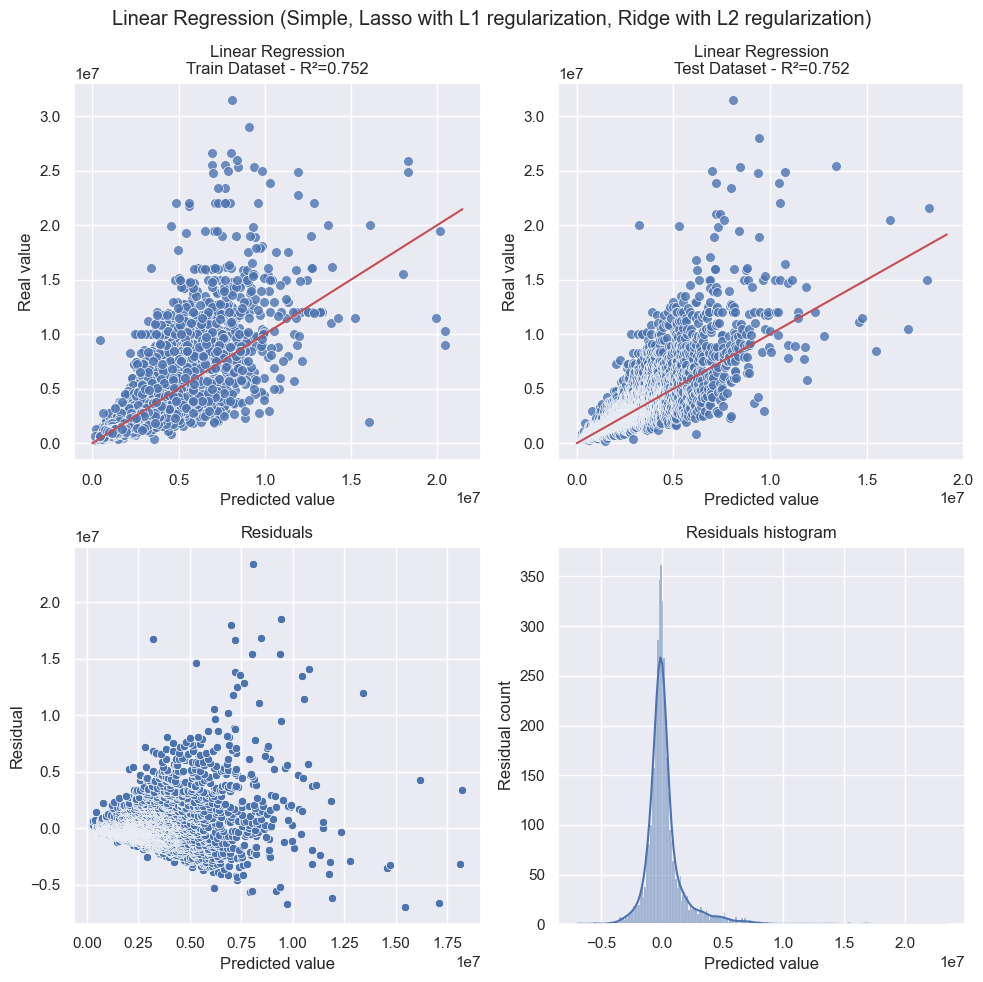

In [116]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Class to hold the best linear model
class class_best_regressor:
	score = 0
	model = LinearRegression().fit(X_train, y_train)

	def check_regressor(self, regressor):
		new_score = regressor.score(X_test, y_test_log)
		if(new_score > self.score):
			self.score = new_score
			self.model = regressor

best_regressor = class_best_regressor()

# Simple linear regression
linreg = LinearRegression().fit(X_train, y_train)

best_regressor.check_regressor(linreg)

# Lasso model

for alpha in [0.00001, 0.001, 0.005, 0.05, 0.5, 1]:
	linlasso = Lasso(alpha=alpha, max_iter = 100_000).fit(X_train, y_train)
	best_regressor.check_regressor(linlasso)

# Ridge Model

for alpha in [0.00001, 0.001, 0.005, 0.05, 0.5, 1]:
	linridge = Ridge(alpha=alpha, max_iter = 10000).fit(X_train, y_train)
	best_regressor.check_regressor(linridge)

# Print best linear model

print(f'Best regressor: {best_regressor.model}')

# Plot best model

fig, axs =  plt.subplots(2,2, figsize=(10,10))
fig.suptitle('Linear Regression (Simple, Lasso with L1 regularization, Ridge with L2 regularization)')
axs = iter(axs.reshape(1, -1)[0])

# Plotting of the train dataset
ax = next(axs)
y_hat_train = pd.Series(best_regressor.model.predict(X_train), index=y_train.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat_train), y=np.expm1(y_train), marker= 'o', s=50, alpha=0.8, ax=ax)
ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Linear Regression\nTrain Dataset - R²={best_regressor.model.score(X_train, y_train):.3f}'
)

extented_pandas.draw_1_1_line(ax)

# Plotting of the test dataset
ax = next(axs)
y_hat = pd.Series(best_regressor.model.predict(X_test), index=X_test.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat), y=np.expm1(y_test_log.loc[y_hat.index]), marker= 'o', s=50, alpha=0.8, ax=ax)
ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Linear Regression\nTest Dataset - R²={best_regressor.model.score(X_test, y_test_log):.3f}'
)

extented_pandas.draw_1_1_line(ax)

# Plotting of residuals Scatterplot

ax = next(axs)
sorted_y_test = y_test_log.sort_values()
sorted_x_test = X_test.reindex(sorted_y_test.index)
predicted_values = np.expm1(best_regressor.model.predict(sorted_x_test))
residuals = (np.expm1(sorted_y_test) - predicted_values)
sns.scatterplot(x=predicted_values, y=residuals, ax=ax)
ax.set(ylabel='Residual',
       xlabel='Predicted value',
	   title=f'Residuals'
);

# Plotting of residuals Histogram

ax = next(axs)
sns.histplot(data=residuals, ax=ax, kde=True)
ax.set(ylabel='Residual count',
       xlabel='Predicted value',
	   title=f'Residuals histogram'
);

fig.tight_layout()

# Random Forest Regressor

In [118]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()

forest.fit(X_train, y_train);

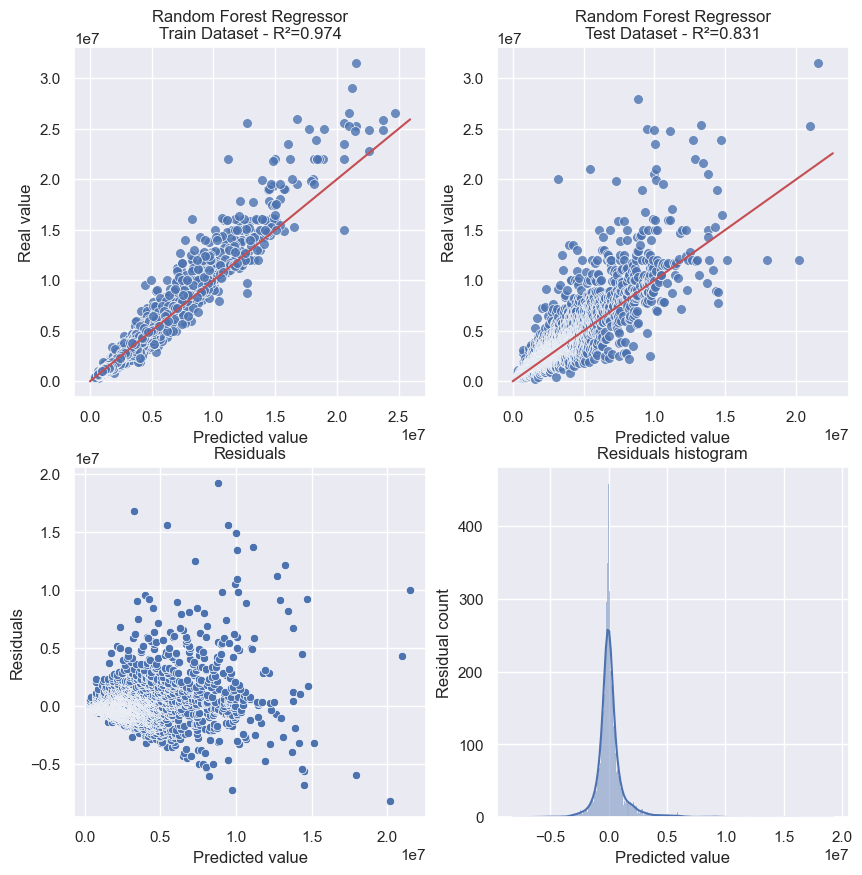

In [85]:
# Plot forest model

fig, axs =  plt.subplots(2,2, figsize=(10,10))
axs = iter(axs.reshape(1, -1)[0])

# Plotting of the train dataset
ax = next(axs)
y_hat_train = pd.Series(forest.predict(X_train), index=y_train.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat_train), y=np.expm1(y_train), marker= 'o', s=50, alpha=0.8, ax=ax)
ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Random Forest Regressor\nTrain Dataset - R²={forest.score(X_train, y_train):.3f}'
)

extented_pandas.draw_1_1_line(ax)

# Plotting of the test dataset
ax = next(axs)
y_hat = pd.Series(forest.predict(X_test), index=X_test.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat), y=np.expm1(y_test_log.loc[y_hat.index]), marker= 'o', s=50, alpha=0.8, ax=ax)
ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Random Forest Regressor\nTest Dataset - R²={forest.score(X_test, y_test_log):.3f}'
)

extented_pandas.draw_1_1_line(ax)

# Plotting of residuals

ax = next(axs)
sorted_y_test = y_test_log.sort_values()
sorted_x_test = X_test.reindex(sorted_y_test.index)
predicted_values = np.expm1(forest.predict(sorted_x_test))
residuals = (np.expm1(sorted_y_test) - predicted_values)
sns.scatterplot(x=predicted_values, y=residuals, ax=ax)
ax.set(ylabel='Residuals',
       xlabel='Predicted value',
	   title=f'Residuals'
);

# Plotting of residuals Histogram

ax = next(axs)
sns.histplot(data=residuals, ax=ax, kde=True)
ax.set(ylabel='Residual count',
       xlabel='Predicted value',
	   title=f'Residuals histogram'
);

In [86]:
param_grid = { 
    'n_estimators':[5,50,300],
    'max_depth':[2,10,None],
    'min_samples_split':[2,8],
    'max_features':['sqrt', 'log2', None],
    'n_jobs':[-1]
}

grid_search = GridSearchCV(forest,
                           param_grid,
                           cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train);

print(f'Best estimator parameters: {grid_search.best_estimator_}')
print(f'Best estimator score: {grid_search.best_estimator_.score(X_test, y_test_log)}')

Best estimator parameters: RandomForestRegressor(max_features=None, min_samples_split=8, n_estimators=300,
                      n_jobs=-1)
Best estimator score: 0.8339303192383765


In [122]:
param_grid = { 
    'n_estimators':[300, 600],
    'max_depth':[None],
    'min_samples_split':[8, 16, 24],
    'max_features':[None],
    'n_jobs':[-1]
}

grid_search = GridSearchCV(forest,
                           param_grid,
                           cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train);

print(f'Best estimator parameters: {grid_search.best_estimator_}')
print(f'Best estimator score: {grid_search.best_estimator_.score(X_test, y_test_log)}')

Best estimator parameters: RandomForestRegressor(max_features=None, min_samples_split=8, n_estimators=600,
                      n_jobs=-1)
Best estimator score: 0.8334226333546741


In [128]:
forest = grid_search.best_estimator_

# Catboost

In [85]:
# Retrieve data from 27/06/2023

df_wihout_OHE = pd.read_sql(f'SELECT `{string_useful_columns}` FROM `dados-imoveis` WHERE `scrapped_date` < "2023-03-01"', con=db_connection).set_index('id')
df_wihout_OHE[Cols.Test.value] = False

# # Retrieving all amenities data

sql_query_amenities = 'SELECT * FROM `imoveis-balneario-camboriu`.amenities WHERE house_id in (SELECT id FROM `dados-imoveis`);'

df_amenities = pd.read_sql(sql_query_amenities, con=db_connection) \
    .drop(columns='id') \
    .set_index('house_id') \
    .fillna(0)

amenities_columns = list(set(X_test.columns).intersection(df_amenities.columns))
df_amenities = correct_amenities_datatype(df_amenities)
df_wihout_OHE = pd.merge(left=df_wihout_OHE, right=df_amenities[amenities_columns], left_index=True, right_index=True)

for transformation in pipeline_functions_dict:
    if transformation in ['set_dummies_for_categoricals', 'df_drop_duplicates', 'remove_small_prices']:
        continue
    
    df_wihout_OHE = pipeline_functions_dict[transformation](df_wihout_OHE)
    
# df_wihout_OHE = df_wihout_OHE.dropna()
y_no_OHE_log = df_wihout_OHE[Cols.Price.value]
df_wihout_OHE = df_wihout_OHE.drop(columns=[Cols.Price.value, 'test'])

df_wihout_OHE[numerical_features_to_scale] = scaler.transform(df_wihout_OHE[numerical_features_to_scale])
df_wihout_OHE

Percentage of relevant entriess by type:  93.1%
Empty values in the district column that will be dropped: 974 - % of total: 6.84%
Number of entries removed because of the area: 47
Number of removed outliers in bedrooms: 128 (Upper bound: 5.862427336131749)
Number of removed outliers in garage_spaces: 65 (Upper bound: 6.150680037973798)
Number of removed outliers in bathrooms: 8 (Upper bound: 7.526690543511878)


area  bedrooms  garage_spaces  bathrooms  aquecimento  \
1      1.044620 -0.320380      -0.328520  -1.647996            0   
2      0.256247  1.004085       0.608302  -0.917911            0   
3      0.003274  1.004085      -0.328520  -1.647996            0   
4     -0.320015  1.004085      -0.328520  -0.917911            0   
5     -0.521970 -0.320380      -0.328520  -1.647996            0   
...         ...       ...            ...        ...          ...   
15603  1.123331  1.004085       0.608302   0.501735            0   
15604  0.018180 -0.320380      -0.328520  -0.202669            0   
15605 -0.135976  1.004085      -0.328520  -0.917911            0   
15606  1.334506 -0.320380      -0.328520  -0.202669            0   
15607  0.421188  1.004085       0.608302   0.501735            0   

       armário_na_cozinha  acesso_para_deficientes  fogão  gerador_elétrico  \
1                       0                        0      0                 0   
2                       0                        0      0                 0   
3                       0                        0      0                 0   
4                       0                        0      0                 0   
5                       0                        0      0                 0   
...                   ...                      ...    ...               ...   
15603                   0                        0      0                 0   
15604                   0                        0      0                 0   
15605                   0                        0      0                 0   
15606                   0                        0      0                 0   
15607                   0                        0      0                 0   

       spa  porcelanato  cozinha_americana  brinquedoteca  vigia  \
1        0            0                  0              0      0   
2        0            0                  0              0      0   
3        0            0                  0              0      0   
4        0            0                  0              0      0   
5        0            0                  0              0      0   
...    ...          ...                ...            ...    ...   
15603    0            0                  0              0      0   
15604    0            0                  0              0      0   
15605    0            0                  0              0      0   
15606    0            0                  0              0      0   
15607    0            0                  0              0      1   

       estacionamento  recepção  quadra_de_tênis  depósito  \
1                   0         0                0         0   
2                   0         0                0         0   
3                   0         0                0         0   
4                   0         0                0         0   
5                   0         0                0         0   
...               ...       ...              ...       ...   
15603               0         0                0         0   
15604               0         0                0         0   
15605               0         0                0         0   
15606               0         0                0         0   
15607               0         0                0         0   

       condomínio_fechado  gesso_-_sanca_-_teto_rebaixado  \
1                       0                               0   
2                       0                               0   
3                       0                               0   
4                       0                               0   
5                       0                               0   
...                   ...                             ...   
15603                   0                               0   
15604                   0                               0   
15605                   0                               0   
15606                   0                               0   
15607       

In [86]:
X_train_wo_OHE = df_wihout_OHE.loc[X_train.index]
X_test_wo_OHE = df_wihout_OHE.loc[X_test.index]
y_train_wo_OHE = y_no_OHE_log.loc[X_train.index]
y_test_wo_OHE = y_test_log.loc[X_test.index]

verbosity = 250 # How many steps to print the progress
cat_features = ['tipo', 'bairro'] # columns with categorical features

In [87]:
catboost_regressor_gpu = CatBoostRegressor(task_type='GPU', \
	devices='0', \
	iterations=1000)
catboost_regressor_gpu.fit(X_train_wo_OHE, \
	y_train_wo_OHE, \
	verbose=verbosity, \
	cat_features=cat_features
)

print('Catboost GPU train score: ', catboost_regressor_gpu.score(X_train_wo_OHE, y_train_wo_OHE))
print('Catboost GPU test score: ', catboost_regressor_gpu.score(X_test_wo_OHE, y_test_wo_OHE))

Learning rate set to 0.052909
0:	learn: 0.7204054	total: 44.3ms	remaining: 44.3s
250:	learn: 0.3107161	total: 10s	remaining: 29.9s
500:	learn: 0.2950518	total: 18.9s	remaining: 18.8s
750:	learn: 0.2870470	total: 27.7s	remaining: 9.19s
999:	learn: 0.2826832	total: 35.8s	remaining: 0us
Catboost GPU train score:  0.8552970125538524
Catboost GPU test score:  0.8150019957760944


In [88]:
catboost_regressor_cpu = CatBoostRegressor()
catboost_regressor_cpu.fit(X_train_wo_OHE, \
	y_train_wo_OHE, \
	verbose=verbosity, \
	cat_features=cat_features	
)

print('Catboost CPU train score: ', catboost_regressor_cpu.score(X_train_wo_OHE, y_train_wo_OHE))
print('Catboost CPU test score: ', catboost_regressor_cpu.score(X_test_wo_OHE, y_test_wo_OHE))

Learning rate set to 0.056696
0:	learn: 0.7191751	total: 55ms	remaining: 55s
250:	learn: 0.3057686	total: 14.2s	remaining: 42.5s
500:	learn: 0.2796150	total: 27.4s	remaining: 27.3s
750:	learn: 0.2631156	total: 40.4s	remaining: 13.4s
999:	learn: 0.2503765	total: 53.8s	remaining: 0us
Catboost CPU train score:  0.8851680314715316
Catboost CPU test score:  0.8292190413238858


In [89]:
for p in ['learning_rate', 'depth', 'l2_leaf_reg', 'border_count']:
	print(p, catboost_regressor_cpu.get_all_params()[p])

learning_rate 0.05669600144028664
depth 6
l2_leaf_reg 3
border_count 254


## Catboost Hyperparametrization 

In [90]:
hyperparameters_catboost = {
    'task_type':['CPU'],
    'learning_rate': [0.055, 0.060, 0.065],
    'depth': [6],
    'l2_leaf_reg': [3],
    'border_count': [254],
    'iterations': [100],
	'verbose':[100]
}

grid_search_result = CatBoostRegressor() \
    .grid_search(
        param_grid=hyperparameters_catboost, 
        X=Pool(
            X_test_wo_OHE, 
            cat_features=cat_features,
            label=y_test_wo_OHE
        )
)

print('Best params:')
grid_search_result['params']

0:	learn: 13.9116784	test: 13.8559981	best: 13.8559981 (0)	total: 60.5ms	remaining: 5.99s


99:	learn: 0.3948443	test: 0.4009147	best: 0.4009147 (99)	total: 5.45s	remaining: 0us

bestTest = 0.4009147305
bestIteration = 99

0:	loss: 0.4009147	best: 0.4009147 (0)	total: 5.49s	remaining: 11s
0:	learn: 13.8395235	test: 13.7836618	best: 13.7836618 (0)	total: 38.9ms	remaining: 3.85s
99:	learn: 0.3881015	test: 0.3959576	best: 0.3959576 (99)	total: 4.99s	remaining: 0us

bestTest = 0.3959575869
bestIteration = 99

1:	loss: 0.3959576	best: 0.3959576 (1)	total: 10.5s	remaining: 5.25s
0:	learn: 13.7673711	test: 13.7113273	best: 13.7113273 (0)	total: 33.3ms	remaining: 3.29s
99:	learn: 0.3811293	test: 0.3915238	best: 0.3915238 (99)	total: 5.21s	remaining: 0us

bestTest = 0.3915238431
bestIteration = 99

2:	loss: 0.3915238	best: 0.3915238 (2)	total: 15.7s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
0:	learn: 13.7534961	test: 13.7488268	best: 13.7488268 (0)	total: 59ms	remaining: 5.84s
99:	learn: 0.3905201	test: 0.4126729	best: 0.4126729 (99)	total: 5.57s	remaining: 0us

{'border_count': 254,
 'depth': 6,
 'verbose': 100,
 'l2_leaf_reg': 3,
 'iterations': 100,
 'learning_rate': 0.065,
 'task_type': 'CPU'}

In [91]:
final_hyperparamters = grid_search_result['params']
final_hyperparamters['iterations'] = 1000

catboost_regressor_cpu = CatBoostRegressor(**final_hyperparamters)
catboost_regressor_cpu.fit(X_train_wo_OHE,
	y_train_wo_OHE,
	verbose=verbosity,
	cat_features=cat_features
)

print('Catboost CPU train score: ', catboost_regressor_cpu.score(X_train_wo_OHE, y_train_wo_OHE))
print('Catboost CPU test score: ', catboost_regressor_cpu.score(X_test_wo_OHE, y_test_wo_OHE))

0:	learn: 0.7153070	total: 77.1ms	remaining: 1m 17s
250:	learn: 0.3019051	total: 12.9s	remaining: 38.5s
500:	learn: 0.2751442	total: 25.7s	remaining: 25.5s
750:	learn: 0.2591406	total: 37.8s	remaining: 12.5s
999:	learn: 0.2456610	total: 50.6s	remaining: 0us
Catboost CPU train score:  0.8892190748046628
Catboost CPU test score:  0.8300899711932483


In [92]:
catboost_regressor_cpu = CatBoostRegressor(learning_rate=0.065)
catboost_regressor_cpu.fit(X_train_wo_OHE,
	y_train_wo_OHE,
	verbose=250,
	cat_features=cat_features
)

print('Catboost CPU train score: ', catboost_regressor_cpu.score(X_train_wo_OHE, y_train_wo_OHE))
print('Catboost CPU test score: ', catboost_regressor_cpu.score(X_test_wo_OHE, y_test_wo_OHE))

0:	learn: 0.7153070	total: 66.8ms	remaining: 1m 6s
250:	learn: 0.3019051	total: 12.6s	remaining: 37.6s
500:	learn: 0.2751442	total: 25.3s	remaining: 25.2s
750:	learn: 0.2591406	total: 37.4s	remaining: 12.4s
999:	learn: 0.2456610	total: 50.2s	remaining: 0us
Catboost CPU train score:  0.8892190748046628
Catboost CPU test score:  0.8300899711932483


In [93]:
hyperparameters_catboost = {
    'task_type':['CPU'],
    'learning_rate': [0.03, 0.05, 0.07],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [12, 64, 254],
    'iterations': [100]
}

# grid_search_result = CatBoostRegressor() \
#     .grid_search(
#         param_grid=hyperparameters_catboost, 
#         X=Pool(
#             X_test_wo_OHE, 
#             cat_features=cat_features,
#             label=y_test_wo_OHE
#         ),
#         verbose=1000
# )

In [94]:
grid_search_result['params']

{'border_count': 254,
 'depth': 6,
 'verbose': 100,
 'l2_leaf_reg': 3,
 'iterations': 1000,
 'learning_rate': 0.065,
 'task_type': 'CPU'}

In [95]:
final_hyperparamters = grid_search_result['params']
final_hyperparamters['iterations'] = 1000

# catboost_regressor_cpu = CatBoostRegressor(**final_hyperparamters)
# catboost_regressor_cpu.fit(X_train_wo_OHE, \
# 	y_train_wo_OHE, \
# 	verbose=verbosity, \
# 	cat_features=cat_features
# )

print('Catboost CPU train score: ', catboost_regressor_cpu.score(X_train_wo_OHE, y_train_wo_OHE))
print('Catboost CPU test score: ', catboost_regressor_cpu.score(X_test_wo_OHE, y_test_wo_OHE))

Catboost CPU train score:  0.8892190748046628
Catboost CPU test score:  0.8300899711932483


### 2nd RUN

In [96]:
hyperparameters_catboost = {
    'task_type':['GPU'],
    'learning_rate': [0.04, 0.05, 0.06],
    'depth': [3, 6, 8],
    'l2_leaf_reg': [3, 6, 8],
    'border_count': [32, 128, 254],
    'iterations': [1000],
	'verbose': [250],
}

# grid_search_result_2nd_run = CatBoostRegressor() \
#     .grid_search(
#         param_grid=hyperparameters_catboost, 
#         X=Pool(
#             X_test_wo_OHE, 
#             cat_features=cat_features,
#             label=y_test_wo_OHE
#         )
# )

In [97]:
# final_hyperparamters = grid_search_result_2nd_run['params']

# catboost_regressor_gpu = CatBoostRegressor(**final_hyperparamters)
# catboost_regressor_gpu.fit(X_train_wo_OHE, \
# 	y_train_wo_OHE, \
# 	verbose=verbosity, \
# 	cat_features=cat_features
# )

# print('Catboost GPU train score: ', catboost_regressor_gpu.score(X_train_wo_OHE, y_train_wo_OHE))
# print('Catboost GPU test score: ', catboost_regressor_gpu.score(X_test_wo_OHE, y_test_wo_OHE))

In [98]:
# final_hyperparamters = grid_search_result_2nd_run['params']
# final_hyperparamters['task_type'] = 'CPU'

# catboost_regressor_cpu = CatBoostRegressor(**final_hyperparamters)
# catboost_regressor_cpu.fit(X_train_wo_OHE, \
# 	y_train_wo_OHE, \
# 	verbose=verbosity, \
# 	cat_features=cat_features
# )

# print('Catboost CPU train score: ', catboost_regressor_cpu.score(X_train_wo_OHE, y_train_wo_OHE))
# print('Catboost CPU test score: ', catboost_regressor_cpu.score(X_test_wo_OHE, y_test_wo_OHE))

In [99]:
y_train_wo_OHE_wo_outlier = y_train_wo_OHE[y_train_wo_OHE < np.log1p(4e7)]

catboost_regressor_cpu_wo_outlier = CatBoostRegressor(learning_rate=0.065)
catboost_regressor_cpu_wo_outlier.fit(X_train_wo_OHE.loc[y_train_wo_OHE_wo_outlier.index], \
	y_train_wo_OHE_wo_outlier, \
	verbose=verbosity, \
	cat_features=cat_features,

)

print('Catboost CPU train score: ', catboost_regressor_cpu_wo_outlier.score(X_train_wo_OHE, y_train_wo_OHE))
print('Catboost CPU test score: ', catboost_regressor_cpu_wo_outlier.score(X_test_wo_OHE, y_test_wo_OHE))

0:	learn: 0.7153070	total: 48.2ms	remaining: 48.1s


250:	learn: 0.3019051	total: 13.7s	remaining: 40.9s
500:	learn: 0.2751442	total: 26.8s	remaining: 26.7s
750:	learn: 0.2591406	total: 40.5s	remaining: 13.4s
999:	learn: 0.2456610	total: 53.7s	remaining: 0us
Catboost CPU train score:  0.8892190748046628
Catboost CPU test score:  0.8300899711932483


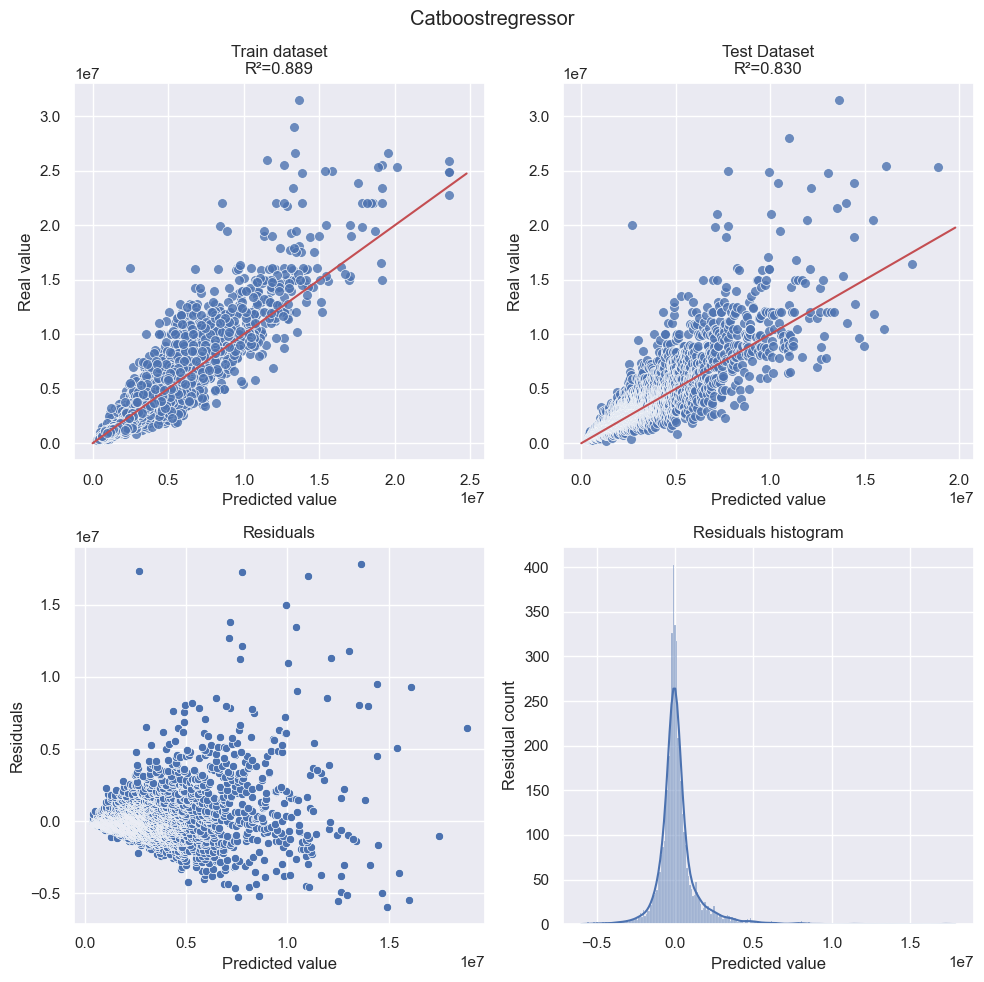

In [100]:
# Plot forest model

regressor_to_plot = catboost_regressor_cpu
X_train_data_to_plot = X_train_wo_OHE
y_train_data_to_plot = y_train_wo_OHE
X_test_data_to_plot = X_test_wo_OHE
y_test_data_to_plot = y_test_wo_OHE

fig, axs =  plt.subplots(2,2, figsize=(10,10))
fig.suptitle('Catboostregressor')
axs = iter(axs.reshape(1, -1)[0])

# Plotting of the train dataset
ax = next(axs)
y_hat = pd.Series(regressor_to_plot.predict(X_train_data_to_plot), index=X_train_data_to_plot.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat), y=np.expm1(y_train_data_to_plot), marker= 'o', s=50, alpha=0.8, ax=ax)

extented_pandas.draw_1_1_line(ax)

ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Train dataset\nR²={regressor_to_plot.score(X_train_data_to_plot, y_train_data_to_plot):.3f}'
)

# Plotting of the test dataset
ax = next(axs)
y_hat = pd.Series(regressor_to_plot.predict(X_test_data_to_plot), index=X_test_data_to_plot.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat), y=np.expm1(y_test_data_to_plot.loc[y_hat.index]), marker= 'o', s=50, alpha=0.8, ax=ax)

extented_pandas.draw_1_1_line(ax)

ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Test Dataset\nR²={regressor_to_plot.score(X_test_data_to_plot, y_test_data_to_plot):.3f}'
)

# Plotting of residuals

ax = next(axs)
sorted_y_test = y_test_data_to_plot.sort_values()
sorted_x_test = X_test_data_to_plot.reindex(sorted_y_test.index)
predicted_values = np.expm1(regressor_to_plot.predict(sorted_x_test))
residuals = (np.expm1(sorted_y_test) - predicted_values)
sns.scatterplot(x=predicted_values, y=residuals, ax=ax)
ax.set(ylabel='Residuals',
       xlabel='Predicted value',
	   title=f'Residuals'
);

# Plotting of residuals Histogram

ax = next(axs)
sns.histplot(data=residuals, ax=ax, kde=True)
ax.set(ylabel='Residual count',
       xlabel='Predicted value',
	   title=f'Residuals histogram'
);

fig.tight_layout()

# Lightgbm

In [101]:
lgbmreg = LGBMRegressor().fit(X_train, y_train)

lgbmreg.score(X_test, y_test_log)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 7848, number of used features: 71
[LightGBM] [Info] Start training from score 14.712505


0.8188764996549612

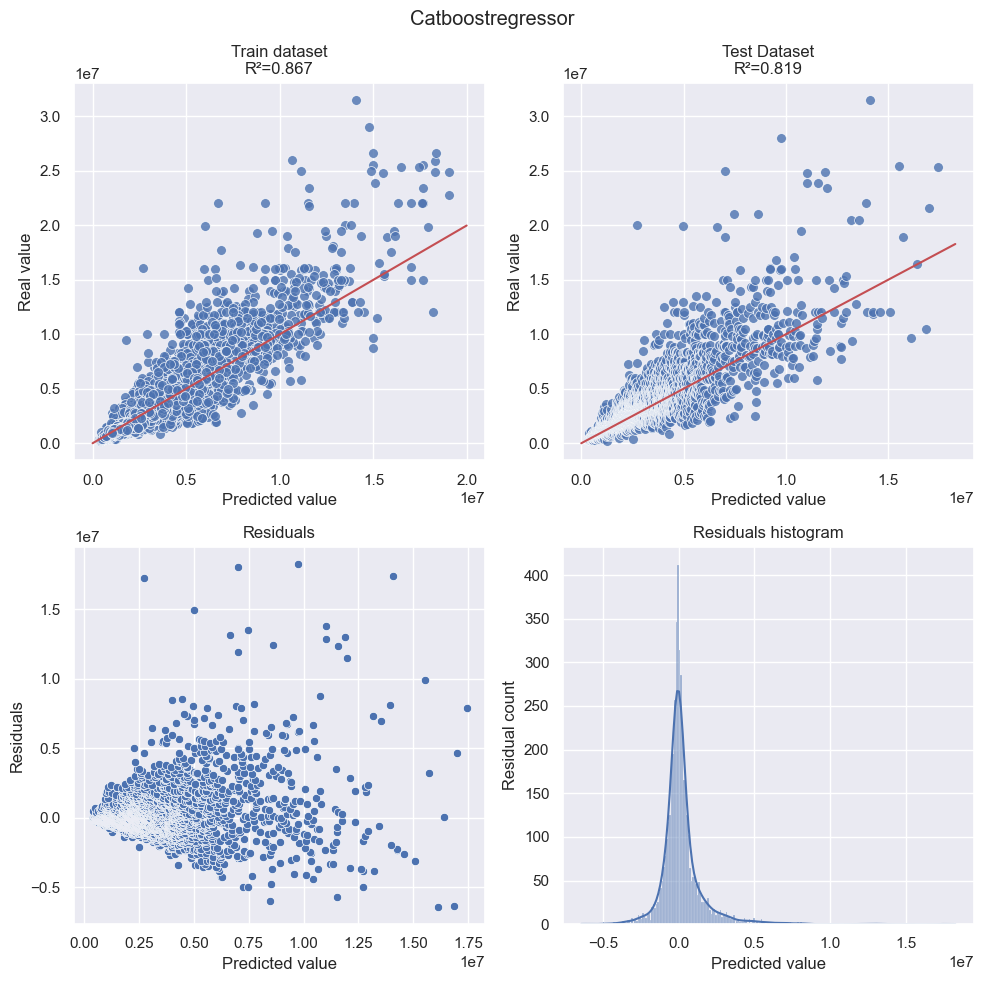

In [102]:
# Plot forest model

regressor_to_plot = lgbmreg
X_train_data_to_plot = X_train
y_train_data_to_plot = y_train
X_test_data_to_plot = X_test
y_test_data_to_plot = y_test_log

fig, axs =  plt.subplots(2,2, figsize=(10,10))
fig.suptitle('Catboostregressor')
axs = iter(axs.reshape(1, -1)[0])

# Plotting of the train dataset
ax = next(axs)
y_hat = pd.Series(regressor_to_plot.predict(X_train_data_to_plot), index=X_train_data_to_plot.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat), y=np.expm1(y_train_data_to_plot), marker= 'o', s=50, alpha=0.8, ax=ax)

extented_pandas.draw_1_1_line(ax)

ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Train dataset\nR²={regressor_to_plot.score(X_train_data_to_plot, y_train_data_to_plot):.3f}'
)

# Plotting of the test dataset
ax = next(axs)
y_hat = pd.Series(regressor_to_plot.predict(X_test_data_to_plot), index=X_test_data_to_plot.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat), y=np.expm1(y_test_data_to_plot.loc[y_hat.index]), marker= 'o', s=50, alpha=0.8, ax=ax)

extented_pandas.draw_1_1_line(ax)

ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Test Dataset\nR²={regressor_to_plot.score(X_test_data_to_plot, y_test_data_to_plot):.3f}'
)

# Plotting of residuals

ax = next(axs)
sorted_y_test = y_test_data_to_plot.sort_values()
sorted_x_test = X_test_data_to_plot.reindex(sorted_y_test.index)
predicted_values = np.expm1(regressor_to_plot.predict(sorted_x_test))
residuals = (np.expm1(sorted_y_test) - predicted_values)
sns.scatterplot(x=predicted_values, y=residuals, ax=ax)
ax.set(ylabel='Residuals',
       xlabel='Predicted value',
	   title=f'Residuals'
);

# Plotting of residuals Histogram

ax = next(axs)
sns.histplot(data=residuals, ax=ax, kde=True)
ax.set(ylabel='Residual count',
       xlabel='Predicted value',
	   title=f'Residuals histogram'
);

fig.tight_layout()

# xgboost

In [103]:
from xgboost import XGBRegressor

xbgreg = XGBRegressor().fit(X_train, y_train)

xbgreg.score(X_test, y_test_log)

0.8233004036523061

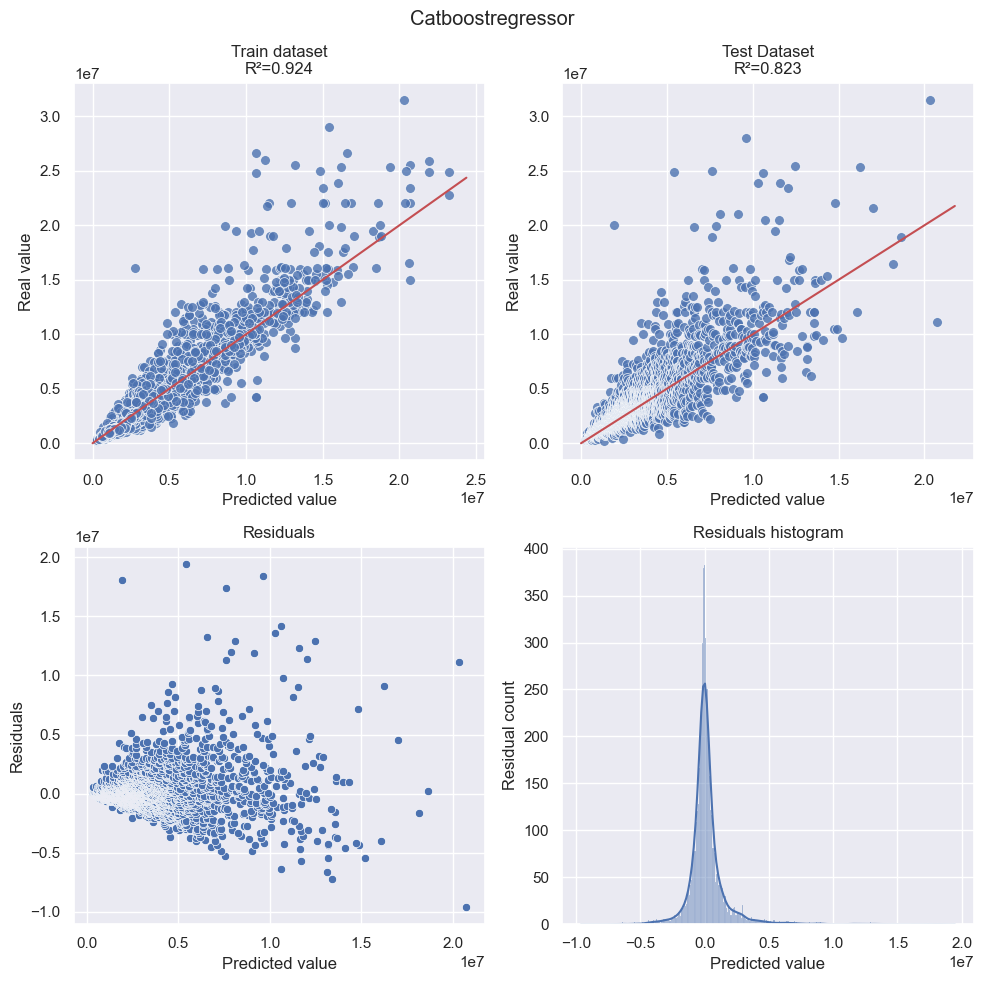

In [104]:
# Plot forest model

regressor_to_plot = xbgreg
X_train_data_to_plot = X_train
y_train_data_to_plot = y_train
X_test_data_to_plot = X_test
y_test_data_to_plot = y_test_log

fig, axs =  plt.subplots(2,2, figsize=(10,10))
fig.suptitle('Catboostregressor')
axs = iter(axs.reshape(1, -1)[0])

# Plotting of the train dataset
ax = next(axs)
y_hat = pd.Series(regressor_to_plot.predict(X_train_data_to_plot), index=X_train_data_to_plot.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat), y=np.expm1(y_train_data_to_plot), marker= 'o', s=50, alpha=0.8, ax=ax)

extented_pandas.draw_1_1_line(ax)

ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Train dataset\nR²={regressor_to_plot.score(X_train_data_to_plot, y_train_data_to_plot):.3f}'
)

# Plotting of the test dataset
ax = next(axs)
y_hat = pd.Series(regressor_to_plot.predict(X_test_data_to_plot), index=X_test_data_to_plot.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat), y=np.expm1(y_test_data_to_plot.loc[y_hat.index]), marker= 'o', s=50, alpha=0.8, ax=ax)

extented_pandas.draw_1_1_line(ax)

ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Test Dataset\nR²={regressor_to_plot.score(X_test_data_to_plot, y_test_data_to_plot):.3f}'
)

# Plotting of residuals

ax = next(axs)
sorted_y_test = y_test_data_to_plot.sort_values()
sorted_x_test = X_test_data_to_plot.reindex(sorted_y_test.index)
predicted_values = np.expm1(regressor_to_plot.predict(sorted_x_test))
residuals = (np.expm1(sorted_y_test) - predicted_values)
sns.scatterplot(x=predicted_values, y=residuals, ax=ax)
ax.set(ylabel='Residuals',
       xlabel='Predicted value',
	   title=f'Residuals'
);

# Plotting of residuals Histogram

ax = next(axs)
sns.histplot(data=residuals, ax=ax, kde=True)
ax.set(ylabel='Residual count',
       xlabel='Predicted value',
	   title=f'Residuals histogram'
);

fig.tight_layout()

# GBR

In [105]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor().fit(X_train, y_train)

gbr.score(X_test, y_test_log)

0.7900138615024977

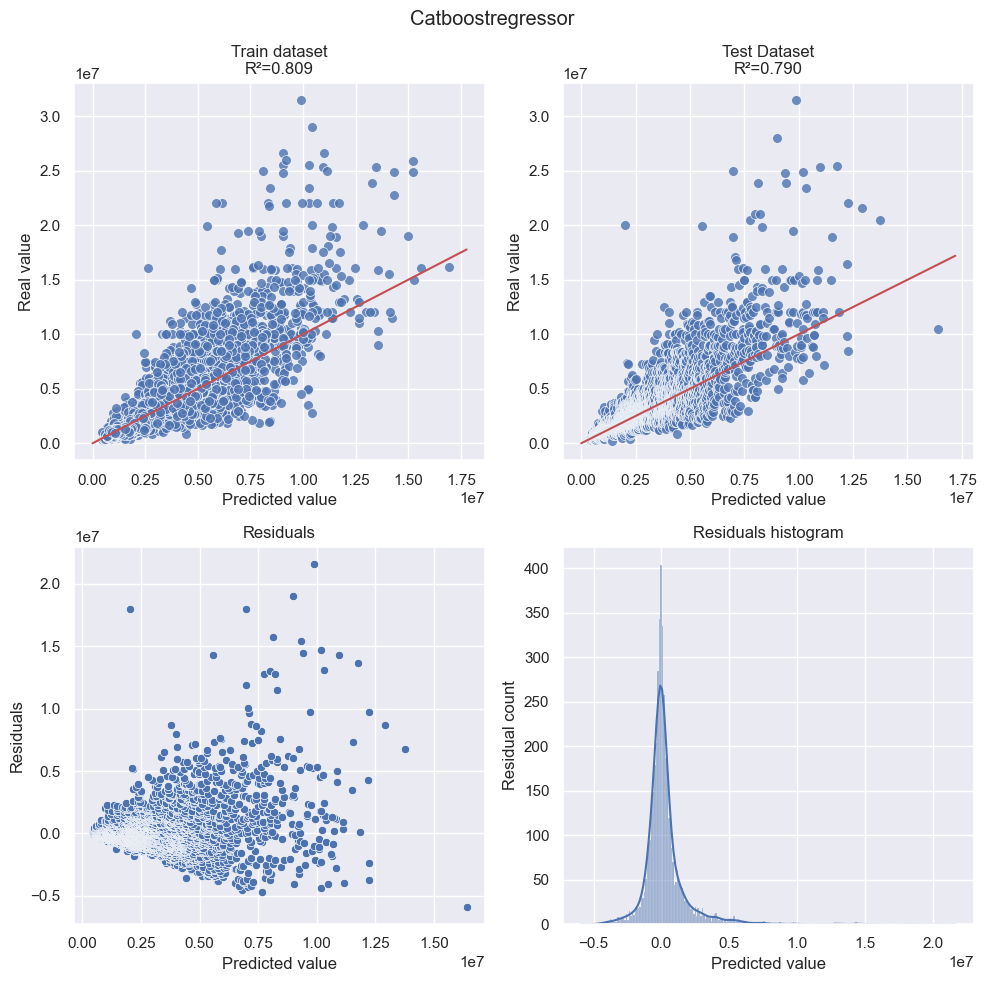

In [106]:
# Plot forest model

regressor_to_plot = gbr
X_train_data_to_plot = X_train
y_train_data_to_plot = y_train
X_test_data_to_plot = X_test
y_test_data_to_plot = y_test_log

fig, axs =  plt.subplots(2,2, figsize=(10,10))
fig.suptitle('Catboostregressor')
axs = iter(axs.reshape(1, -1)[0])

# Plotting of the train dataset
ax = next(axs)
y_hat = pd.Series(regressor_to_plot.predict(X_train_data_to_plot), index=X_train_data_to_plot.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat), y=np.expm1(y_train_data_to_plot), marker= 'o', s=50, alpha=0.8, ax=ax)

extented_pandas.draw_1_1_line(ax)

ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Train dataset\nR²={regressor_to_plot.score(X_train_data_to_plot, y_train_data_to_plot):.3f}'
)

# Plotting of the test dataset
ax = next(axs)
y_hat = pd.Series(regressor_to_plot.predict(X_test_data_to_plot), index=X_test_data_to_plot.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat), y=np.expm1(y_test_data_to_plot.loc[y_hat.index]), marker= 'o', s=50, alpha=0.8, ax=ax)

extented_pandas.draw_1_1_line(ax)

ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Test Dataset\nR²={regressor_to_plot.score(X_test_data_to_plot, y_test_data_to_plot):.3f}'
)

# Plotting of residuals

ax = next(axs)
sorted_y_test = y_test_data_to_plot.sort_values()
sorted_x_test = X_test_data_to_plot.reindex(sorted_y_test.index)
predicted_values = np.expm1(regressor_to_plot.predict(sorted_x_test))
residuals = (np.expm1(sorted_y_test) - predicted_values)
sns.scatterplot(x=predicted_values, y=residuals, ax=ax)
ax.set(ylabel='Residuals',
       xlabel='Predicted value',
	   title=f'Residuals'
);

# Plotting of residuals Histogram

ax = next(axs)
sns.histplot(data=residuals, ax=ax, kde=True)
ax.set(ylabel='Residual count',
       xlabel='Predicted value',
	   title=f'Residuals histogram'
);

fig.tight_layout()

# Testing for new Data (June)

In [107]:
# Retrieve data from 27/06/2023

df_test_june = pd.read_sql(f'SELECT `{string_useful_columns}` FROM `dados-imoveis` WHERE `scrapped_date` > "2023-03-01"', con=db_connection).set_index('id')
df_test_june[Cols.Test.value] = False

# Retrieving all amenities data

sql_query_amenities = 'SELECT * FROM `imoveis-balneario-camboriu`.amenities WHERE house_id in (SELECT id FROM `dados-imoveis`);'

df_amenities = pd.read_sql(sql_query_amenities, con=db_connection) \
    .drop(columns='id') \
    .set_index('house_id') \
    .fillna(0)

amenities_columns = list(set(X_test.columns).intersection(df_amenities.columns))
df_test_june = pd.merge(left=df_test_june, right=df_amenities[amenities_columns], left_index=True, right_index=True)
df_amenities = correct_amenities_datatype(df_amenities)

for transformation in pipeline_functions_dict:
    df_test_june = pipeline_functions_dict[transformation](df_test_june)

df_test_june = df_test_june.dropna()
y_june_log = df_test_june[Cols.Price.value]
df_test_june = df_test_june.drop(columns=[Cols.Price.value, 'test'])

missing_columns = list(set(X_test.columns) - set(df_test_june.columns))
df_test_june.loc[:, missing_columns] = 0
df_test_june.columns = X_test.columns

df_test_june[numerical_features_to_scale] = scaler.transform(df_test_june[numerical_features_to_scale])

df_test_june

Number of duplicates dropped: 17
Percentage of relevant entriess by type:  91.7%
Empty values in the district column that will be dropped: 231 - % of total: 8.53%
Number of entries removed because of the area: 0
Number of removed outliers in bedrooms: 23 (Upper bound: 5.771991269828211)
Number of removed outliers in garage_spaces: 1 (Upper bound: 18.415872475771025)
Number of removed outliers in bathrooms: 2 (Upper bound: 7.3235526944438)


area  bedrooms  garage_spaces  bathrooms  churrasqueira  \
15610 -0.184566 -0.320380       1.377722   0.501735              0   
15611 -0.446248 -0.320380      -0.328520   0.501735              0   
15612 -0.302592 -0.320380      -0.328520  -0.917911              0   
15613 -0.302592 -0.320380      -0.328520  -0.917911              0   
15614 -1.145608 -1.459787      -0.328520  -0.917911              0   
...         ...       ...            ...        ...            ...   
18572  0.797925  1.004085       1.377722   0.501735              0   
18574  0.396670  1.004085       1.377722  -0.917911              0   
18575  0.421188 -0.320380      -1.550413   0.501735              0   
18576  0.877142  1.004085       1.377722   1.197620              0   
18577  0.421188  1.004085       1.377722   1.197620              0   

       salão_de_festas  piscina  área_de_serviço  academia  elevador  \
15610                0        0                0         0         1   
15611                0        0                0         0         0   
15612                0        0                0         0         0   
15613                0        0                0         0         0   
15614                0        1                0         0         0   
...                ...      ...              ...       ...       ...   
18572                0        0                0         0         0   
18574                0        0                0         0         0   
18575                0        0                0         0         0   
18576                0        0                0         0         0   
18577                0        0                0         0         0   

       playground  mobiliado  salão_de_jogos  varanda  interfone  \
15610           0          0               0        0          0   
15611           0          0               0        0          0   
15612           0          0               0        0          0   
15613           0          0               0        0          0   
15614           0          0               0        0          0   
...           ...        ...             ...      ...        ...   
18572           0          0               0        0          0   
18574           0          0               0        0          0   
18575           0          0               0        0          0   
18576           0          0               0        0          0   
18577           0          0               0        0          0   

       aceita_animais  sauna  condomínio_fechado  lavanderia  \
15610               0      0                   0           0   
15611               0      0                   0           0   
15612               0      0                   0           0   
15613               0      0                   0           0   
15614               0      0                   0           0   
...               ...    ...                 ...         ...   
18572               0      0                   0           0   
18574               0      0                   0           0   
18575               0      0                   0           0   
18576               0      0                   0           0   
18577               0      0                   0           0   

       quadra_poliesportiva  cinema  portão_eletrônico  \
15610                     0       0                  0   
15611                     0       0                  0   
15612                     0       0                  0   
15613                     0       0                  0   
15614                     0       0                  1   
...                     ...     ...                ...   
18572                     0       0                  0   
18574                     0       0                  0   
18575                     0       0                  0   
18576                     0       0                  0   
18577                     0       0                  0   

       acesso_para_def

In [108]:
# Retrieve data from 27/06/2023 wo OHE

df_wihout_OHE_june = pd.read_sql(f'SELECT `{string_useful_columns}` FROM `dados-imoveis` WHERE `scrapped_date` > "2023-03-01"', con=db_connection).set_index('id')
df_wihout_OHE_june[Cols.Test.value] = False

# # Retrieving all amenities data

sql_query_amenities = 'SELECT * FROM `imoveis-balneario-camboriu`.amenities WHERE house_id in (SELECT id FROM `dados-imoveis`);'

df_amenities = pd.read_sql(sql_query_amenities, con=db_connection) \
    .drop(columns='id') \
    .set_index('house_id') \
    .fillna(0)

amenities_columns = list(set(X_test.columns).intersection(df_amenities.columns))
df_amenities = correct_amenities_datatype(df_amenities)
df_wihout_OHE_june = pd.merge(left=df_wihout_OHE_june, right=df_amenities[amenities_columns], left_index=True, right_index=True)

for transformation in pipeline_functions_dict:
    if transformation in ['set_dummies_for_categoricals', 'df_drop_duplicates', 'remove_small_prices']:
        continue
    
    df_wihout_OHE_june = pipeline_functions_dict[transformation](df_wihout_OHE_june)

# df_wihout_OHE_june = df_wihout_OHE_june.dropna()
y_no_OHE_log = df_wihout_OHE_june[Cols.Price.value].loc[df_test_june.index]
df_wihout_OHE_june = df_wihout_OHE_june.drop(columns=[Cols.Price.value, 'test'])

df_wihout_OHE_june[numerical_features_to_scale] = scaler.transform(df_wihout_OHE_june[numerical_features_to_scale])
df_wihout_OHE_june = df_wihout_OHE_june.loc[df_test_june.index]
df_wihout_OHE_june

Percentage of relevant entriess by type:  91.7%
Empty values in the district column that will be dropped: 233 - % of total: 8.55%
Number of entries removed because of the area: 0
Number of removed outliers in bedrooms: 24 (Upper bound: 5.776047129612662)
Number of removed outliers in garage_spaces: 1 (Upper bound: 18.38012138578916)
Number of removed outliers in bathrooms: 2 (Upper bound: 7.334625256772458)


area  bedrooms  garage_spaces  bathrooms  aquecimento  \
15610 -0.184566 -0.320380       1.377722   0.501735            0   
15611 -0.446248 -0.320380      -0.328520   0.501735            0   
15612 -0.302592 -0.320380      -0.328520  -0.917911            0   
15613 -0.302592 -0.320380      -0.328520  -0.917911            0   
15614 -1.145608 -1.459787      -0.328520  -0.917911            0   
...         ...       ...            ...        ...          ...   
18572  0.797925  1.004085       1.377722   0.501735            0   
18574  0.396670  1.004085       1.377722  -0.917911            0   
18575  0.421188 -0.320380      -1.550413   0.501735            0   
18576  0.877142  1.004085       1.377722   1.197620            0   
18577  0.421188  1.004085       1.377722   1.197620            0   

       armário_na_cozinha  acesso_para_deficientes  fogão  gerador_elétrico  \
15610                   0                        0      0                 0   
15611                   0                        0      0                 0   
15612                   0                        0      0                 0   
15613                   0                        0      0                 0   
15614                   0                        1      0                 0   
...                   ...                      ...    ...               ...   
18572                   0                        0      0                 0   
18574                   0                        0      0                 0   
18575                   0                        0      0                 0   
18576                   0                        0      0                 0   
18577                   0                        0      0                 0   

       spa  porcelanato  cozinha_americana  brinquedoteca  vigia  \
15610    1            0                  0              0      0   
15611    0            0                  0              0      0   
15612    0            0                  0              0      0   
15613    0            0                  0              0      0   
15614    0            0                  0              0      0   
...    ...          ...                ...            ...    ...   
18572    0            0                  0              0      0   
18574    0            0                  0              0      0   
18575    0            0                  0              0      0   
18576    0            0                  0              0      0   
18577    0            0                  0              0      0   

       estacionamento  recepção  quadra_de_tênis  depósito  \
15610               0         0                0         0   
15611               0         0                0         0   
15612               0         0                0         0   
15613               0         0                0         0   
15614               0         0                0         0   
...               ...       ...              ...       ...   
18572               0         0                0         0   
18574               0         0                0         0   
18575               0         0                0         0   
18576               0         0                0         0   
18577               0         0                0         0   

       condomínio_fechado  gesso_-_sanca_-_teto_rebaixado  \
15610                   0                               0   
15611                   0                               0   
15612                   0                               0   
15613                   0                               0   
15614                   0                               0   
...                   ...                             ...   
18572                   0                               0   
18574                   0                               0   
18575                   0                               0   
18576                   0                               0   
18577       

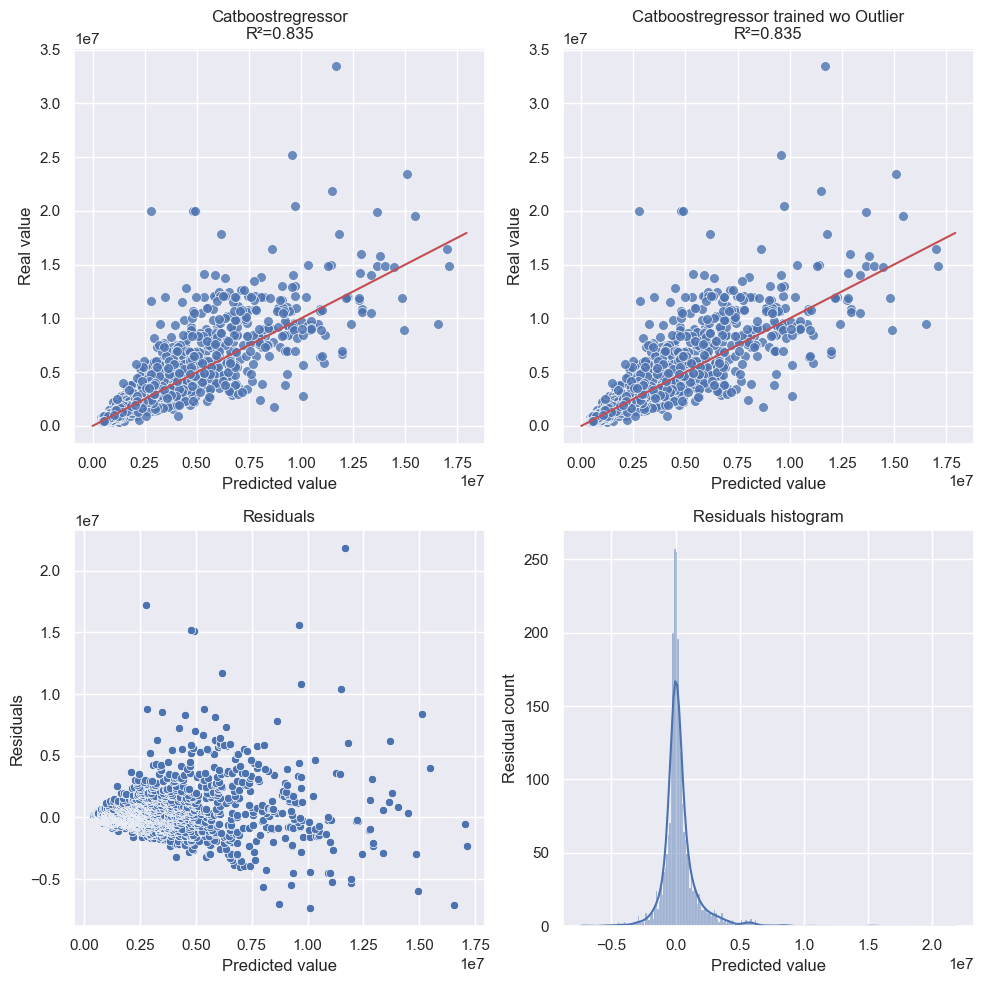

In [109]:
# Plot forest model

regressor_to_plot = catboost_regressor_cpu
X_data_to_plot = df_wihout_OHE_june
y_data_to_plot = y_no_OHE_log

fig, axs =  plt.subplots(2,2, figsize=(10,10))
axs = iter(axs.flatten())

# Plotting of the train dataset
ax = next(axs)
y_hat = pd.Series(regressor_to_plot.predict(X_data_to_plot), index=y_data_to_plot.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat), y=np.expm1(y_data_to_plot), marker= 'o', s=50, alpha=0.8, ax=ax)

extented_pandas.draw_1_1_line(ax)

ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Catboostregressor\nR²={regressor_to_plot.score(X_data_to_plot, y_data_to_plot):.3f}'
)

# Plotting of the test dataset
ax = next(axs)
y_hat = pd.Series(catboost_regressor_cpu_wo_outlier.predict(X_data_to_plot), index=y_data_to_plot.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat), y=np.expm1(y_data_to_plot), marker= 'o', s=50, alpha=0.8, ax=ax)

extented_pandas.draw_1_1_line(ax)

ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Catboostregressor trained wo Outlier\nR²={catboost_regressor_cpu_wo_outlier.score(X_data_to_plot, y_data_to_plot):.3f}'
)

# Plotting of residuals

ax = next(axs)
sorted_y_test = y_data_to_plot.sort_values()
sorted_x_test = X_data_to_plot.reindex(sorted_y_test.index)
predicted_values = np.expm1(regressor_to_plot.predict(sorted_x_test))
residuals = (np.expm1(sorted_y_test) - predicted_values)
sns.scatterplot(x=predicted_values, y=residuals, ax=ax)
ax.set(ylabel='Residuals',
       xlabel='Predicted value',
	   title=f'Residuals'
);

# Plotting of residuals Histogram

ax = next(axs)
sns.histplot(data=residuals, ax=ax, kde=True)
ax.set(ylabel='Residual count',
       xlabel='Predicted value',
	   title=f'Residuals histogram'
);

fig.tight_layout()

In [110]:
merged_residuals = pd.merge(left=df_wihout_OHE_june, right=residuals.rename('residuals'), left_index=True, right_index=True).sort_values('residuals')
merged_residuals = pd.merge(left=merged_residuals, right=pd.DataFrame(predicted_values, index=residuals.index, columns=['predicted value']), left_index=True, right_index=True)
merged_residuals = merged_residuals[['area', 'bedrooms', 'garage_spaces', 'bathrooms', 'tipo', 'bairro', 'residuals', 'predicted value']]
merged_residuals = pd.merge(left=merged_residuals, right=pd.DataFrame(np.expm1(y_no_OHE_log)), left_index=True, right_index=True)
merged_residuals

area  bedrooms  garage_spaces  bathrooms         tipo     bairro  \
16015  1.620523  1.004085       1.377722   0.501735  Apartamento     Centro   
17038  2.848498  1.004085       2.613171   1.197620  Apartamento     Centro   
16994  1.017670  1.004085       0.608302   1.197620  Apartamento  Barra Sul   
17467  1.944270  2.497530       2.035588   1.197620  Apartamento     Centro   
16674  1.334506  1.004085       0.608302   0.501735  Apartamento     Centro   
...         ...       ...            ...        ...          ...        ...   
17134  2.393132  1.004085       1.377722   0.501735         Casa     Centro   
15883  2.393132  2.497530       1.377722   1.886501         Casa     Centro   
18445  1.804357 -0.320380       2.035588   1.886501  Apartamento     Centro   
16567  2.393132  2.497530       1.377722   0.501735         Casa      other   
16361  3.351796  2.497530       3.598674   2.569441  Apartamento     Centro   

          residuals  predicted value       price  
16015 -7.353468e+06     1.010347e+07   2750000.0  
17038 -7.058896e+06     1.655890e+07   9500000.0  
16994 -6.974573e+06     8.729375e+06   1754802.0  
17467 -5.972717e+06     1.493608e+07   8963360.0  
16674 -5.622908e+06     8.022908e+06   2400000.0  
...             ...              ...         ...  
17134  1.509418e+07     4.905822e+06  20000000.0  
15883  1.519718e+07     4.802824e+06  20000000.0  
18445  1.560361e+07     9.596389e+06  25200000.0  
16567  1.721233e+07     2.787666e+06  20000000.0  
16361  2.181842e+07     1.168158e+07  33500000.0  

[2451 rows x 9 columns]

In [111]:
df_unscaled_june = merged_residuals.copy()
df_unscaled_june[numerical_features_to_scale] = scaler.inverse_transform(merged_residuals[numerical_features_to_scale])
df_unscaled_june = df_unscaled_june[df_unscaled_june[Cols.Garages.value] < 200]
df_unscaled_june['area'] = np.expm1(df_unscaled_june['area'])

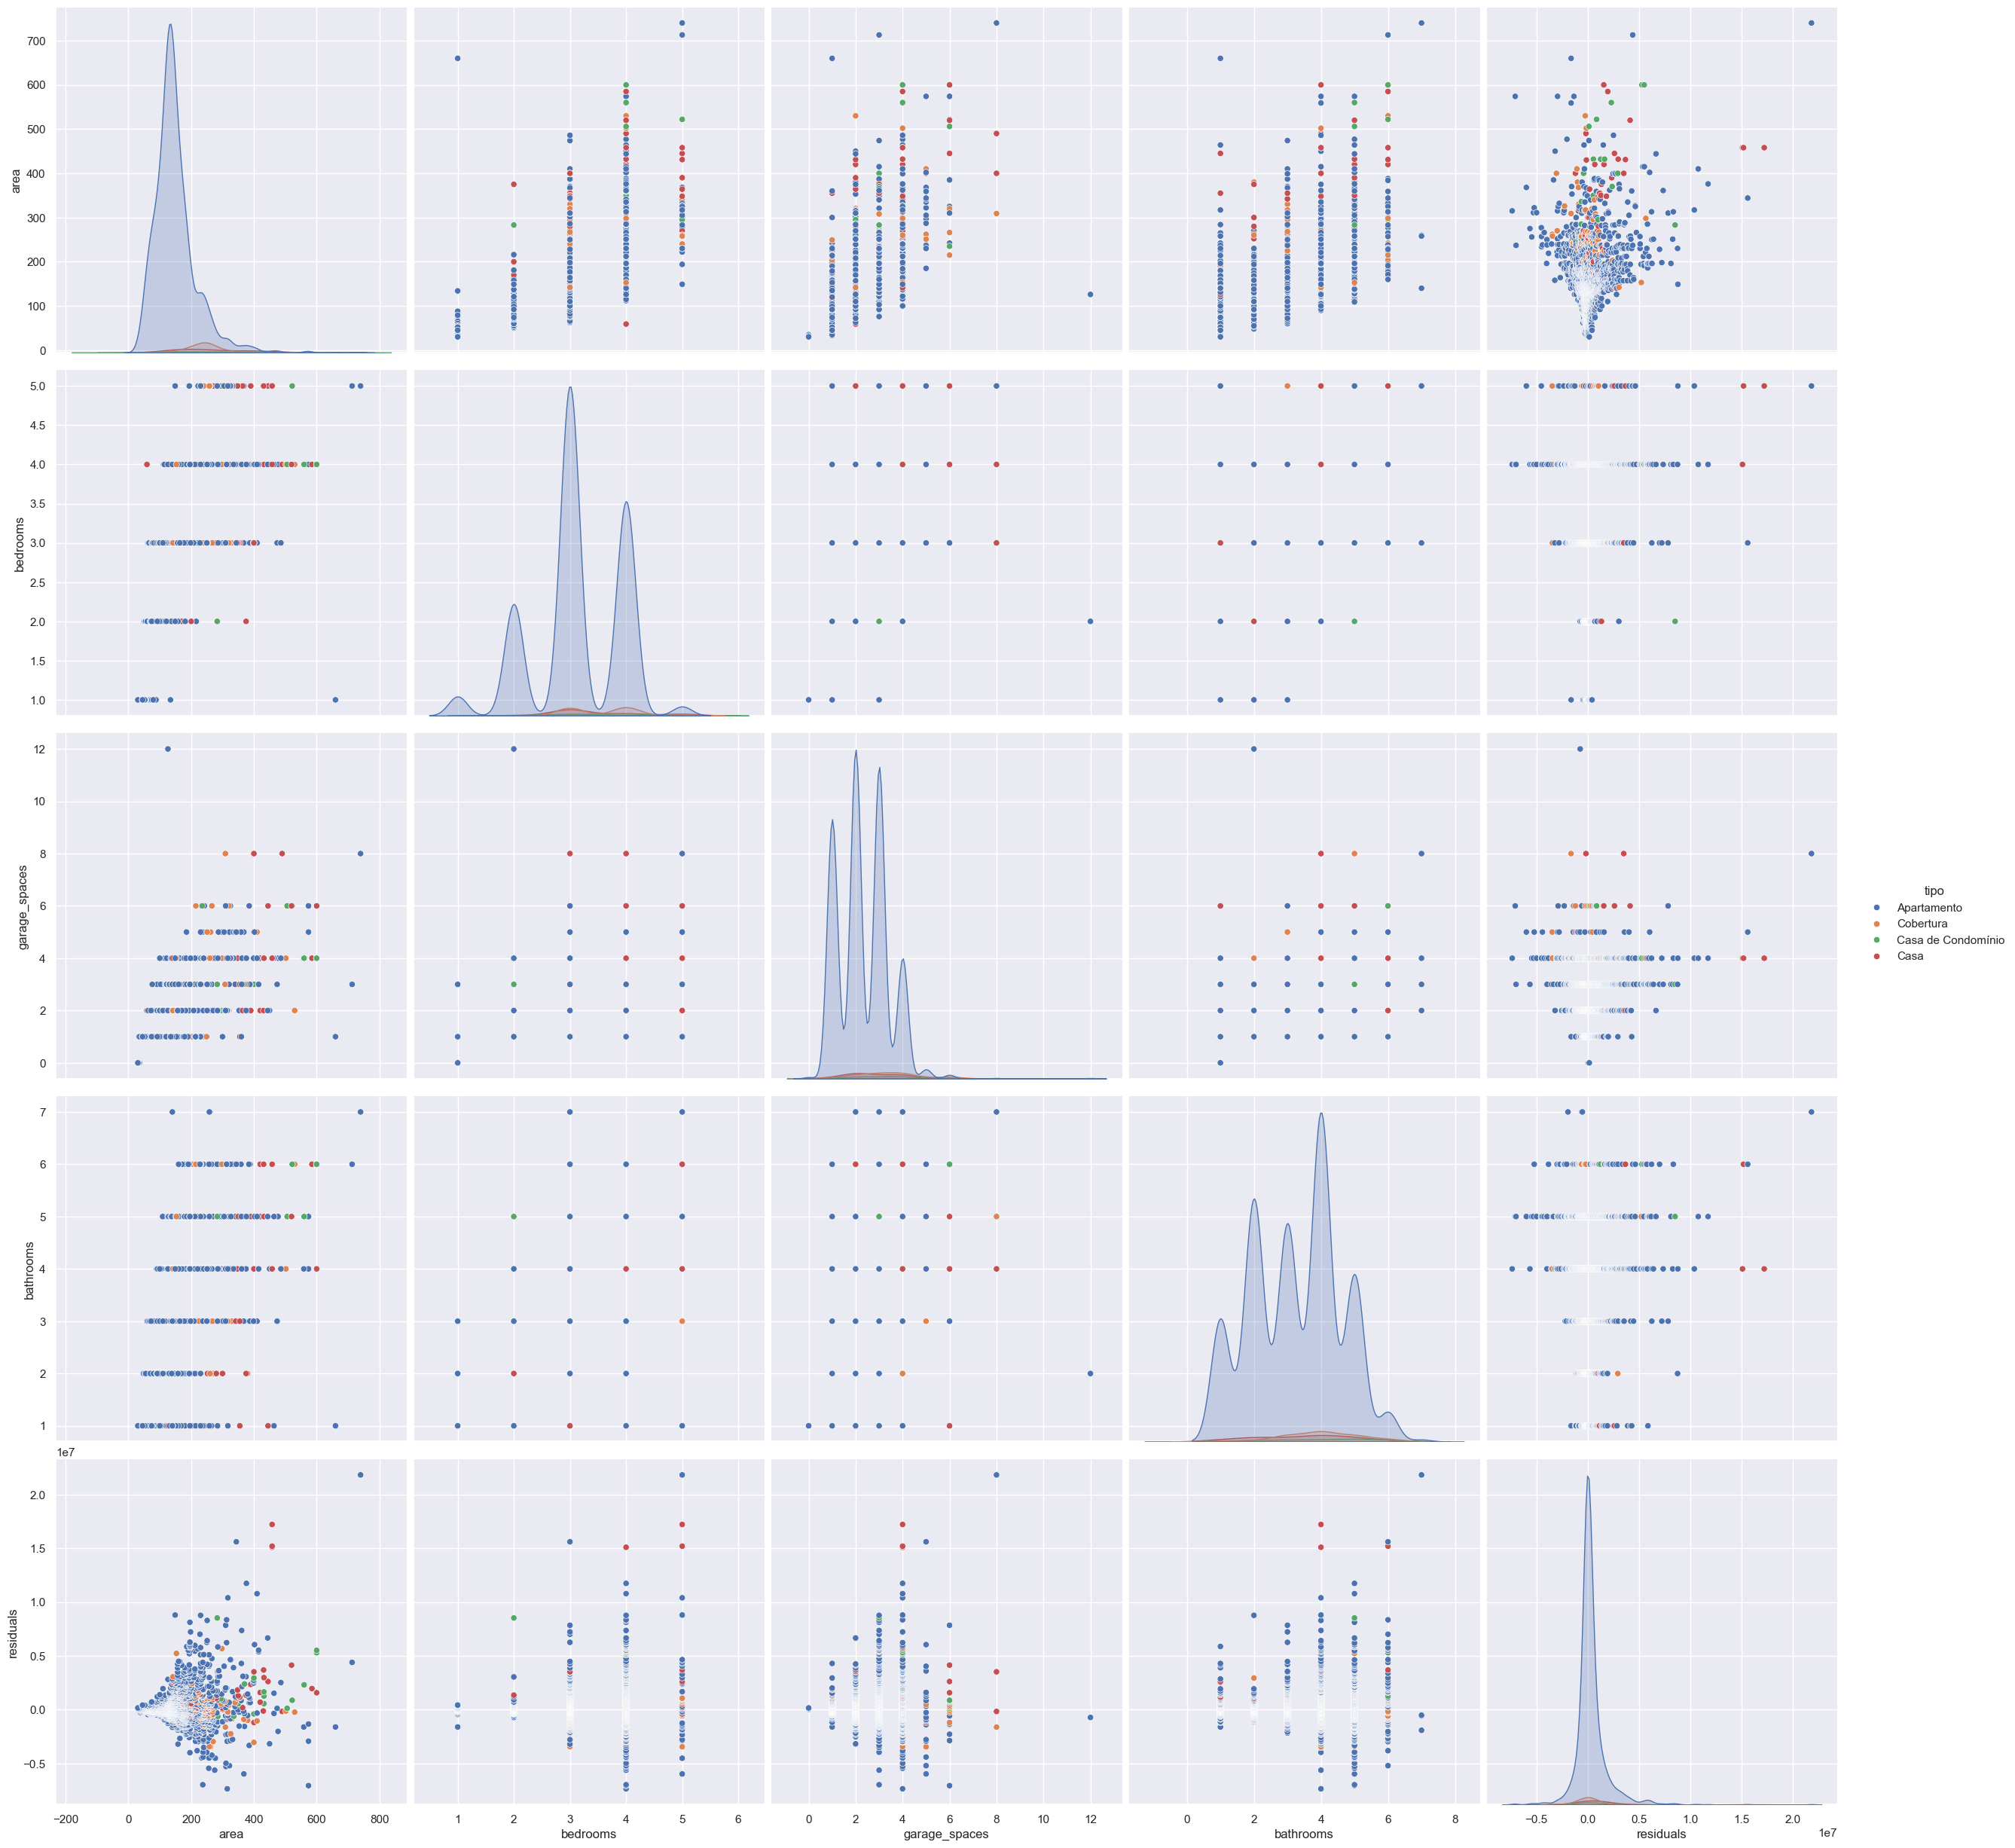

In [112]:
sns.pairplot(data=df_unscaled_june, vars=['area', 'bedrooms', 'garage_spaces', 'bathrooms', 'residuals'], hue='tipo', height=5)

<Axes: title={'center': 'Best Value'}, xlabel='price', ylabel='residuals'>

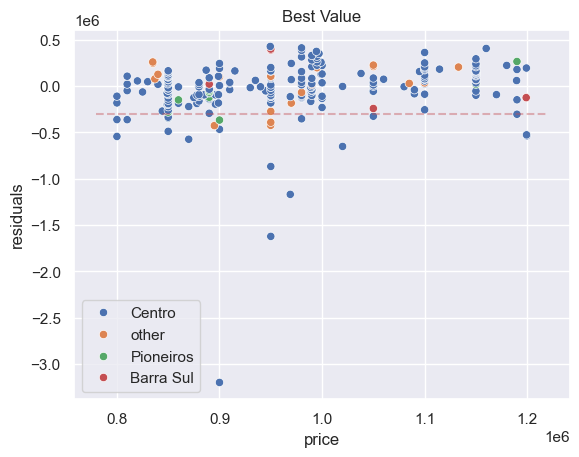

In [113]:
df_potential = df_unscaled_june[(df_unscaled_june['price'] < 1_200_000) & (df_unscaled_june['price'] > 800_000)].sort_values('residuals')
ax = sns.scatterplot(data=df_potential, x='price', y='residuals', hue='bairro')
ax.set(title='Best Value')
xmin, xmax, _, ymax = ax.axis()
axis_limit = [xmin, xmax]
sns.lineplot(x=axis_limit, y=[-0.3e6,-0.3e6], color='r', ax=ax, alpha=0.4, linestyle='dashed')

In [114]:
mask_residuals = (df_potential['residuals'] < -0.3e6)
mask_bedrooms = df_potential['area'] >= 80
mask_district = df_potential['bairro'] == 'Centro'

df_potential[mask_residuals & mask_district].drop(columns=['tipo', 'bairro']).style.format({
		'residuals': 'R${:,.0f}'.format,
		'predicted value': 'R${:,.0f}'.format,
		'price': 'R${:,.0f}'.format,
		'area': '{:,.0f}m²'.format,
		'bedrooms':'{:,.0f}'.format,
		'garage_spaces':'{:,.0f}'.format,
		'bathrooms':'{:,.0f}'.format,
})

In [129]:
scores = []

models = {
	'Linear regressor':best_regressor.model,
	'Random forest':forest,
	'LGBM':lgbmreg,
	'XGB':xbgreg,
	'GBR':gbr
}

for name, model in models.items():
	scores.append([name, model.score(df_test_june, y_june_log)])

scores.append(['Catboost', catboost_regressor_cpu.score(df_wihout_OHE_june, y_no_OHE_log)])

df_scores = pd.DataFrame(scores, columns=['Regressor', 'R2 Score']).sort_values('R2 Score', ascending=False)
df_scores

Regressor  R2 Score
5          Catboost  0.835433
1     Random forest  0.736563
4               GBR  0.724213
2              LGBM  0.716420
0  Linear regressor  0.668370
3               XGB  0.611178